In [1]:
from cpymad.madx import Madx
import numpy as np
import requests
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display


import matplotlib.patches as patches

def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha
    )
    )
    return;

## LHC squeeze 2016

In [2]:
# import elements, sequence and strengths
madx = Madx(stdout=False)
response = requests.get('http://abpdata.web.cern.ch/abpdata/lhc_optics_web/www/opt2016/inj/lhc_opt2016_inj.seq')
data = response.text
madx.input(data);

    
response = requests.get('http://abpdata.web.cern.ch/abpdata/lhc_optics_web/www/opt2016/inj/db5/opt_inj.madx')
data = response.text
madx.input(data);

In [3]:
madx.input(
'''
beam, sequence=lhcb1, bv= 1,
  particle=proton, charge=1, mass=0.938272046,
  energy= 450,   npart=1.2e11,kbunch=2076,
  ex=5.2126224777777785e-09,ey=5.2126224777777785e-09;

seqedit, sequence=lhcb1;
flatten;
cycle, start=ip1;
flatten;
endedit;
''');

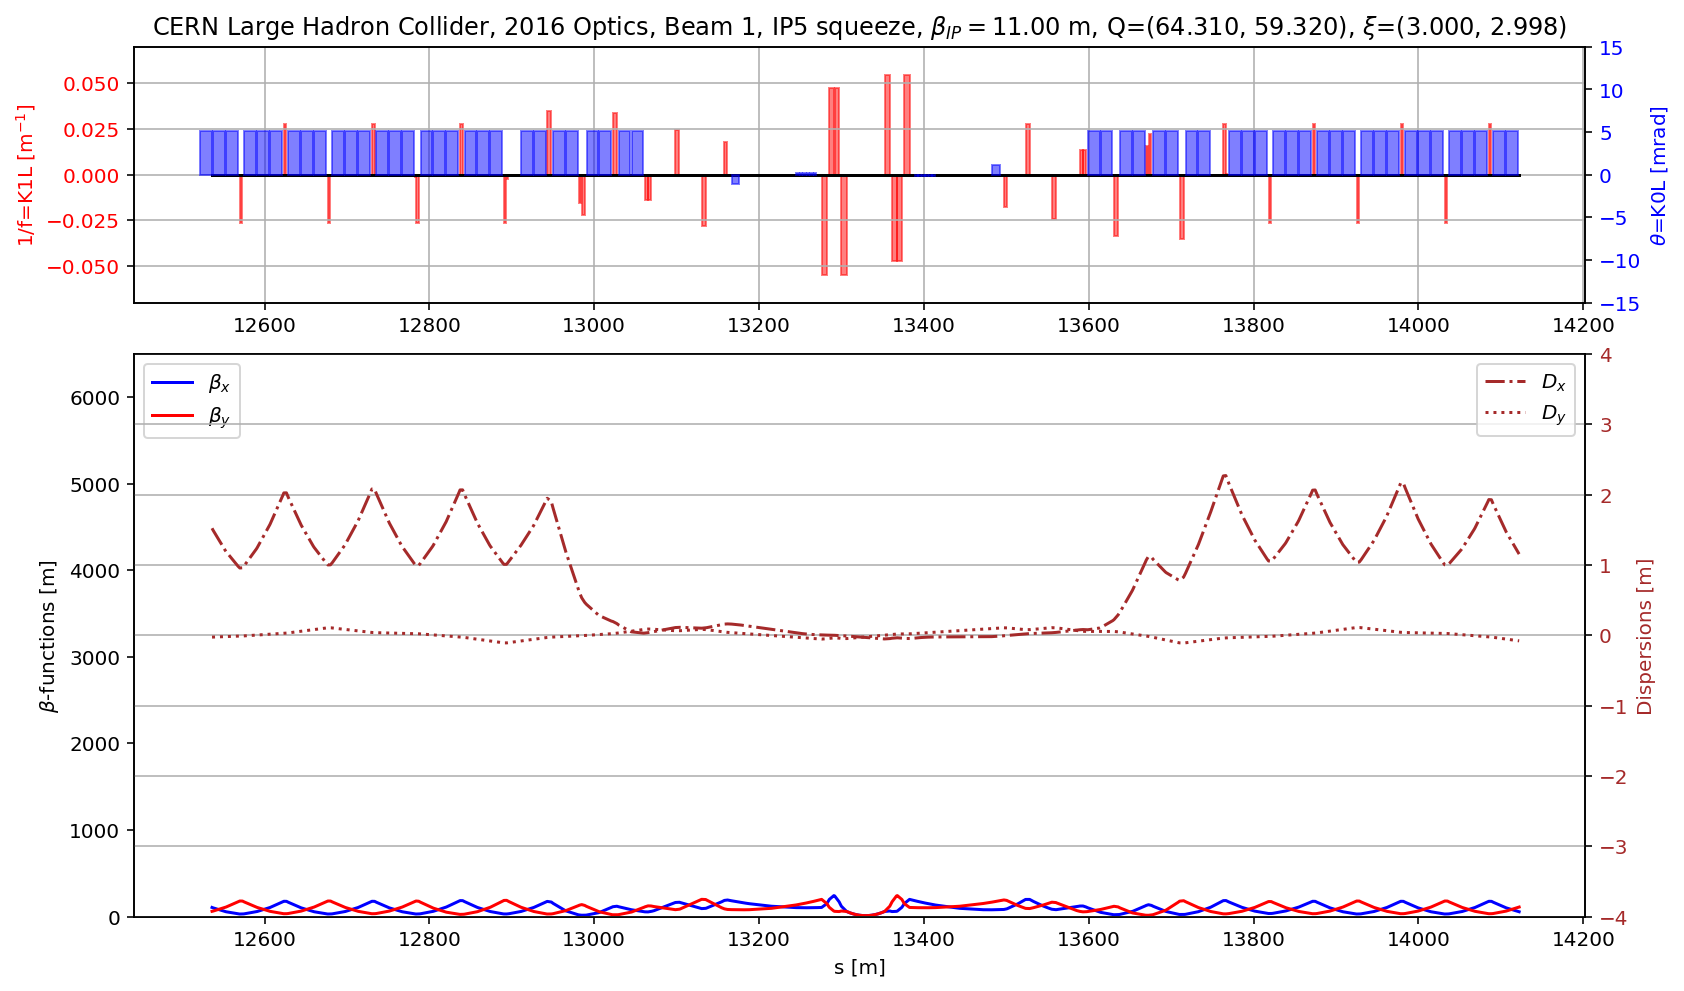

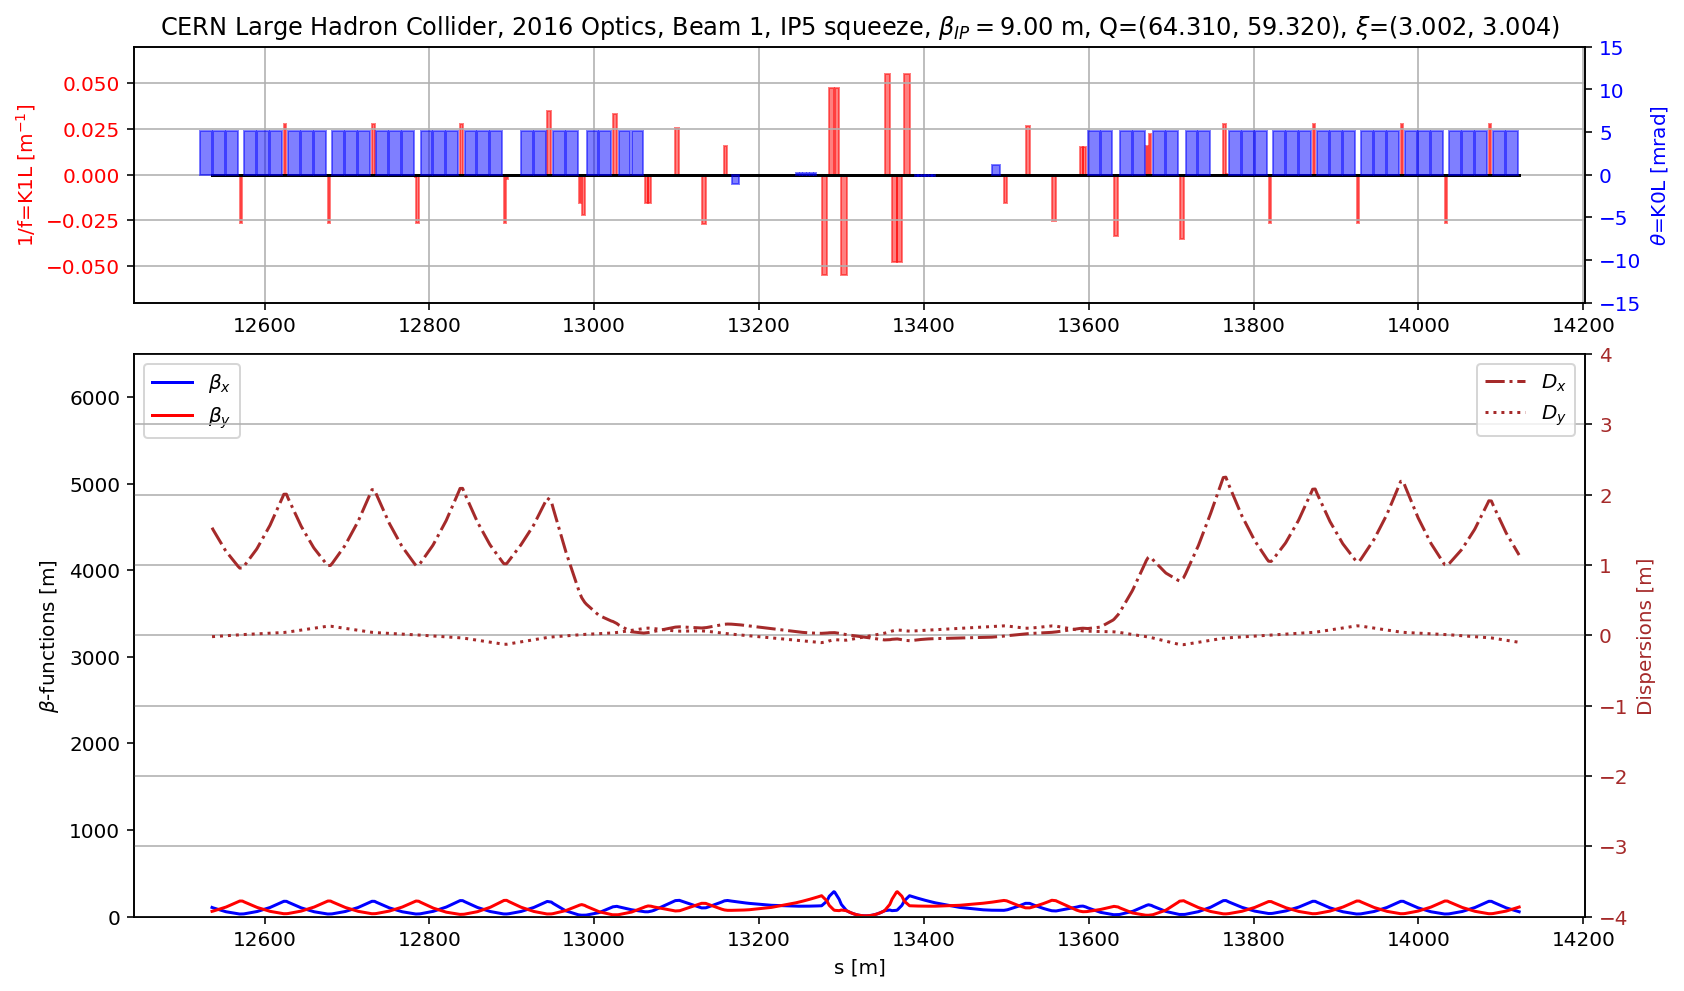

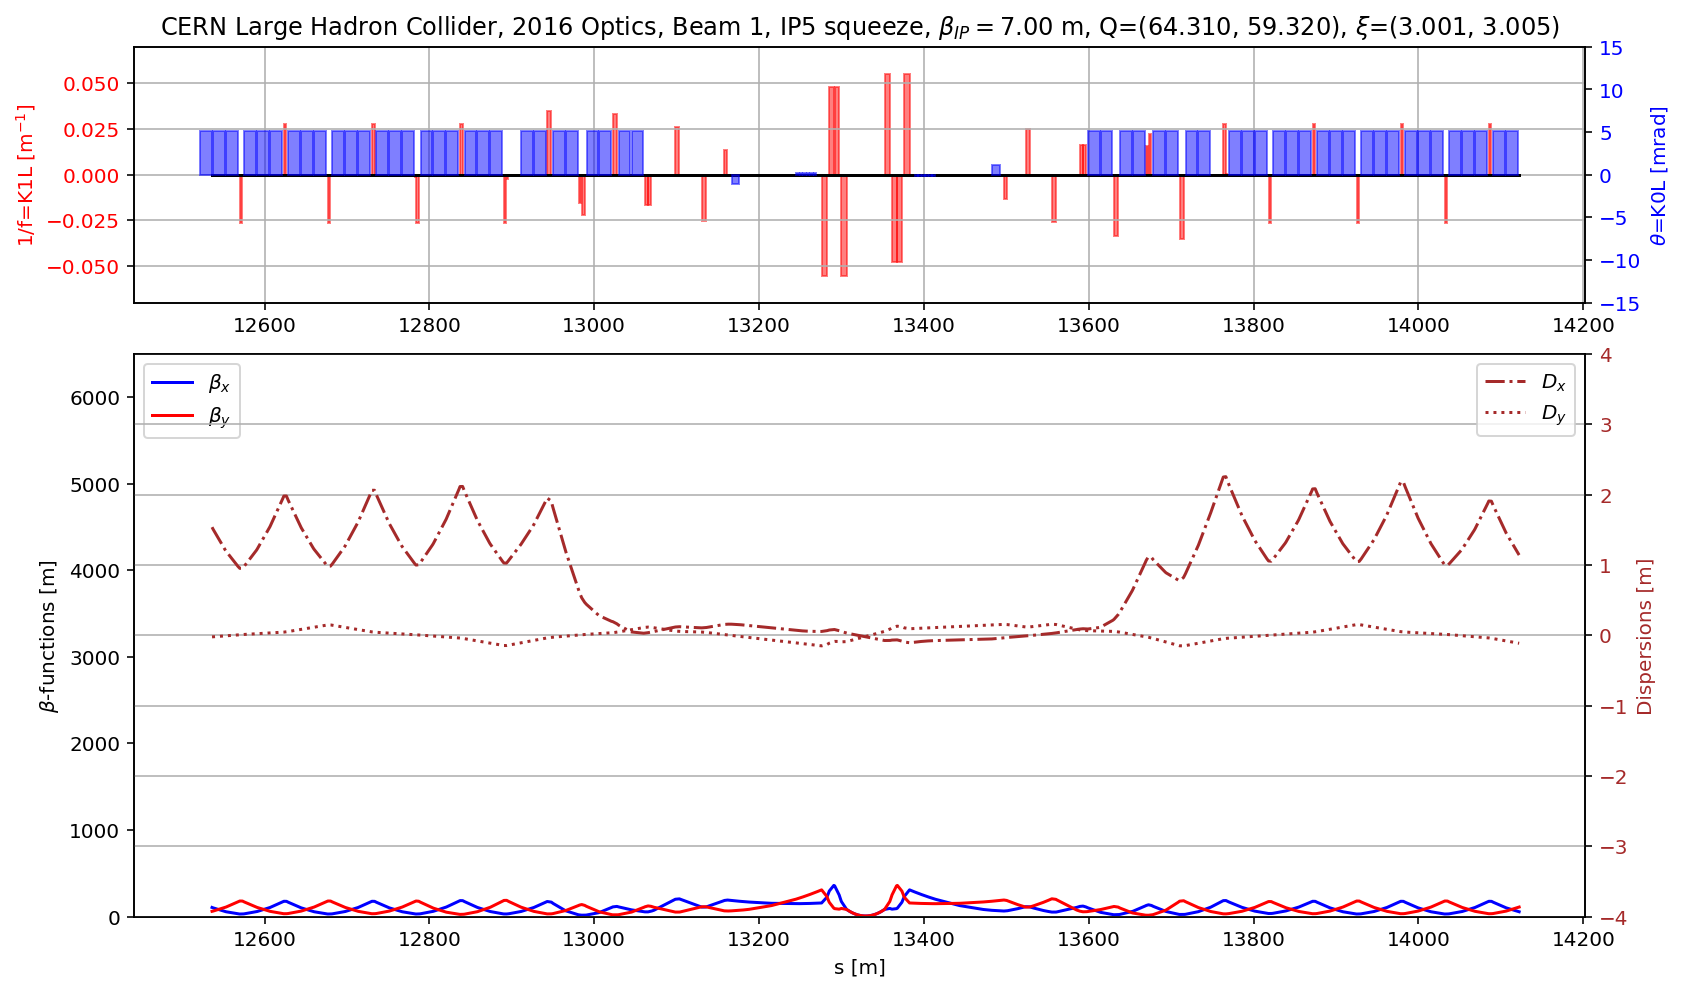

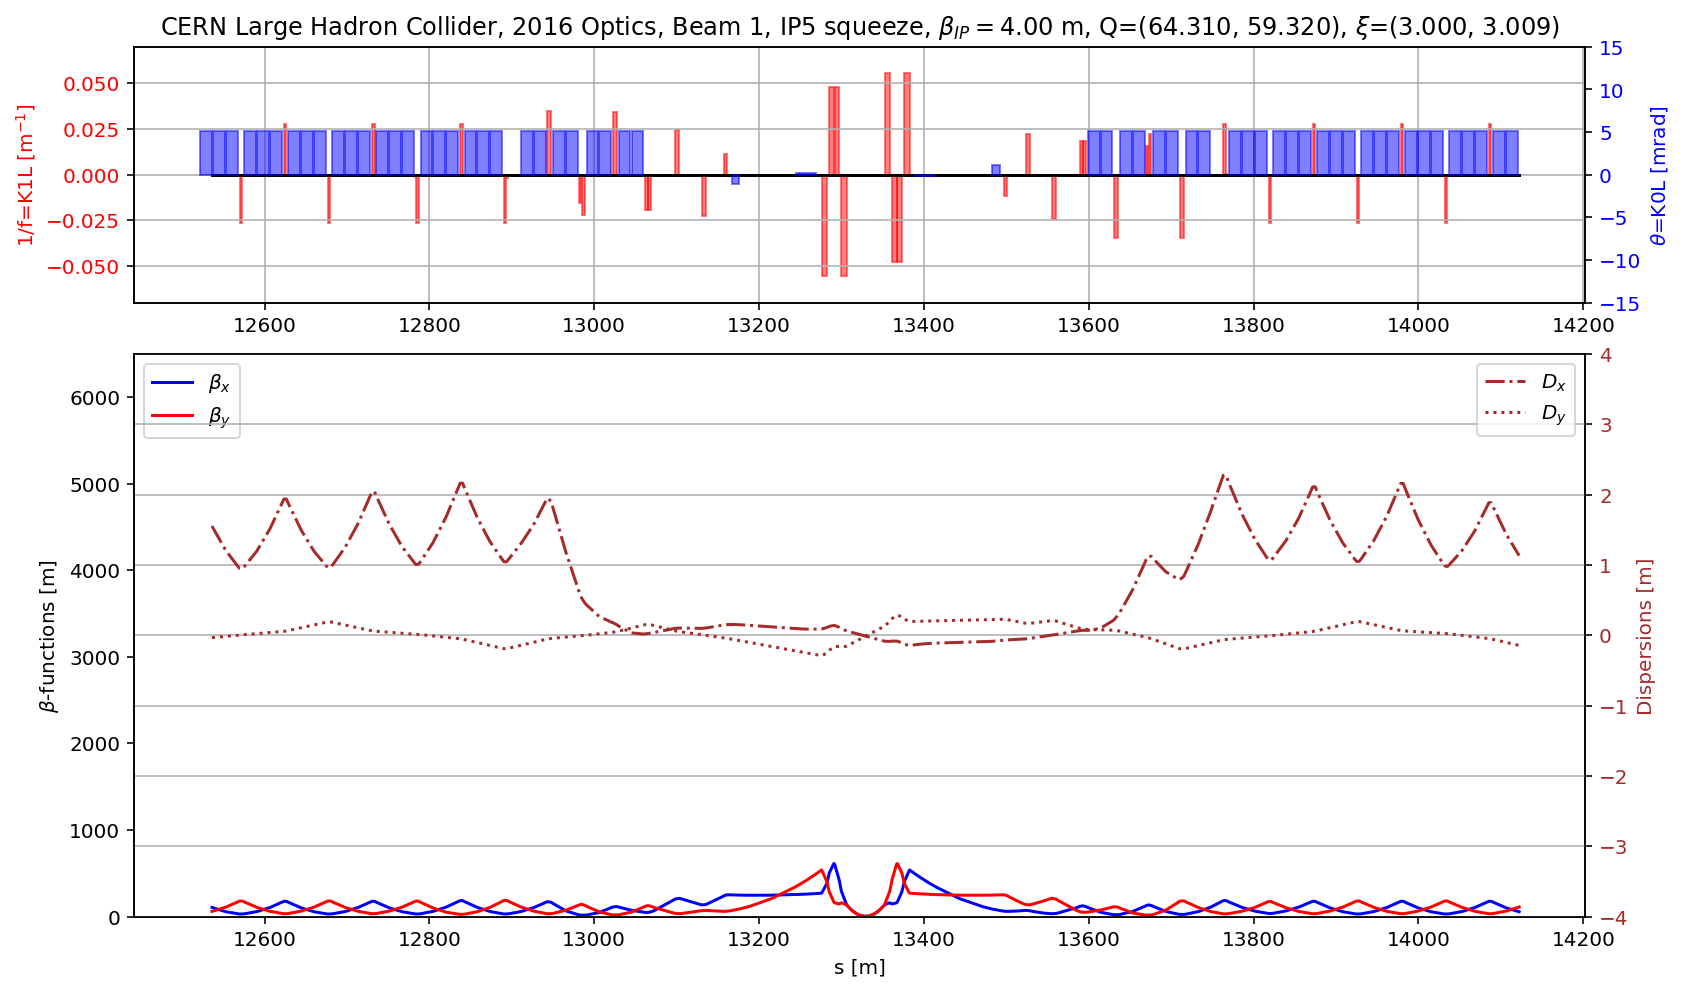

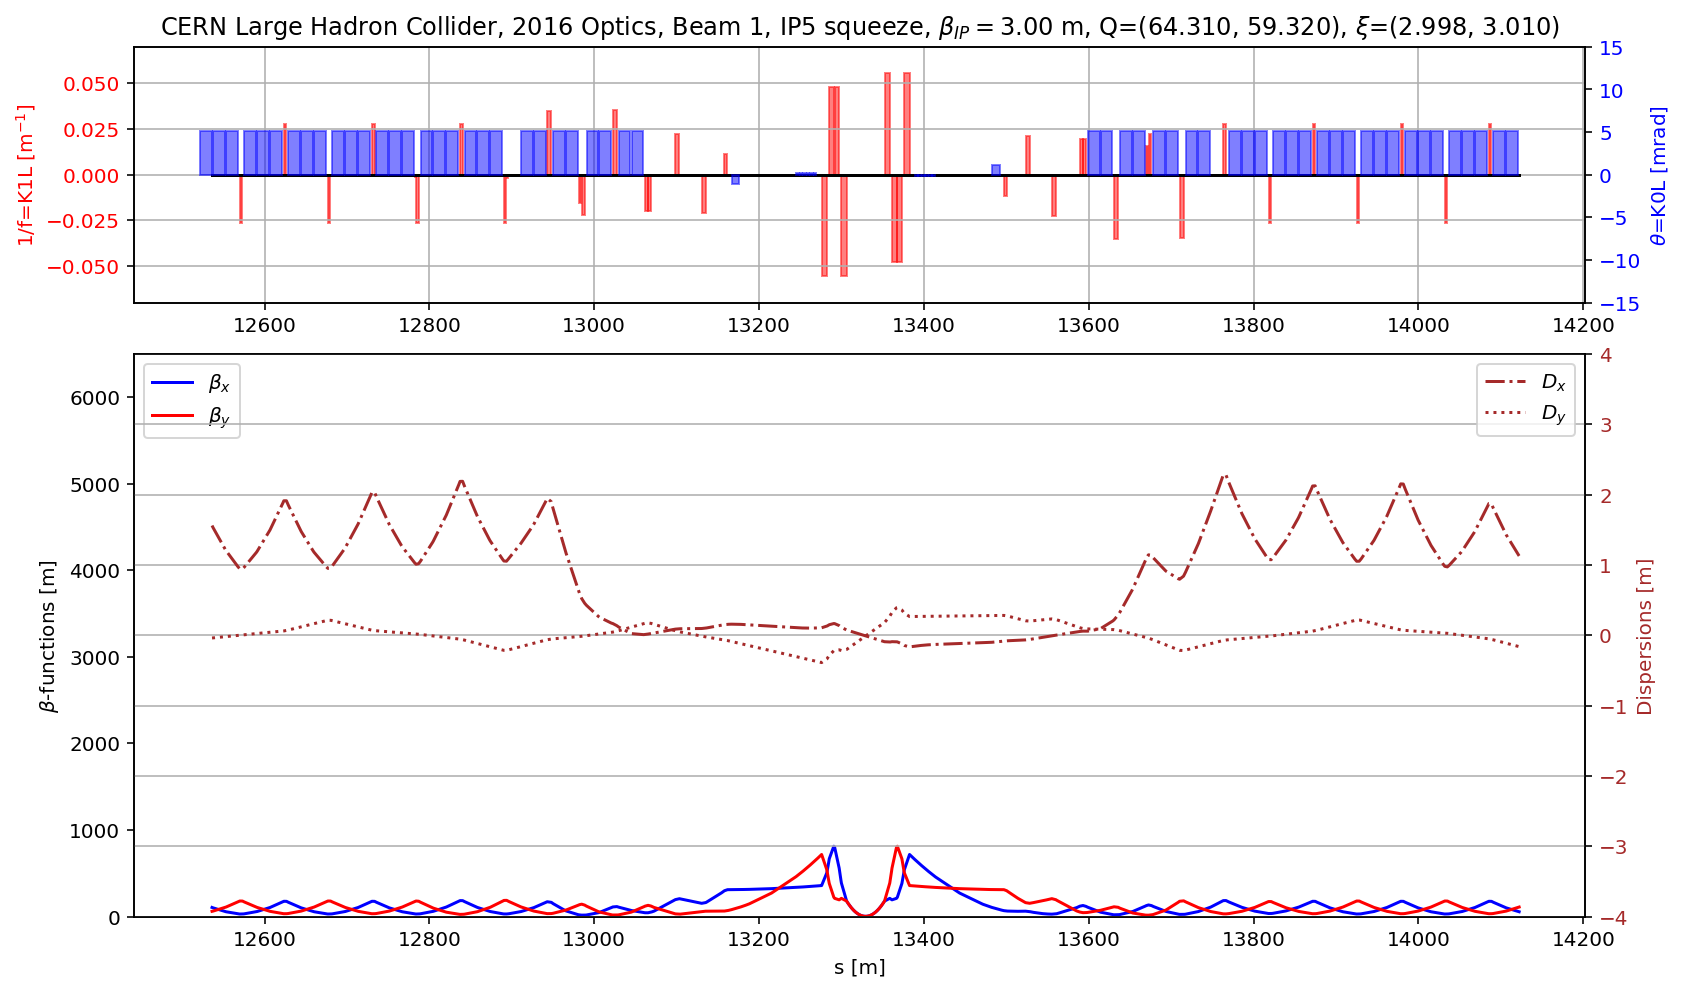

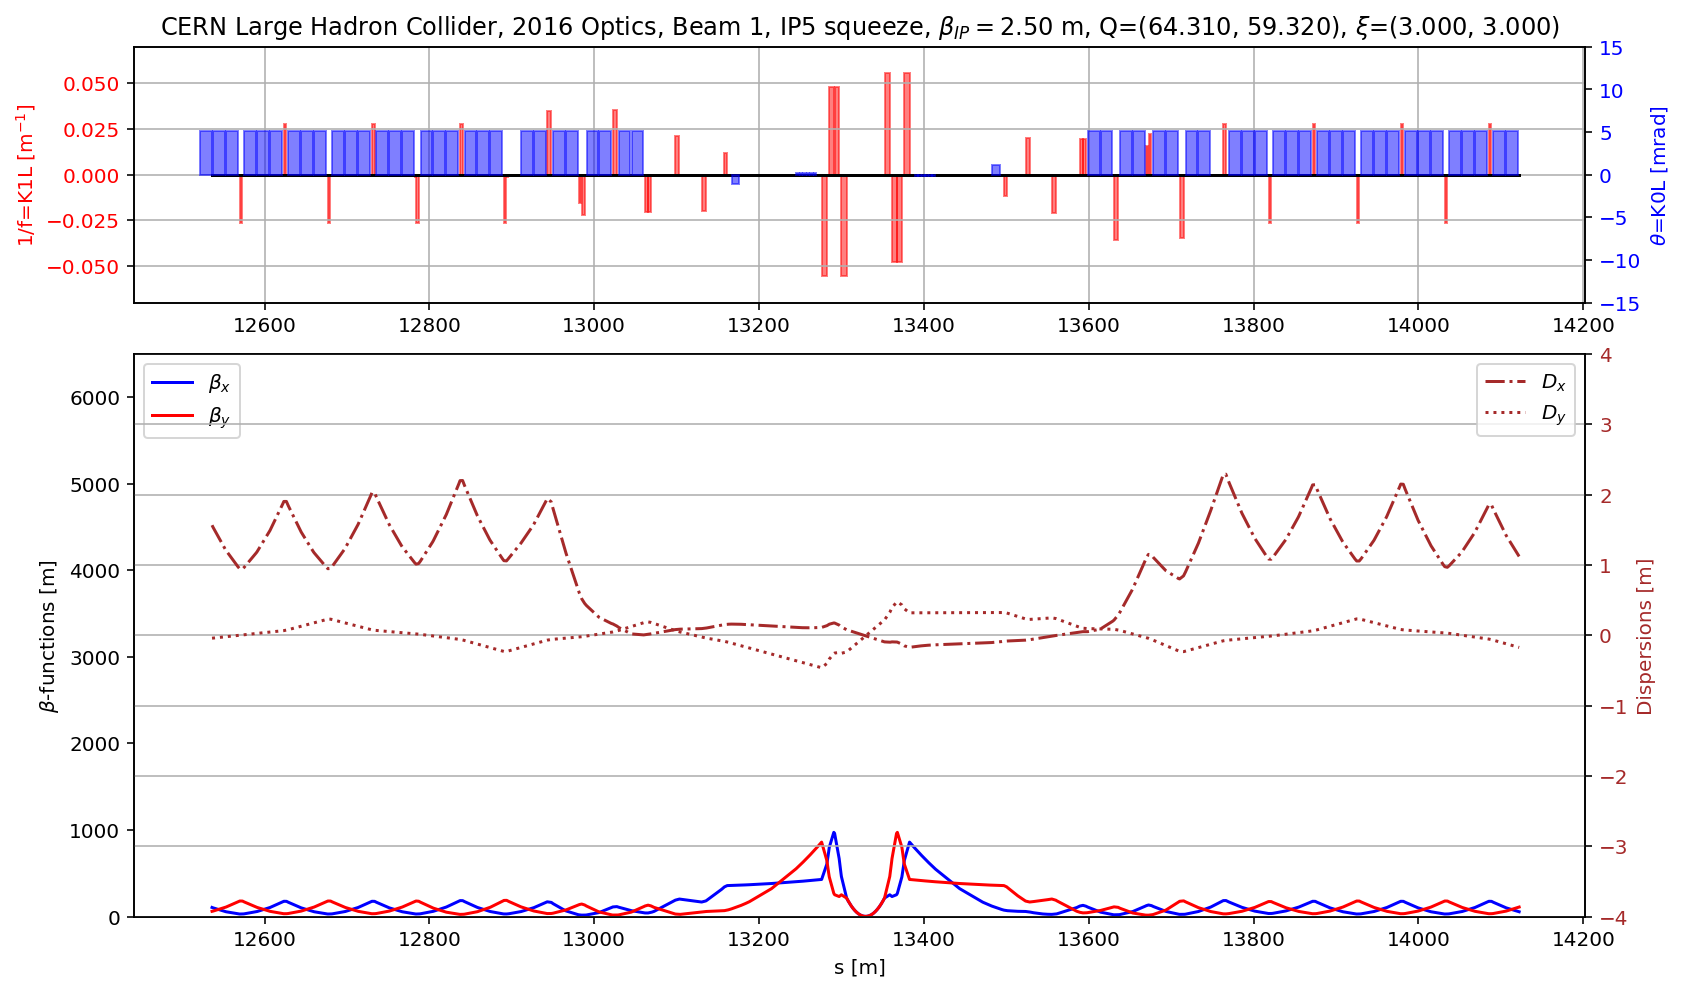

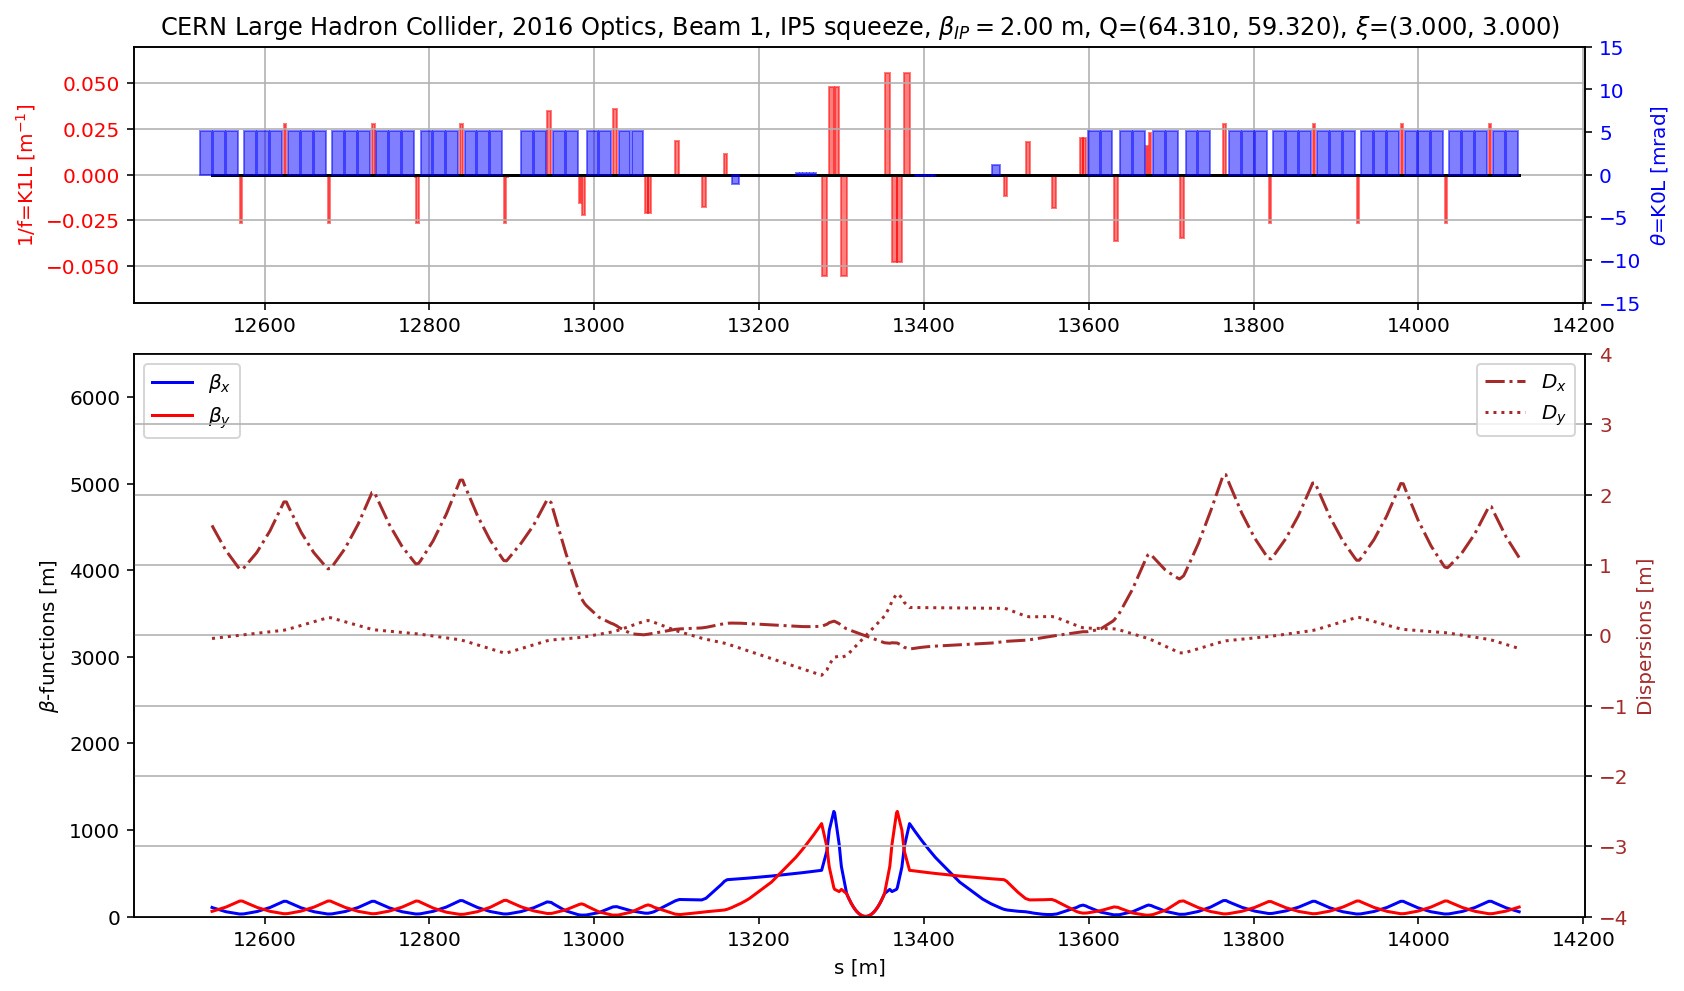

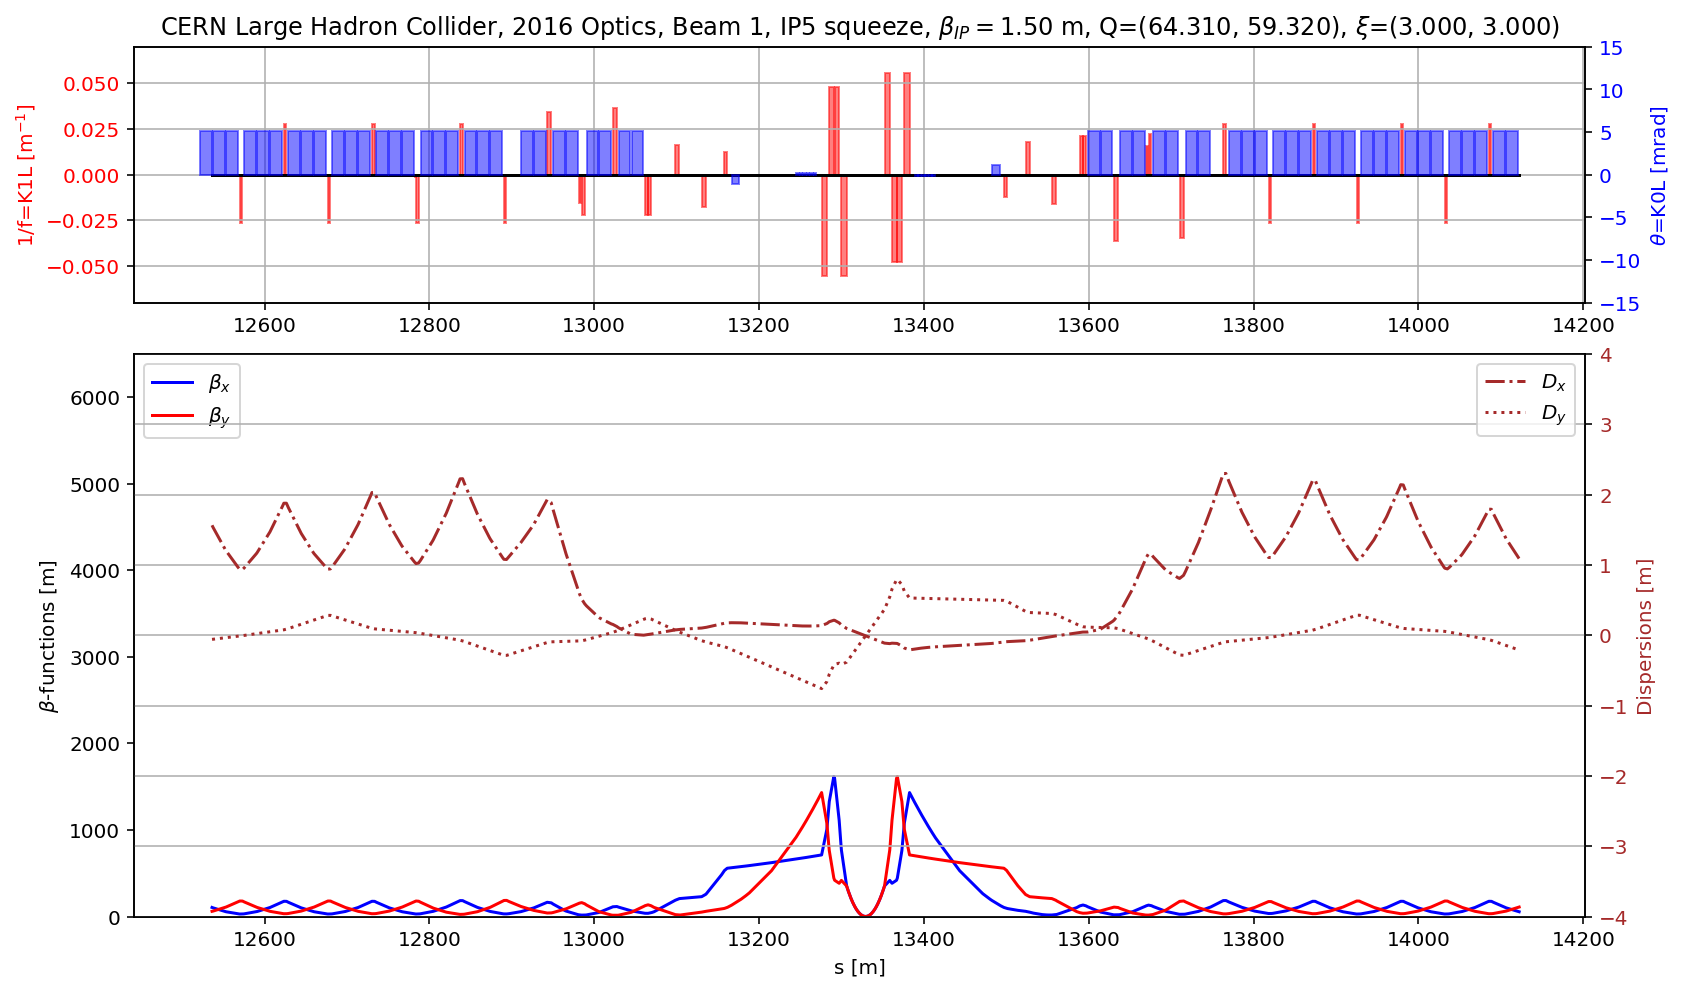

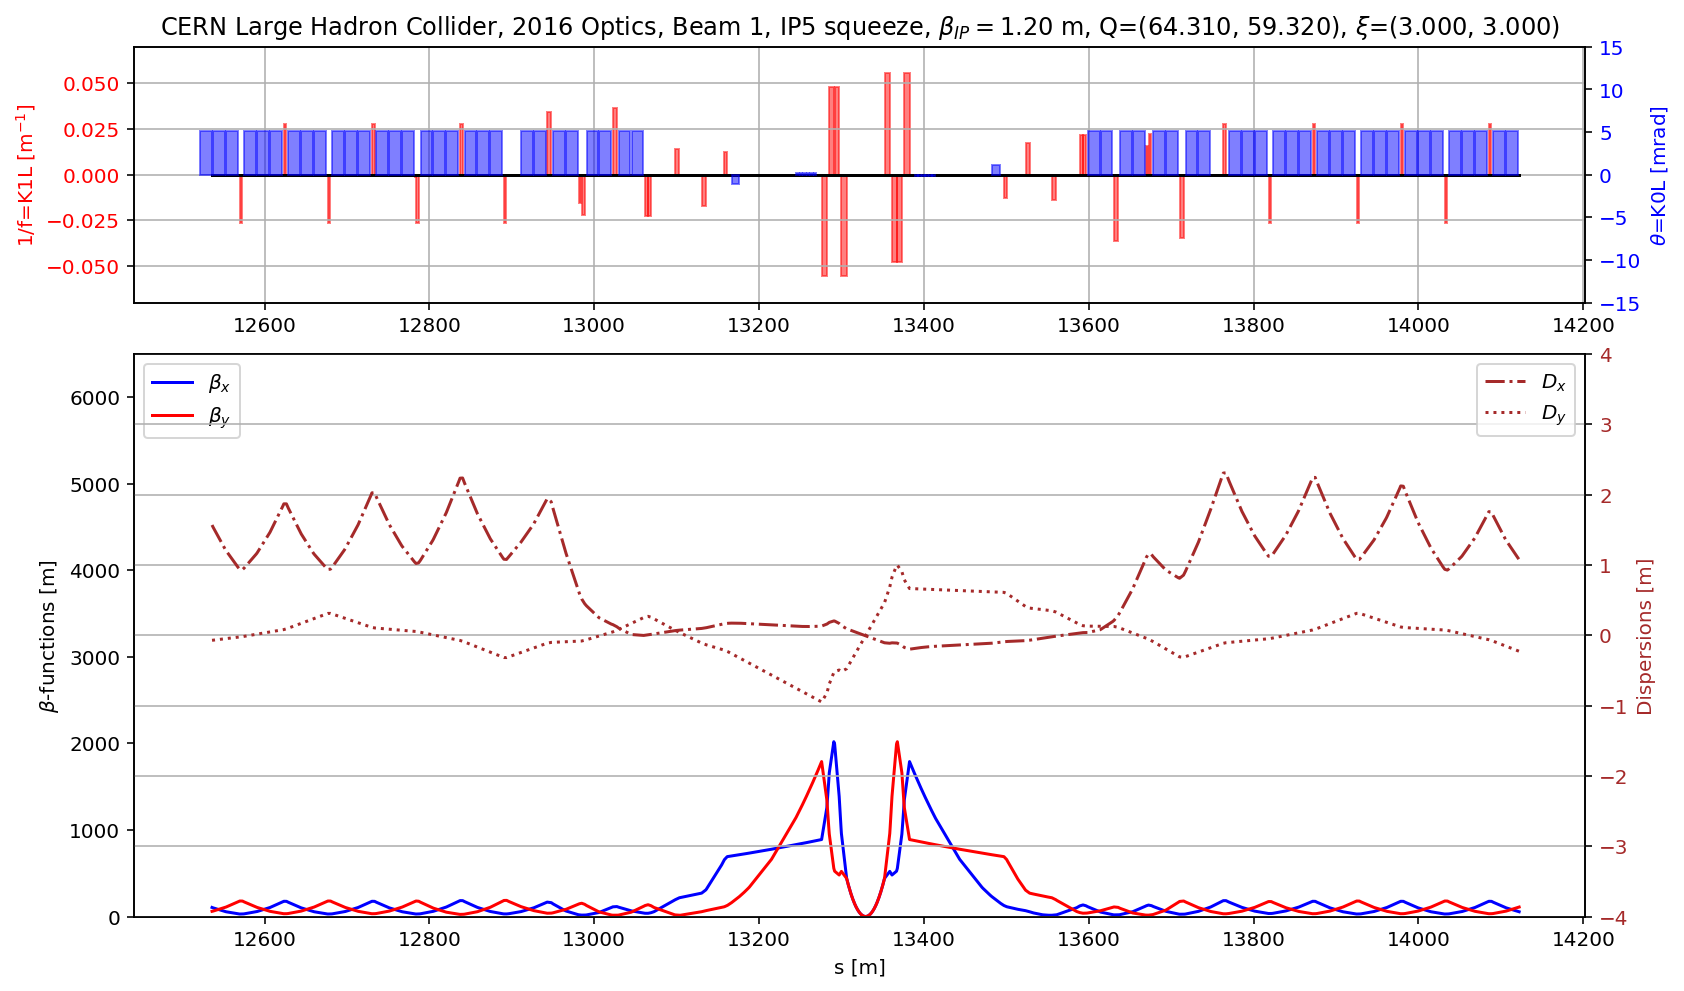

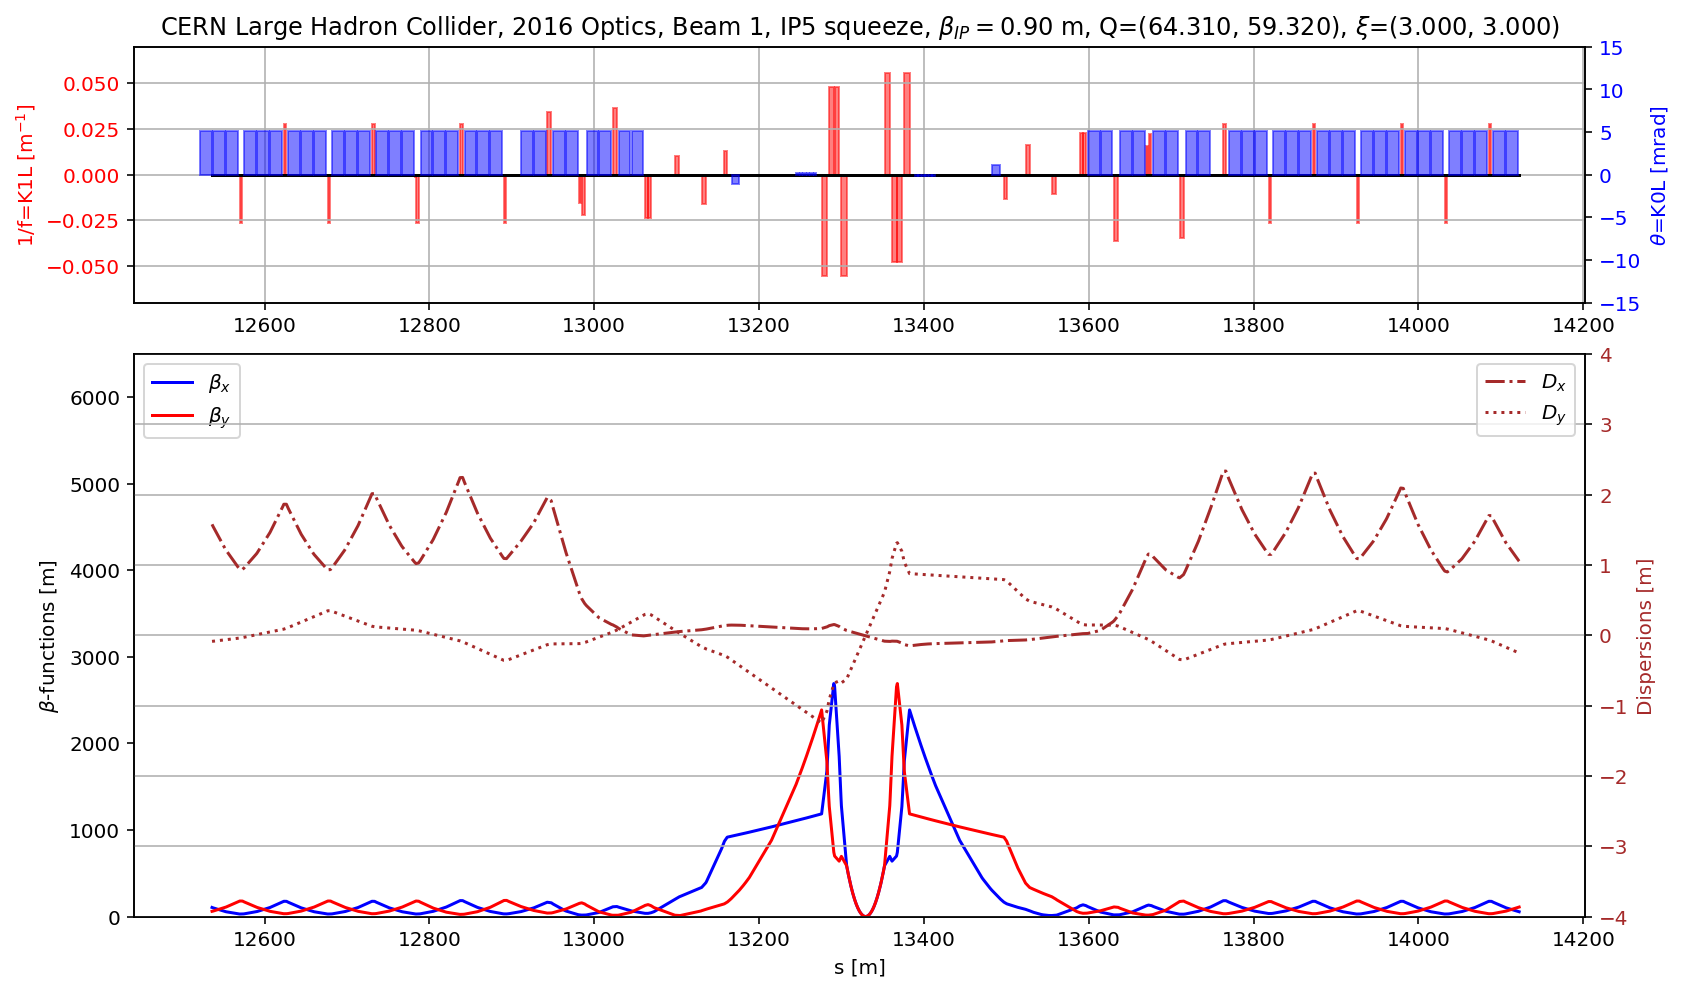

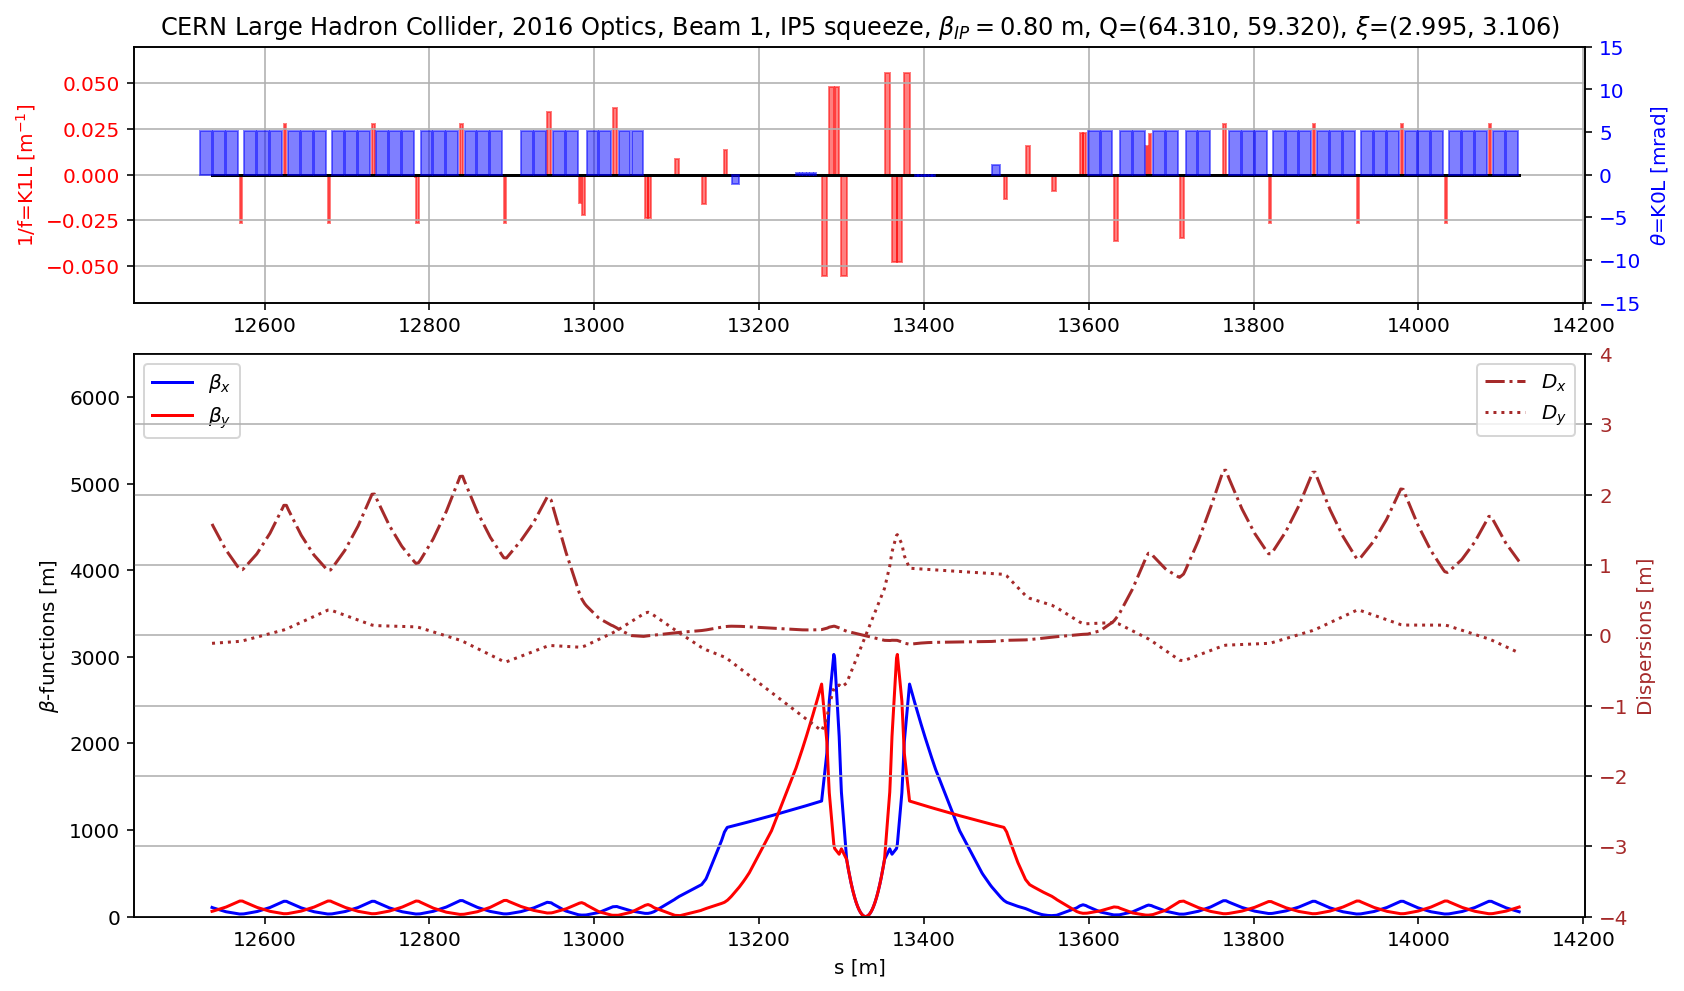

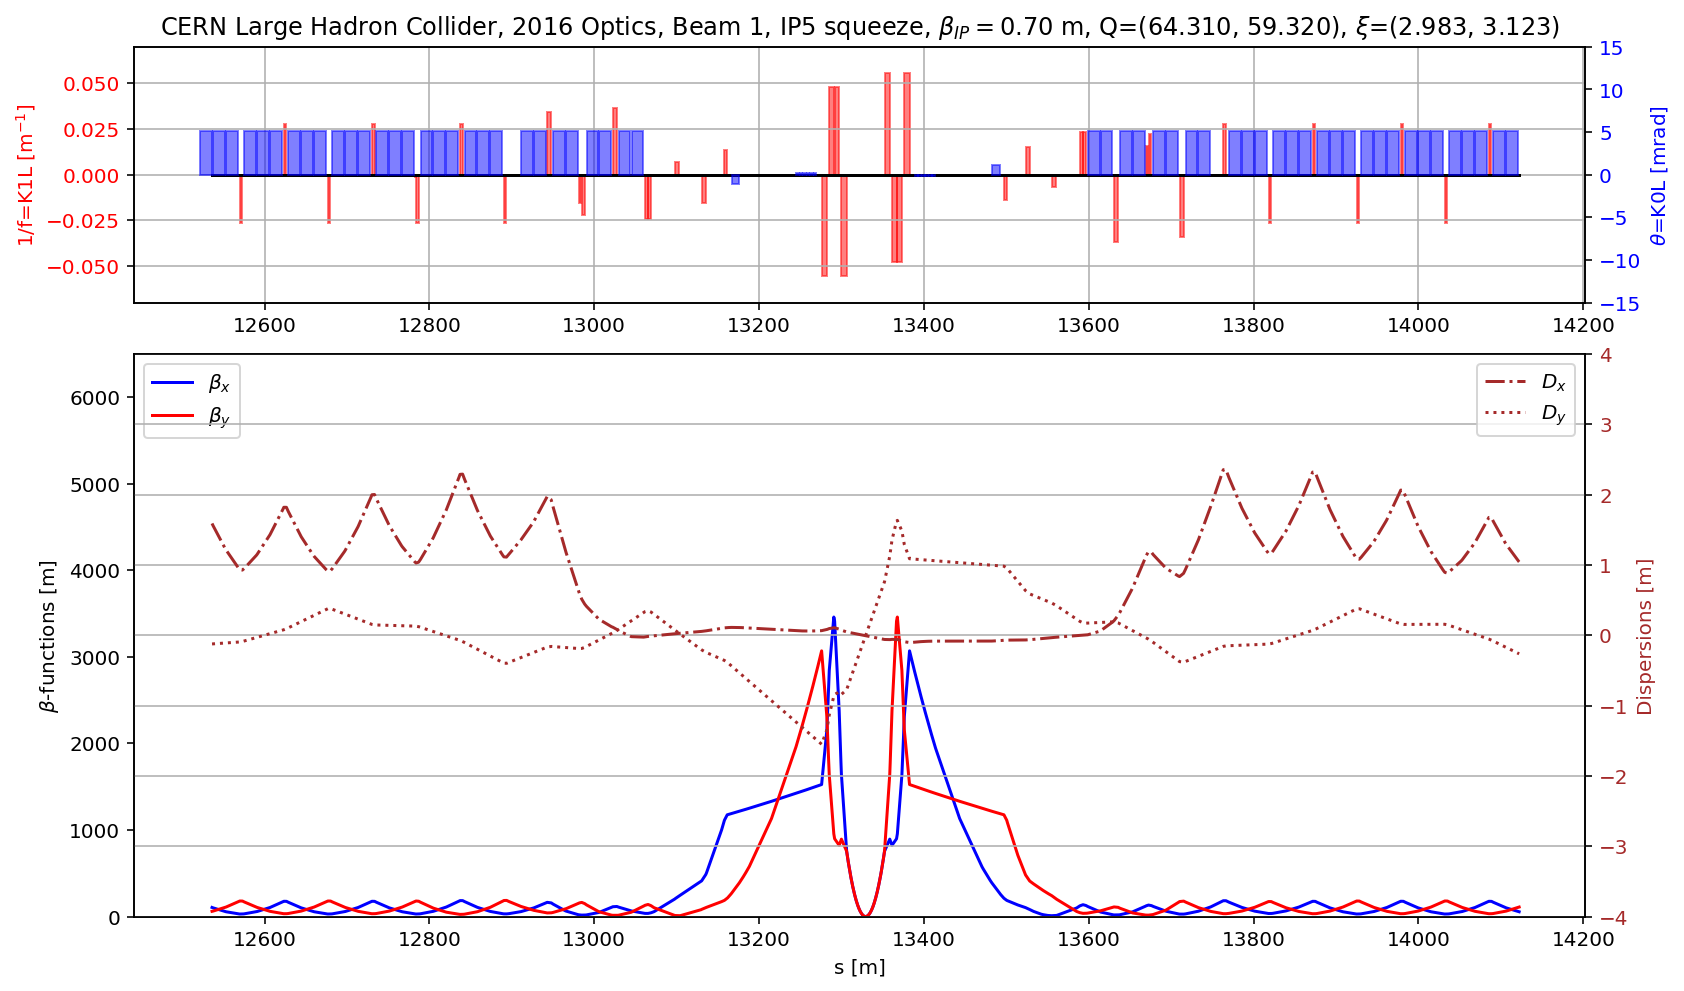

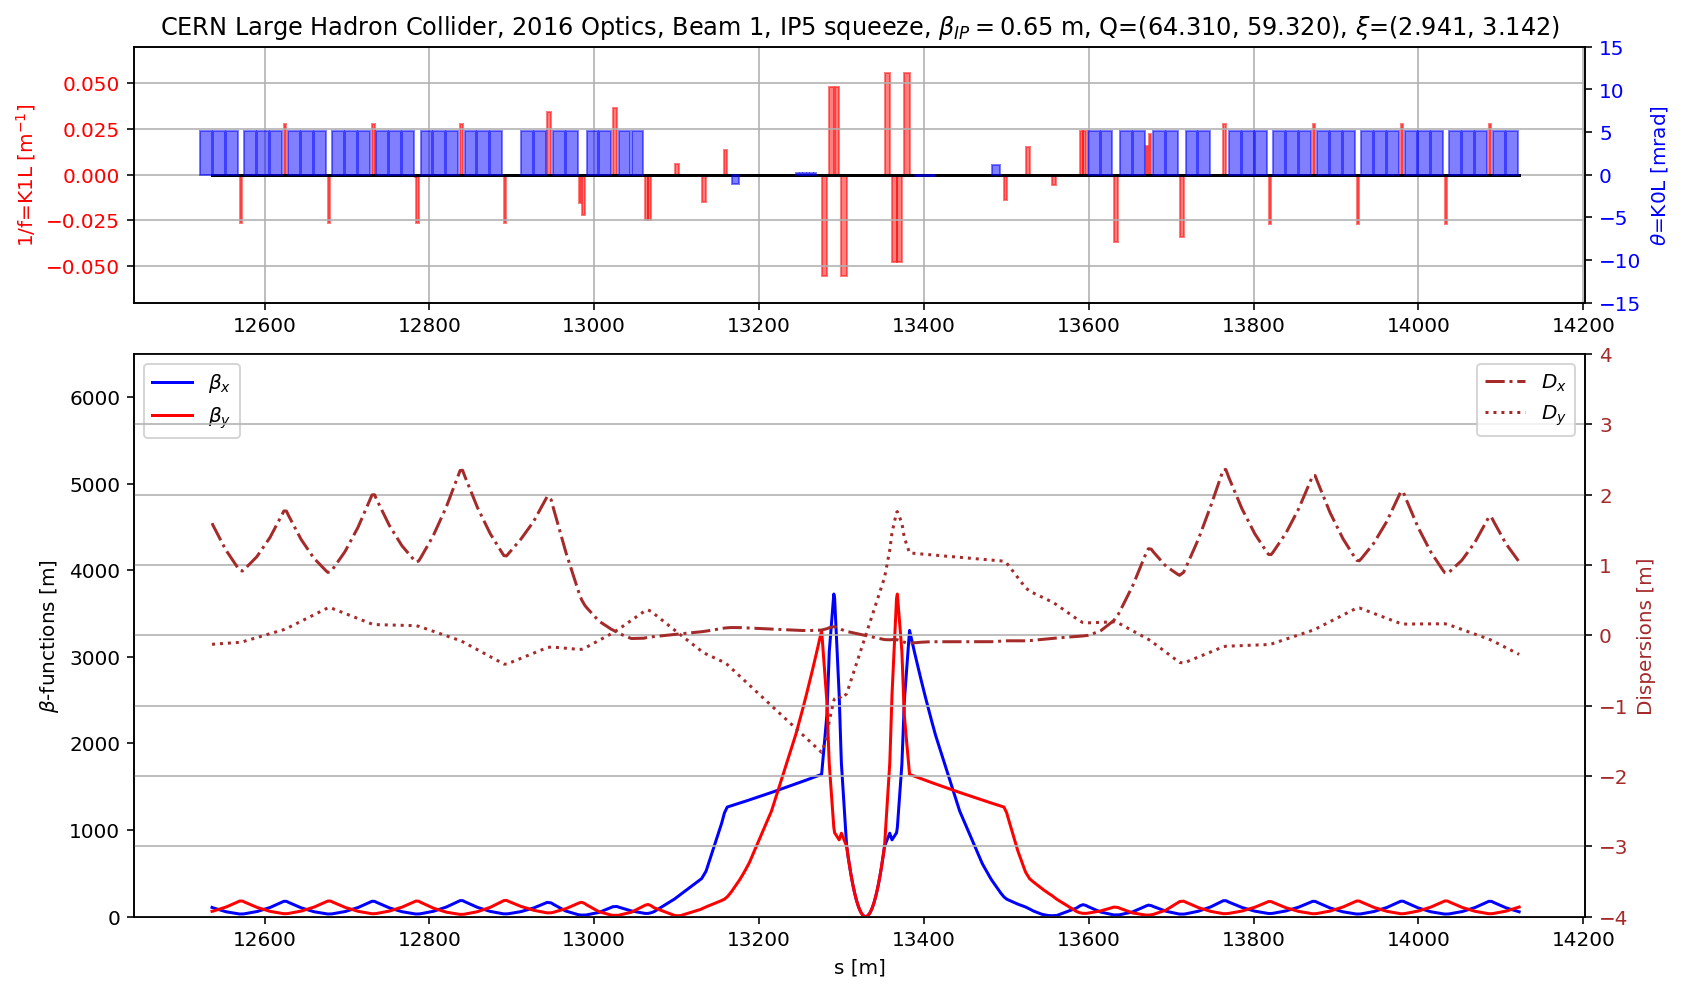

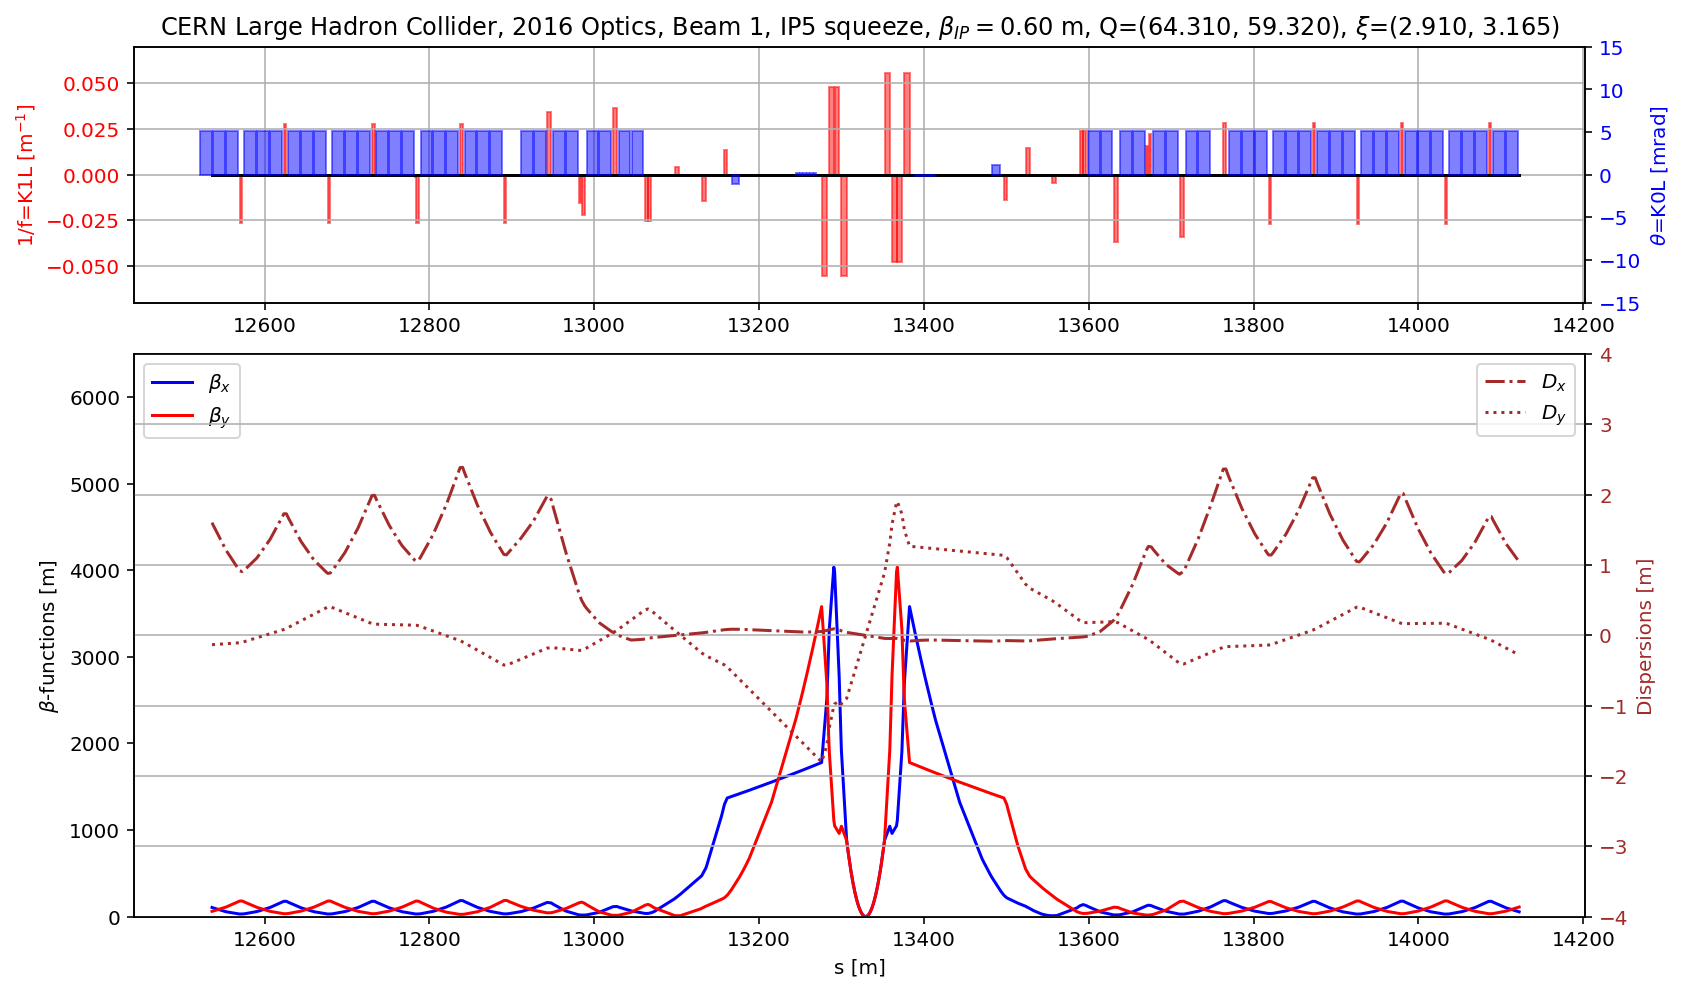

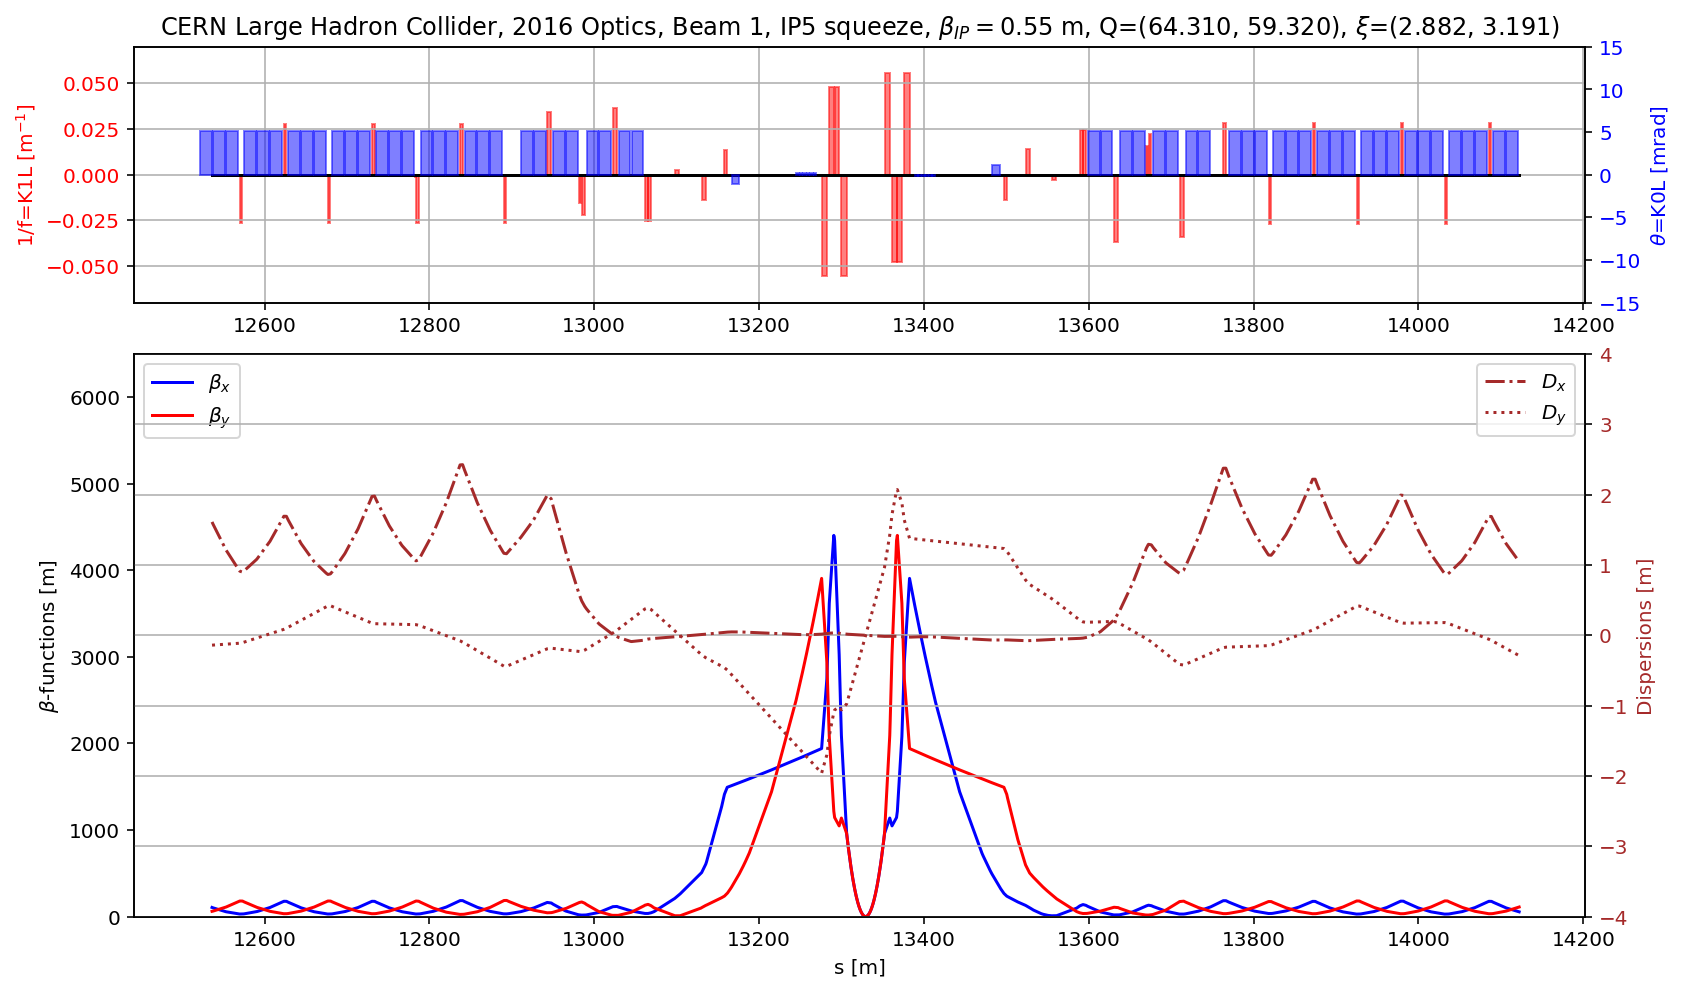

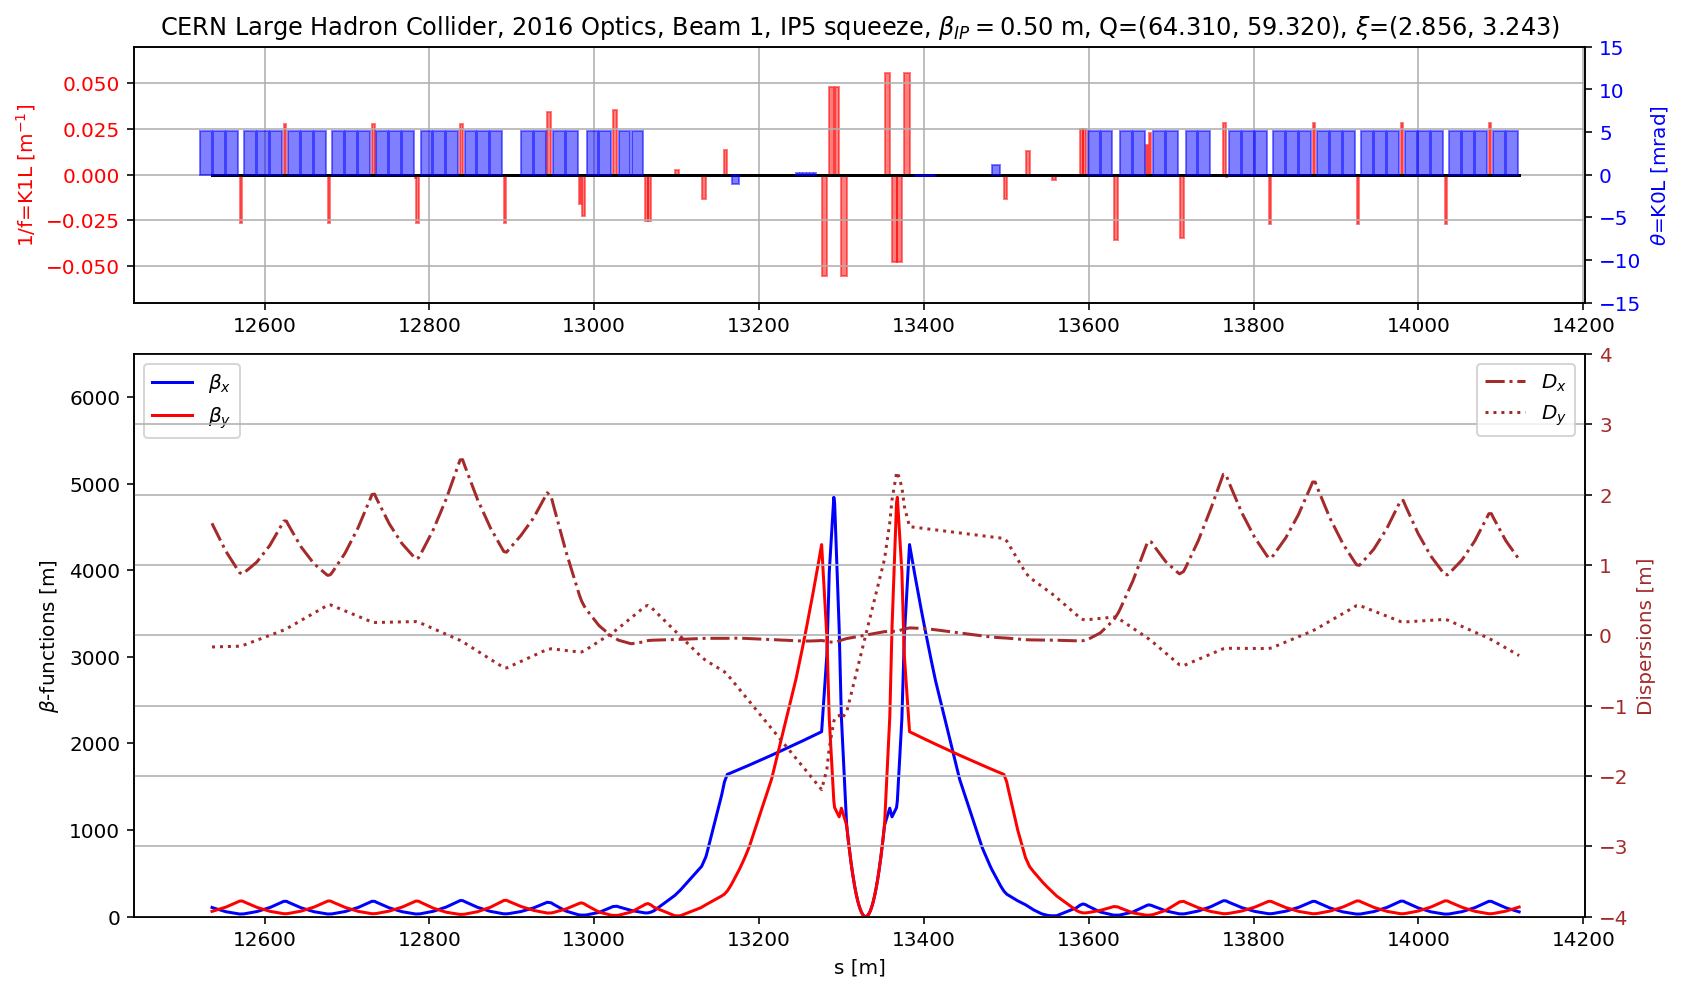

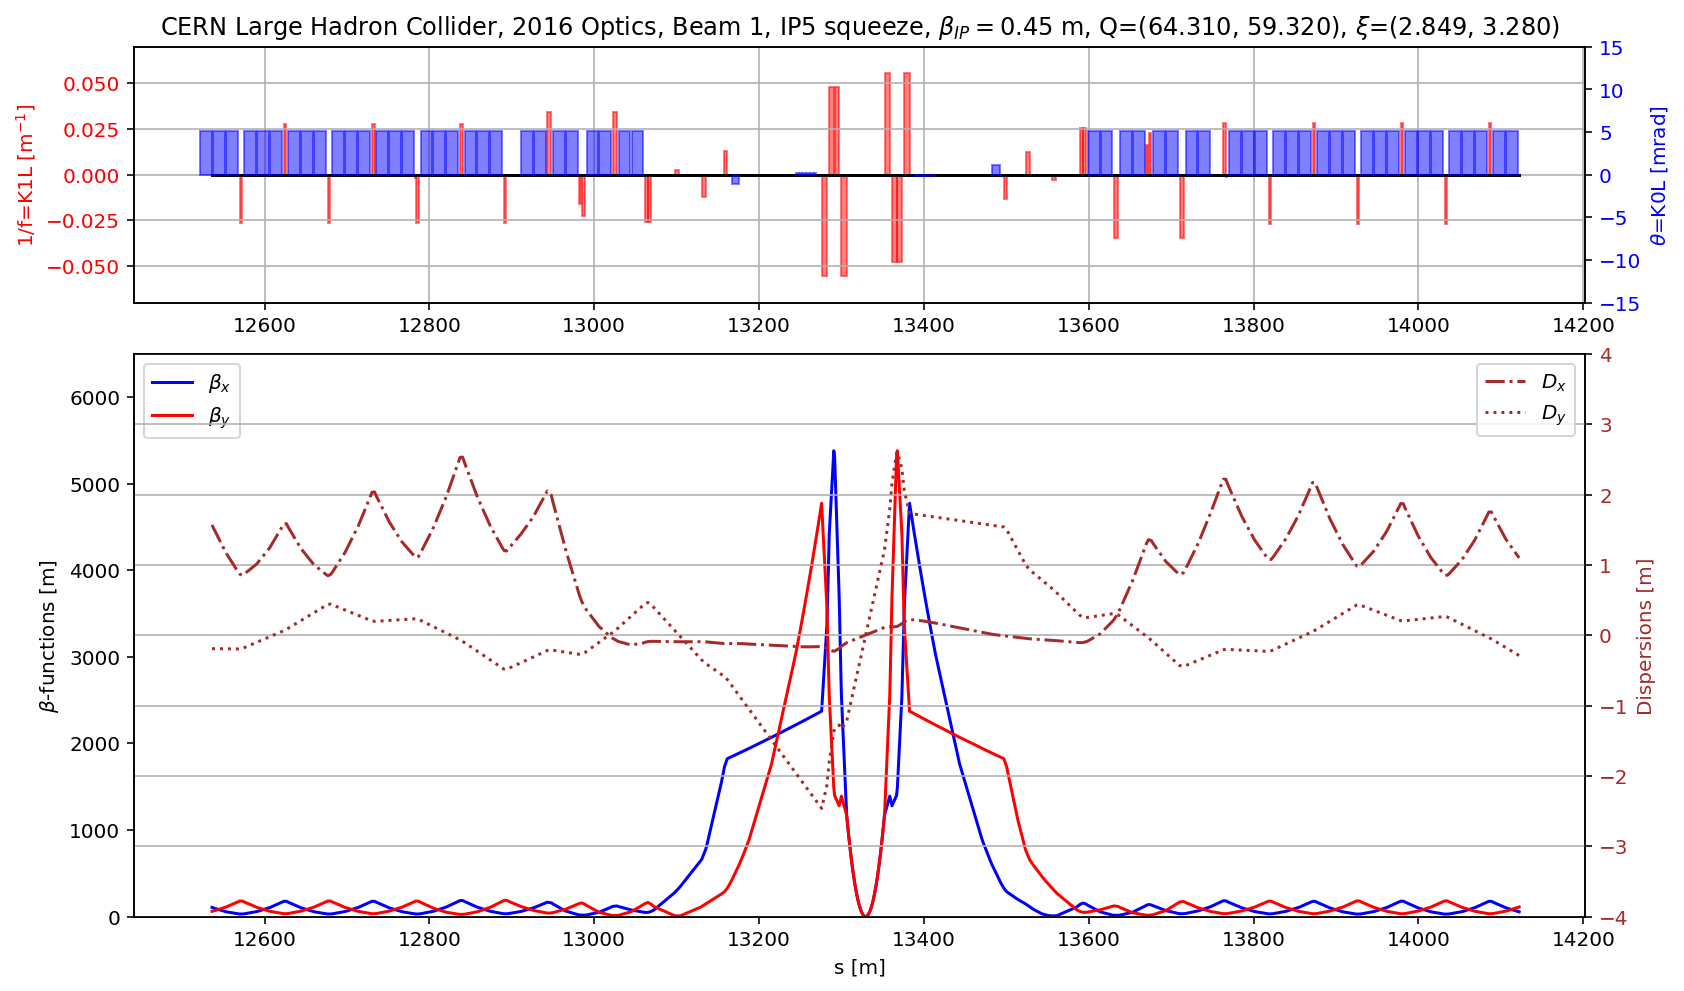

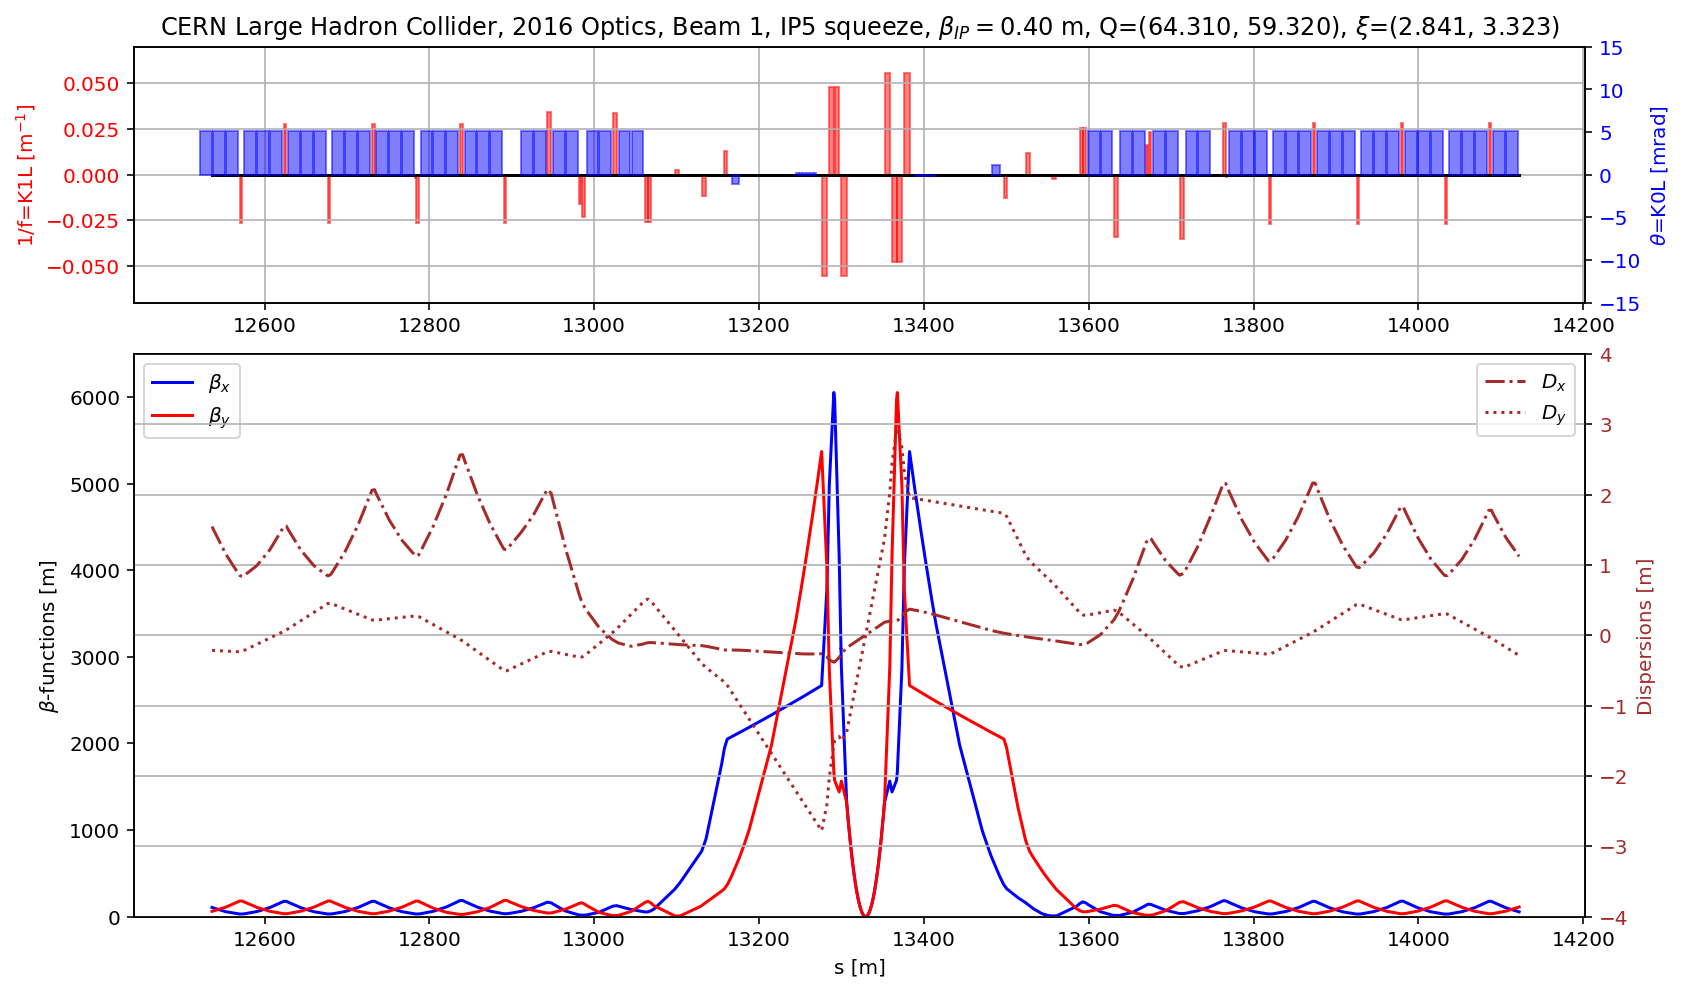

In [4]:
myOpticsList=[
'opt_11000_10000_11000_10000.madx',
'opt_9000_10000_9000_9000.madx',
'opt_7000_10000_7000_8000.madx',
'opt_4000_10000_4000_7000.madx',
'opt_3000_10000_3000_6000.madx',
'opt_2500_10000_2500_5000.madx',
'opt_2000_10000_2000_4000.madx',    
'opt_1500_10000_1500_3500.madx',
'opt_1200_10000_1200_3250.madx',
'opt_900_10000_900_3000.madx',
'opt_800_10000_800_3000.madx',
'opt_700_10000_700_3000.madx',
'opt_650_10000_650_3000.madx',
'opt_600_10000_600_3000.madx',
'opt_550_10000_550_3000.madx',
'opt_500_10000_500_3000.madx',
'opt_450_10000_450_3000.madx',
'opt_400_10000_400_3000.madx'
]

for i, j in zip(myOpticsList, range(19)):
    response = requests.get('http://abpdata.web.cern.ch/abpdata/lhc_optics_web/www/opt2016/inj/db5/'+i)
    data = response.text
    madx.input(data);
    
    madx.input(
    '''
    use, sequence=lhcb1;
    twiss;
    ''');
    myTwiss=madx.table.twiss.dframe()
    myTwiss=myTwiss[(myTwiss['s']>(13329.289233-800)) & (myTwiss['s']<(13329.289233+800))]
    #display(myTwiss[myTwiss['name'].str.contains('ip5')])
    
    fig = plt.figure(figsize=(13,8))

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.07,.07)
#    plt.title('CERN Large Hadron Collider, 2016 Optics, Beam 1, IP5 squeeze, $\\beta_{IP}=$'+format(myTwiss[myTwiss['name'].str.contains('ip5')]['betx'].values[0],'2.2f')+' m,Q=('+format(madx.table.summ.Q1[0],'2.3f')+', '+ format(madx.table.summ.Q2[0],'2.3f')+'), $1$=('+format(madx.table.summ.DQ1[0],'2.3f')+', '+ format(madx.table.summ.DQ2[0],'2.3f')+')')
    plt.title('CERN Large Hadron Collider, 2016 Optics, Beam 1, IP5 squeeze, $\\beta_{IP}=$'+format(myTwiss[myTwiss['name'].str.contains('ip5')]['betx'].values[0],'2.2f')+' m, Q=('+format(madx.table.summ.Q1[0],'2.3f')+', '+ format(madx.table.summ.Q2[0],'2.3f')+'), $\\xi$=('+format(madx.table.summ.DQ1[0],'2.3f')+', '+ format(madx.table.summ.DQ2[0],'2.3f')+')')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [mrad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle/2*1000, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle/2*1000, color='b')


    plt.ylim(-15,15)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
    plt.legend(loc=2)
    plt.ylabel('$\\beta$-functions [m]')
    plt.xlabel('s [m]')
    plt.ylim(0,6500)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],ls='-.',color='brown', label='$D_x$')
    plt.plot(myTwiss['s'],myTwiss['dy'],ls=':',color='brown', label='$D_y$')
    plt.legend(loc=1)
    ax3.set_ylabel('Dispersions [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    plt.ylim(-4, 4)

    plt.grid()
#    fig.savefig('/cas/images/RegularSqueeze/'+format(j)+'.pdf')

## LHC squeeze 2018 (ATS)

In [57]:
# import elements, sequence and strengths
madx = Madx(stdout=False)
response = requests.get('http://lhc-optics.web.cern.ch/lhc-optics/runII/2018/lhc_as-built.seq')
data = response.text
madx.input(data);

    
response = requests.get('http://lhc-optics.web.cern.ch/lhc-optics/runII/2018/PROTON/opticsfile.1')
data = response.text
madx.input(data);

In [58]:
madx.input(
'''
beam, sequence=lhcb1, bv= 1,
  particle=proton, charge=1, mass=0.938272046,
  energy= 450,   npart=1.2e11,kbunch=2076,
  ex=5.2126224777777785e-09,ey=5.2126224777777785e-09;

seqedit, sequence=lhcb1;
flatten;
cycle, start=ip1;
flatten;
endedit;
''');

/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


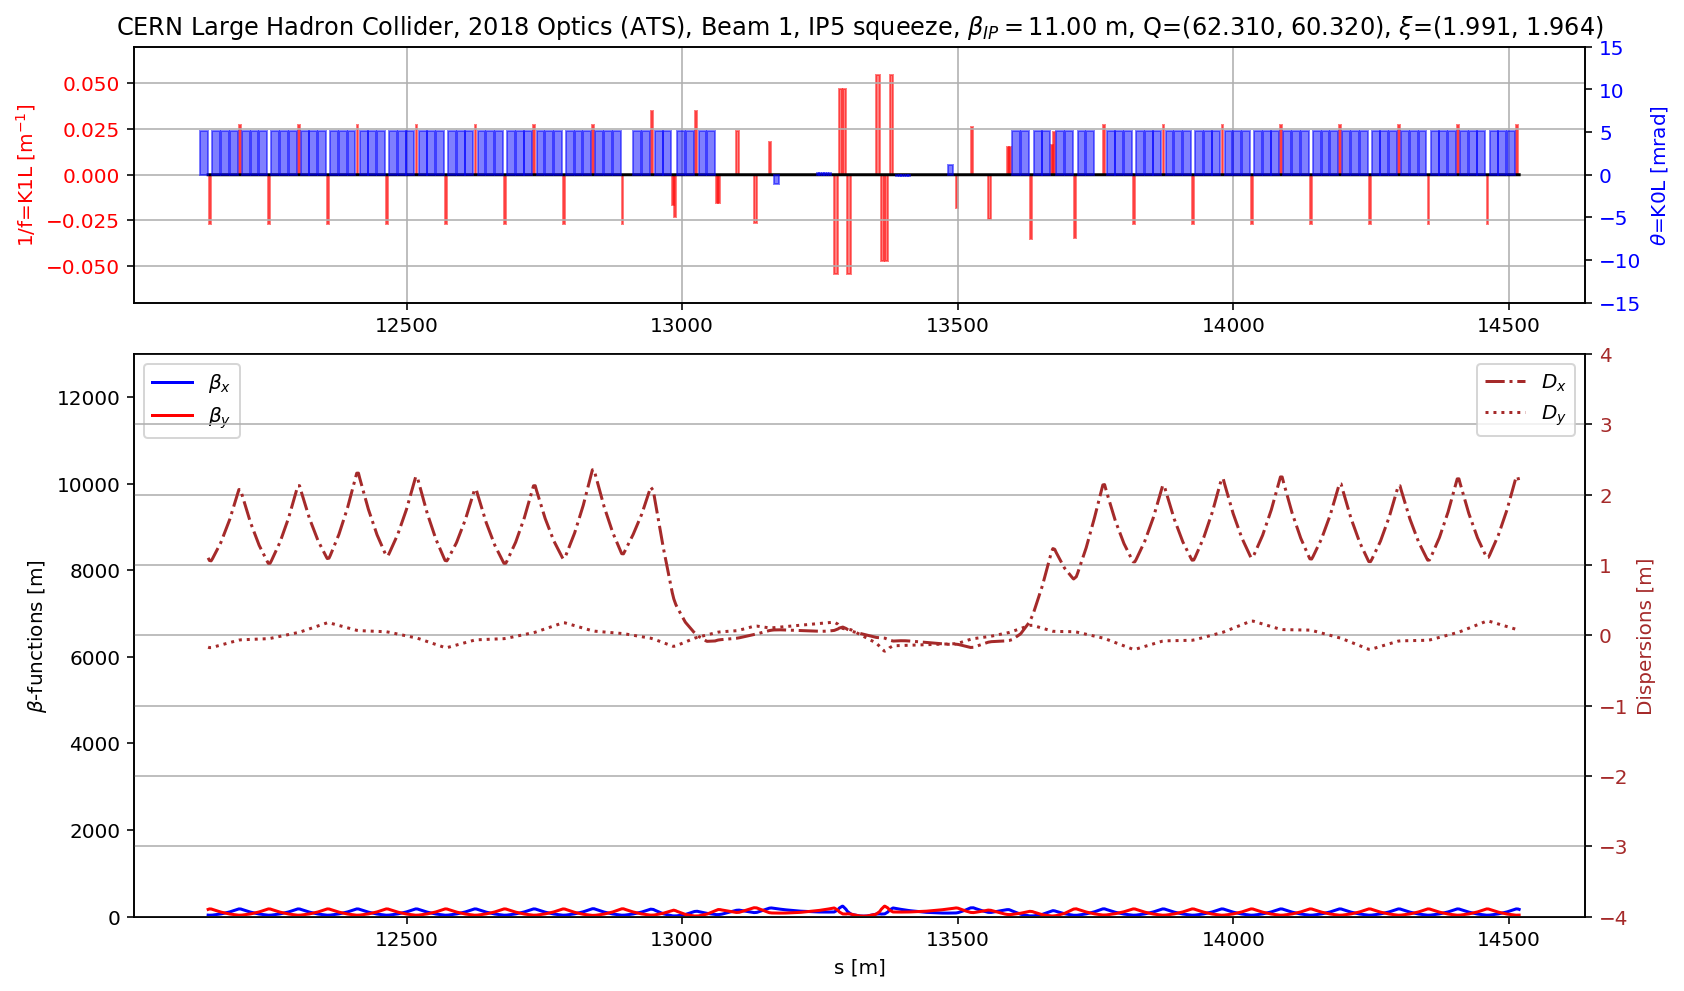

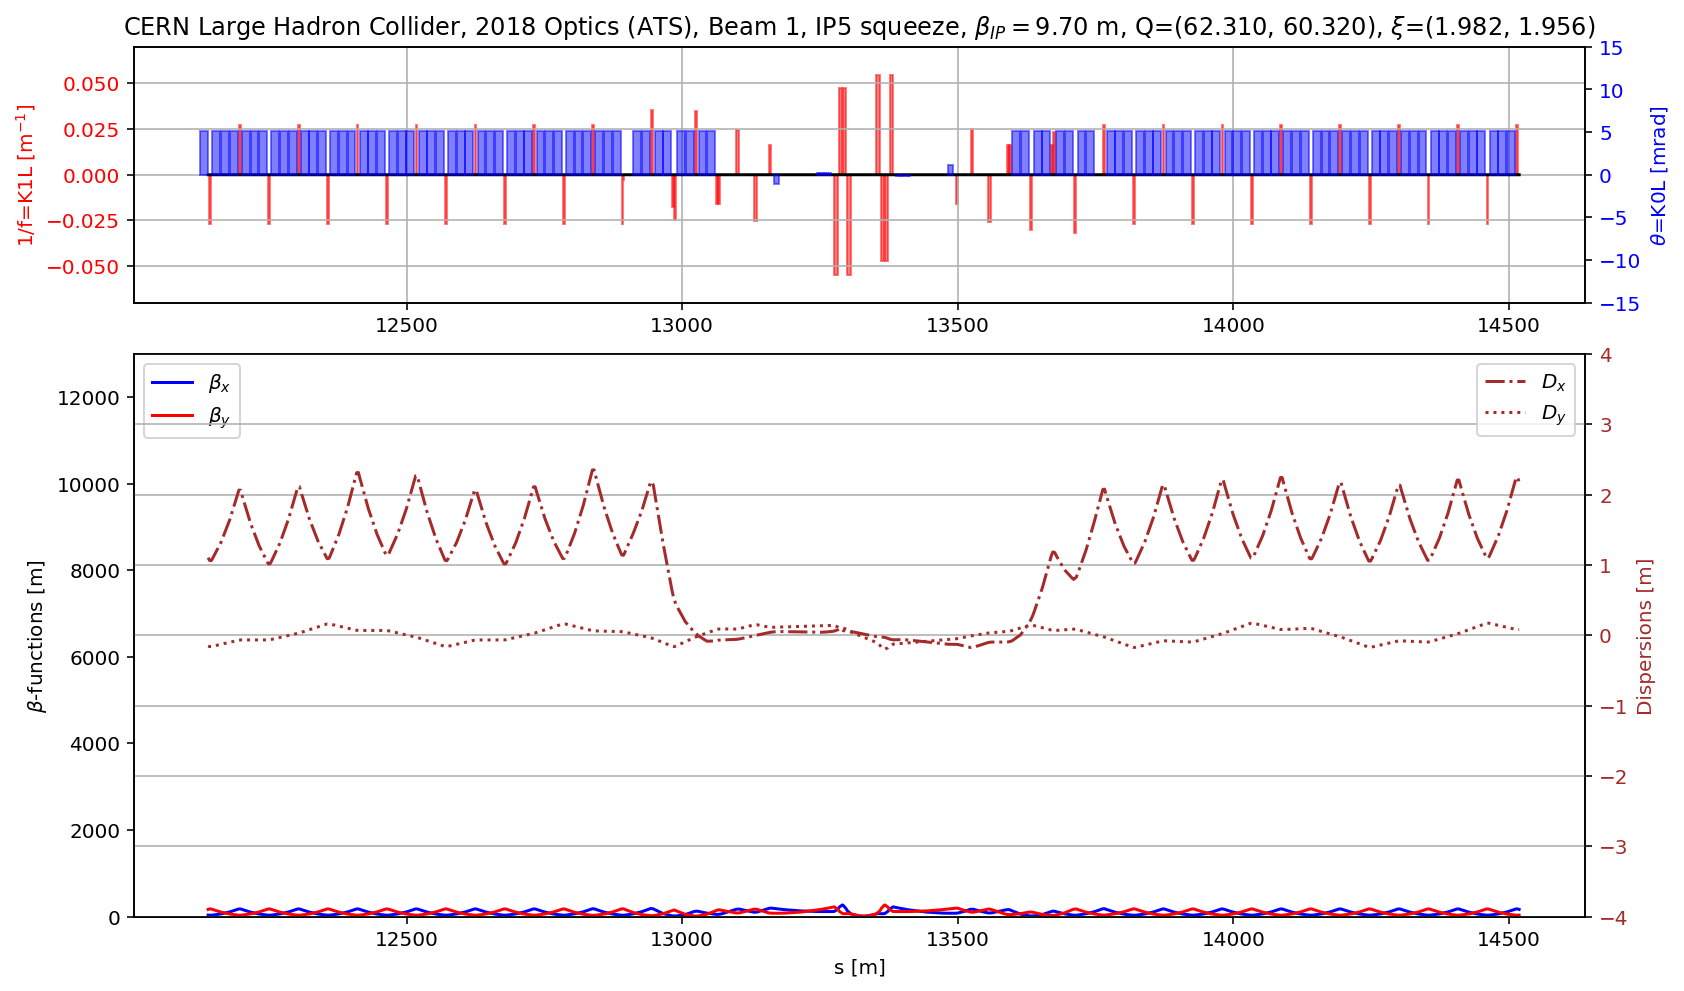

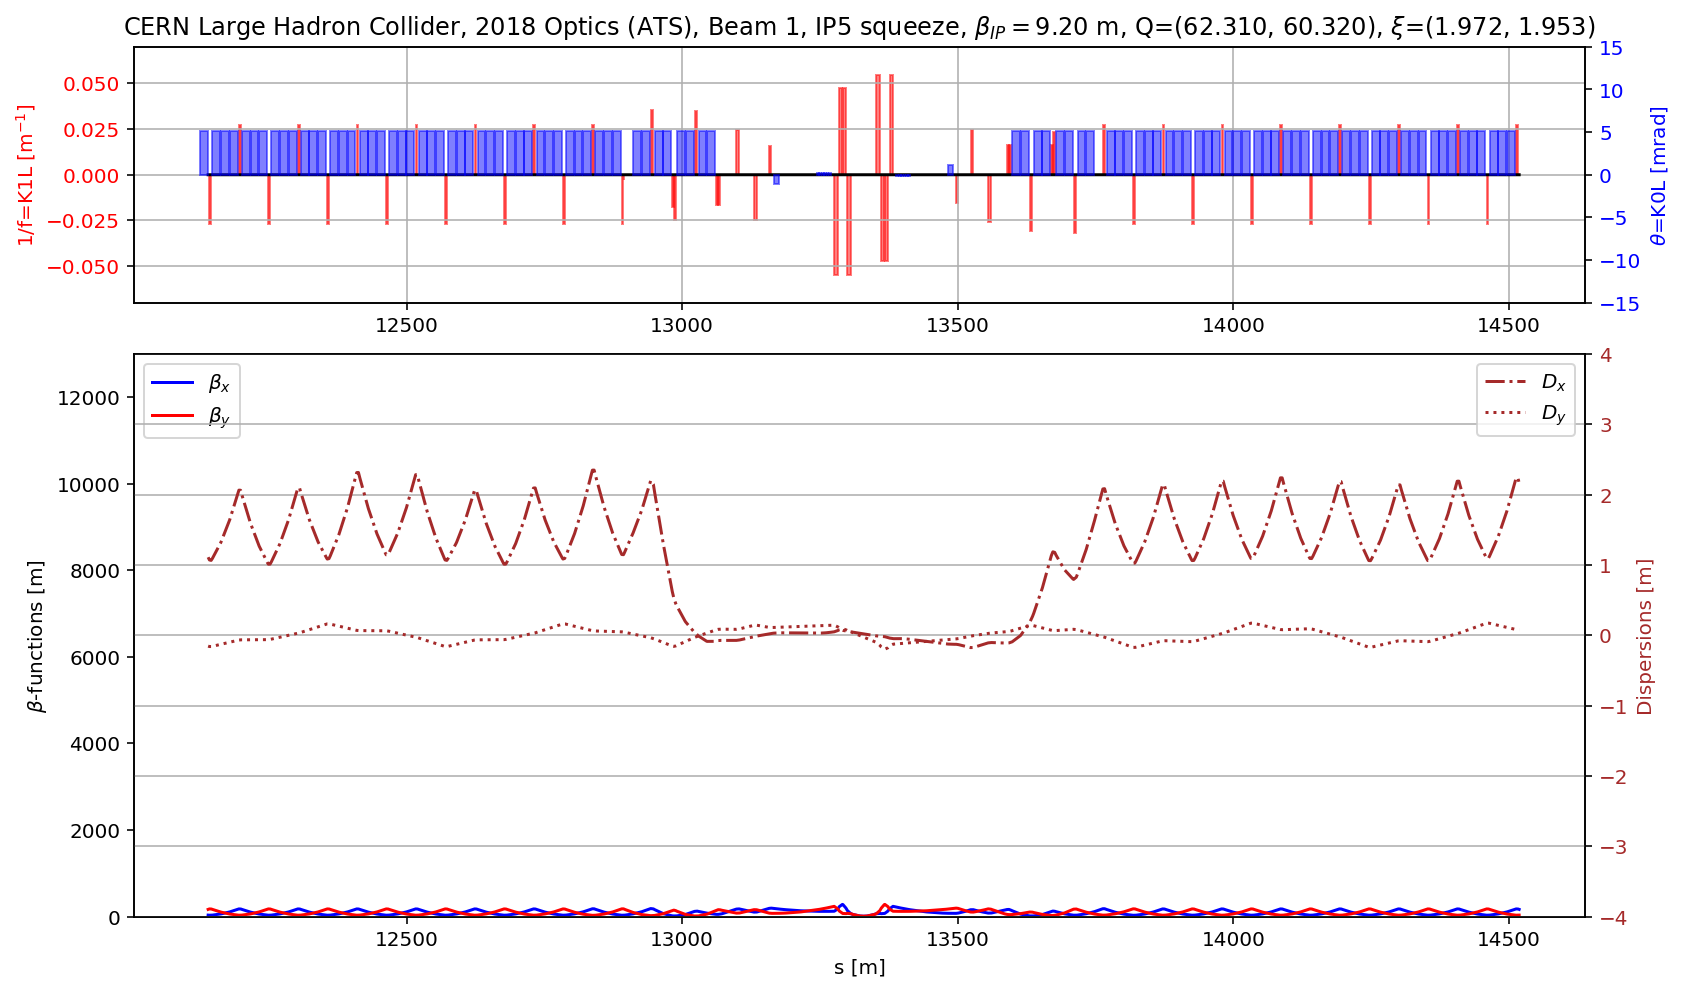

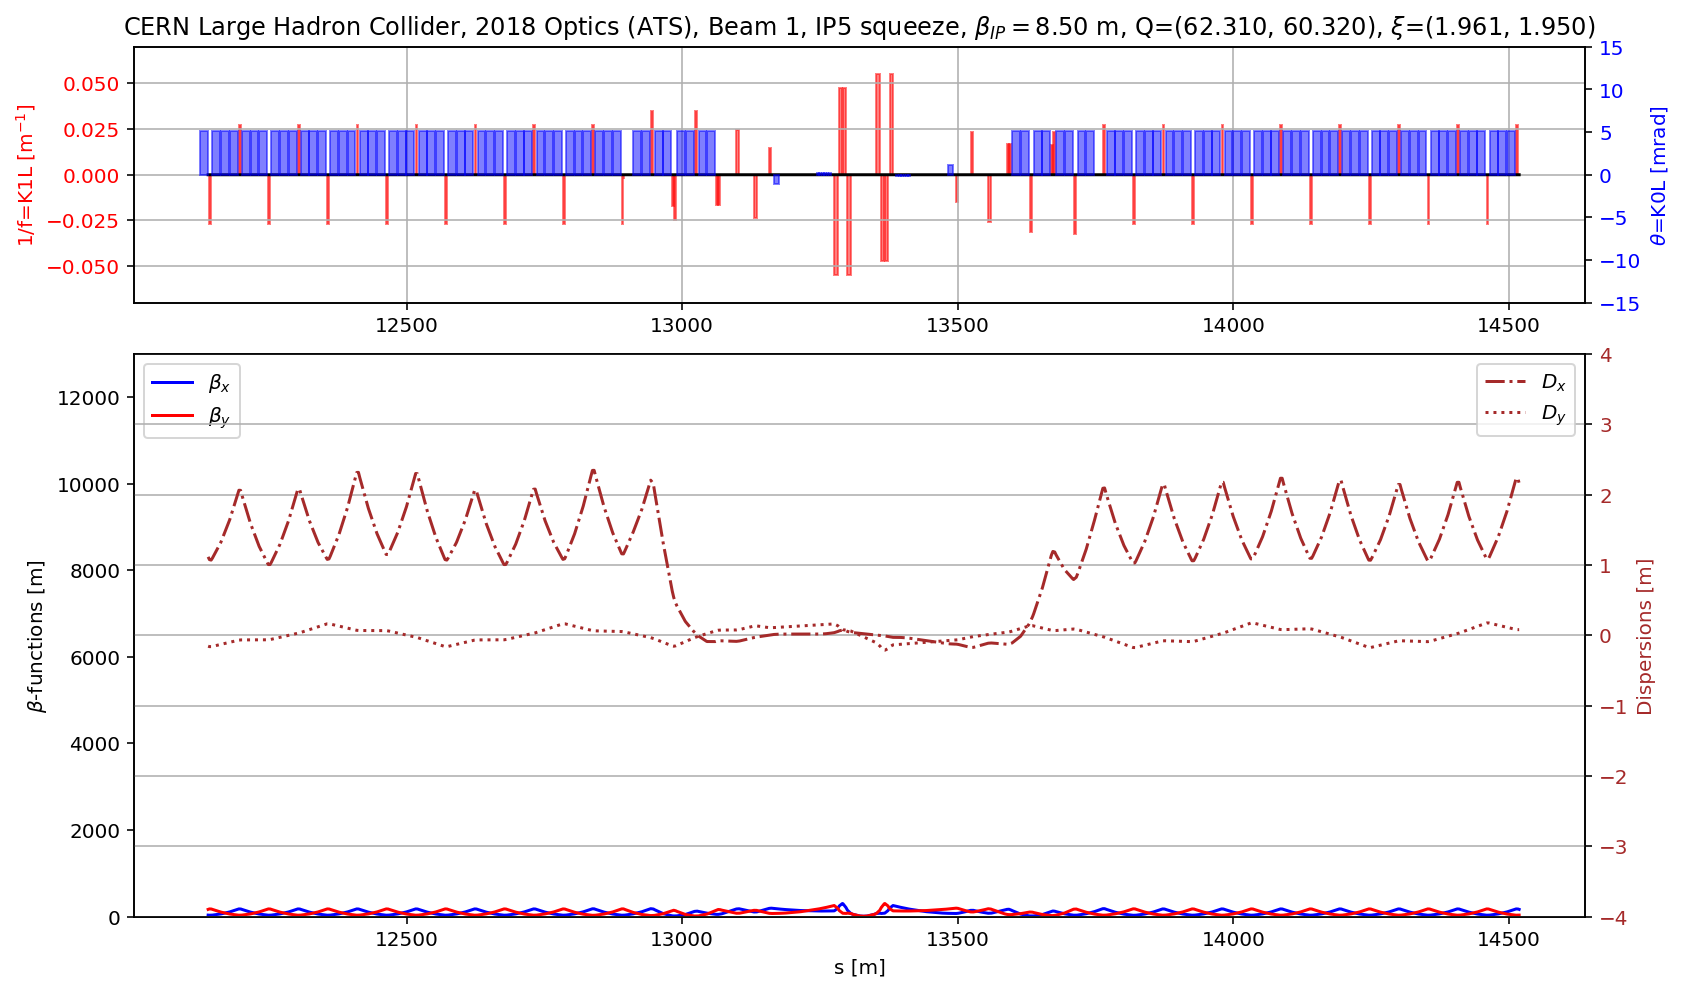

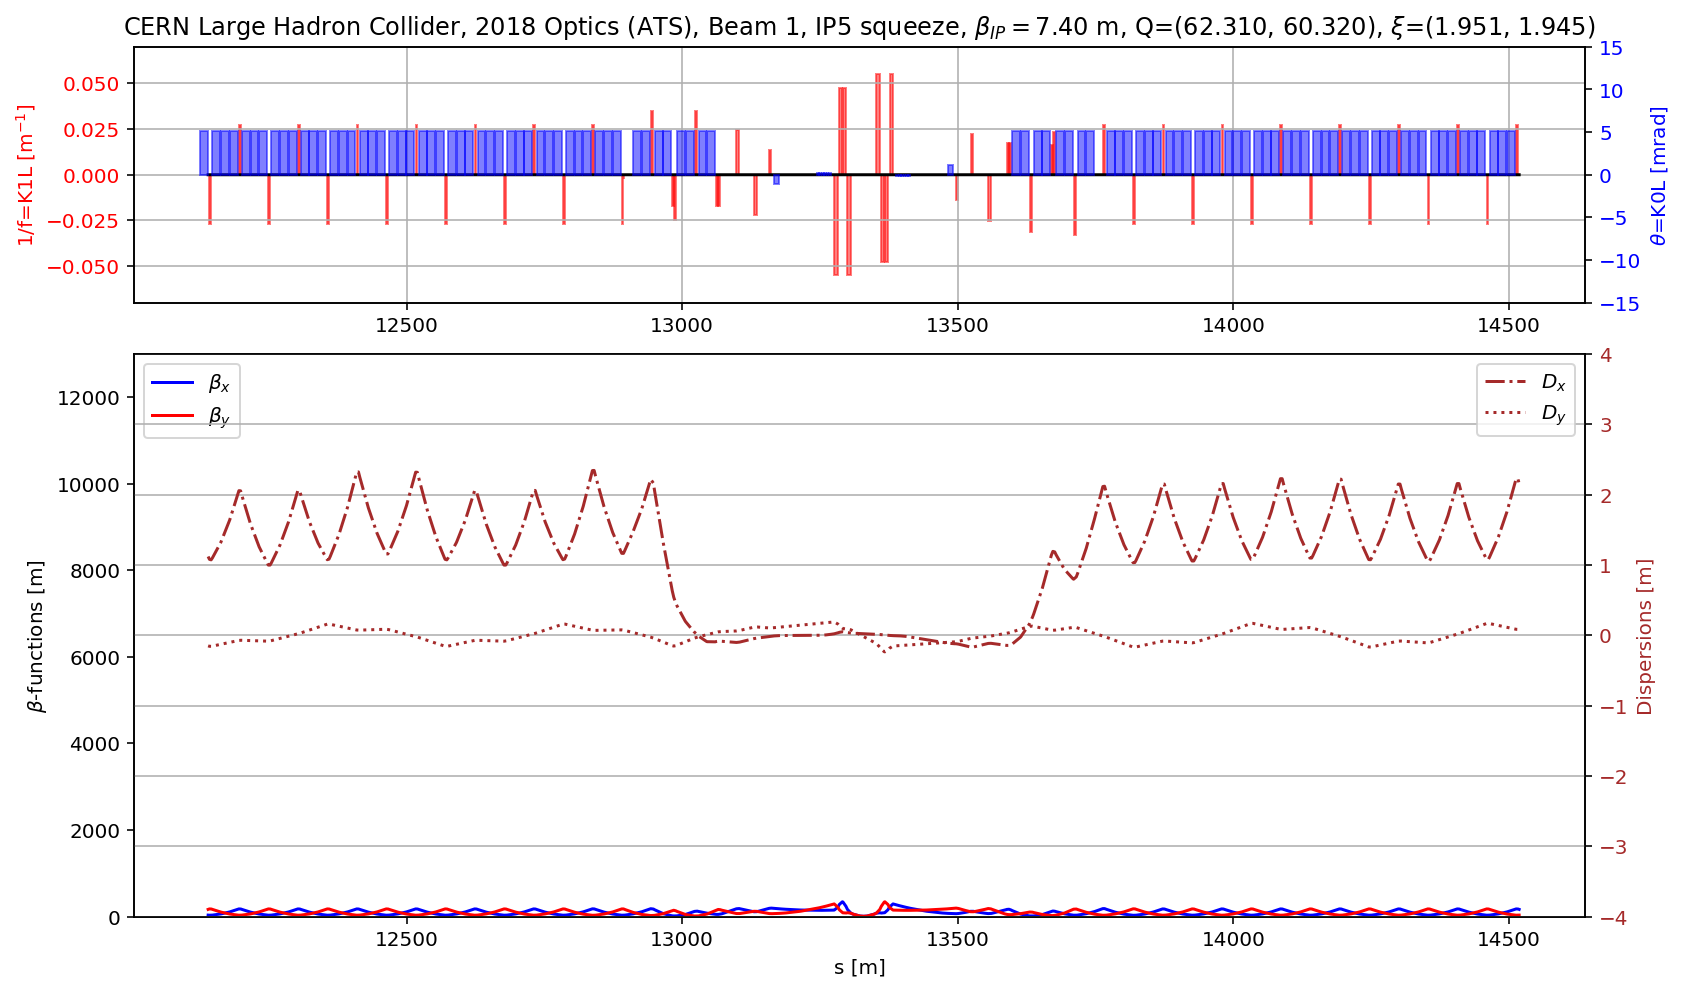

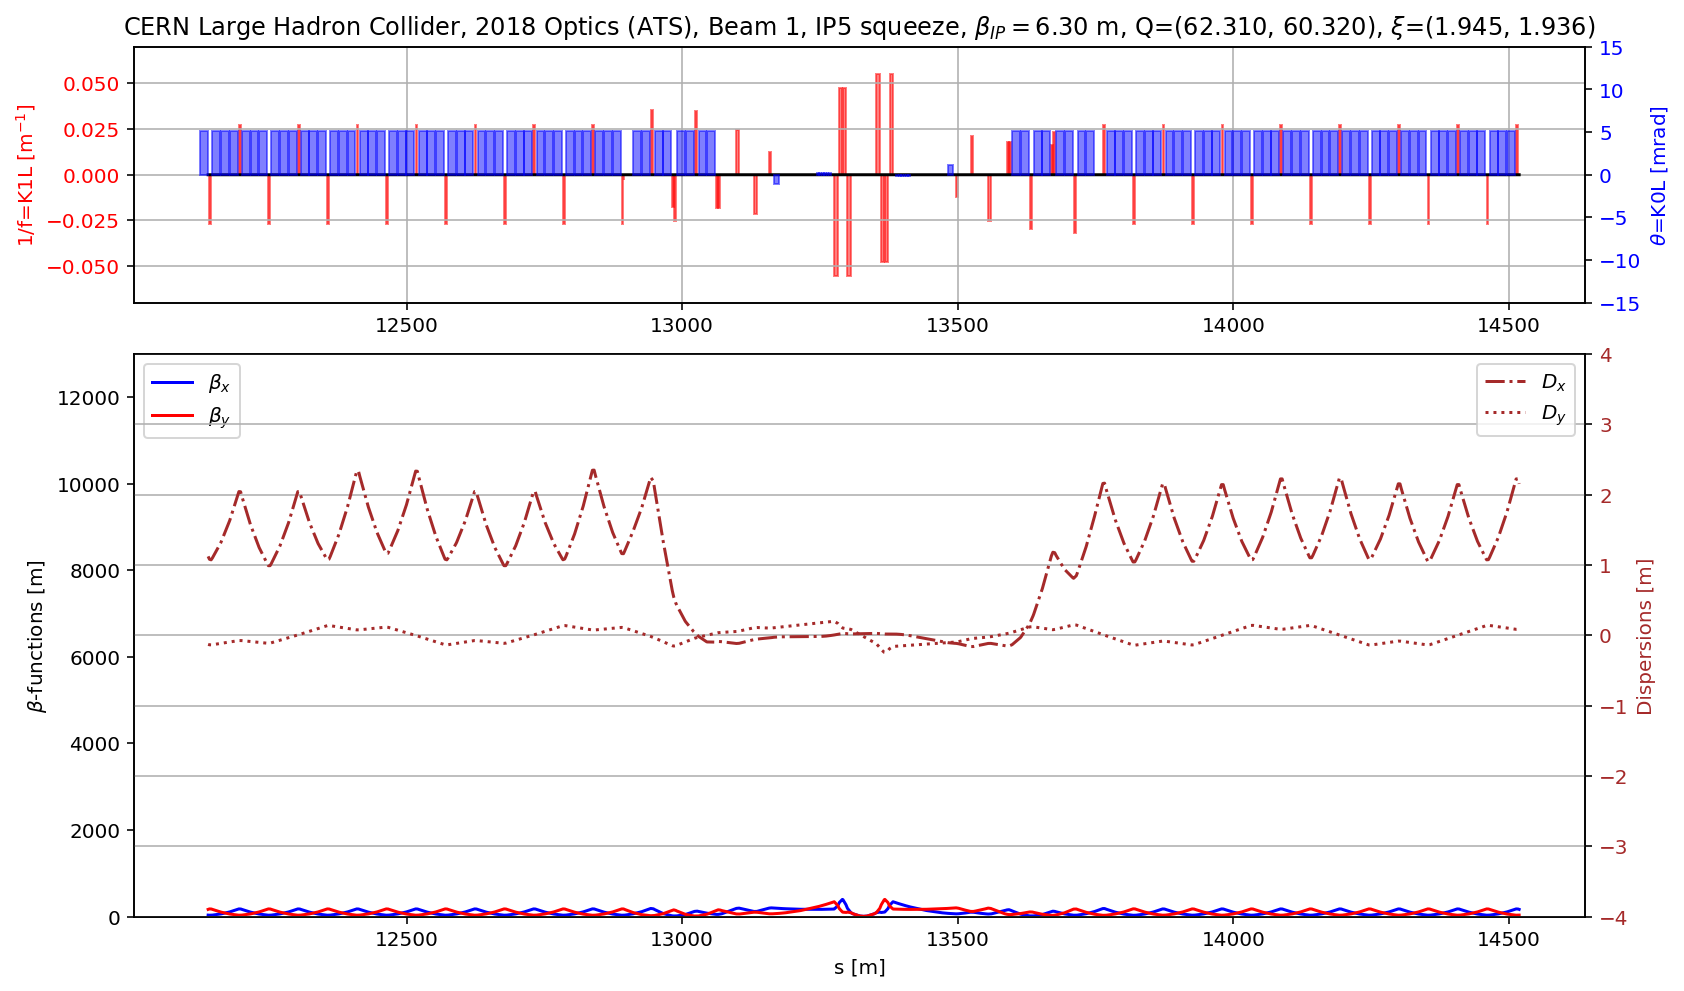

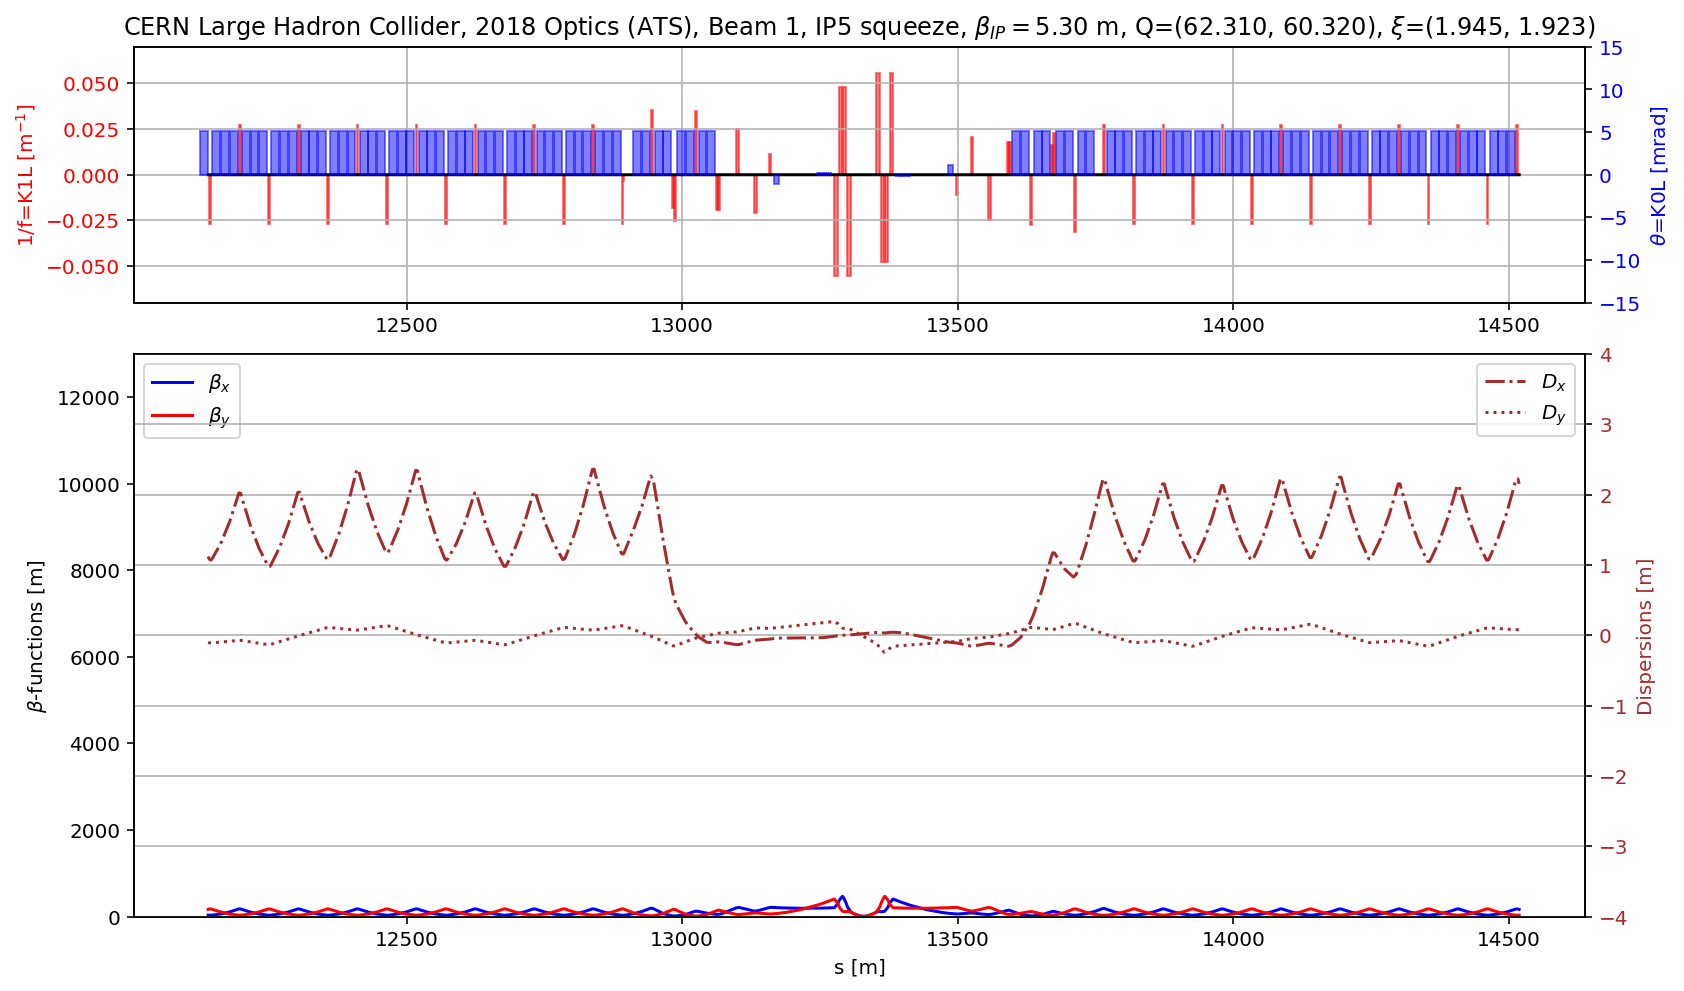

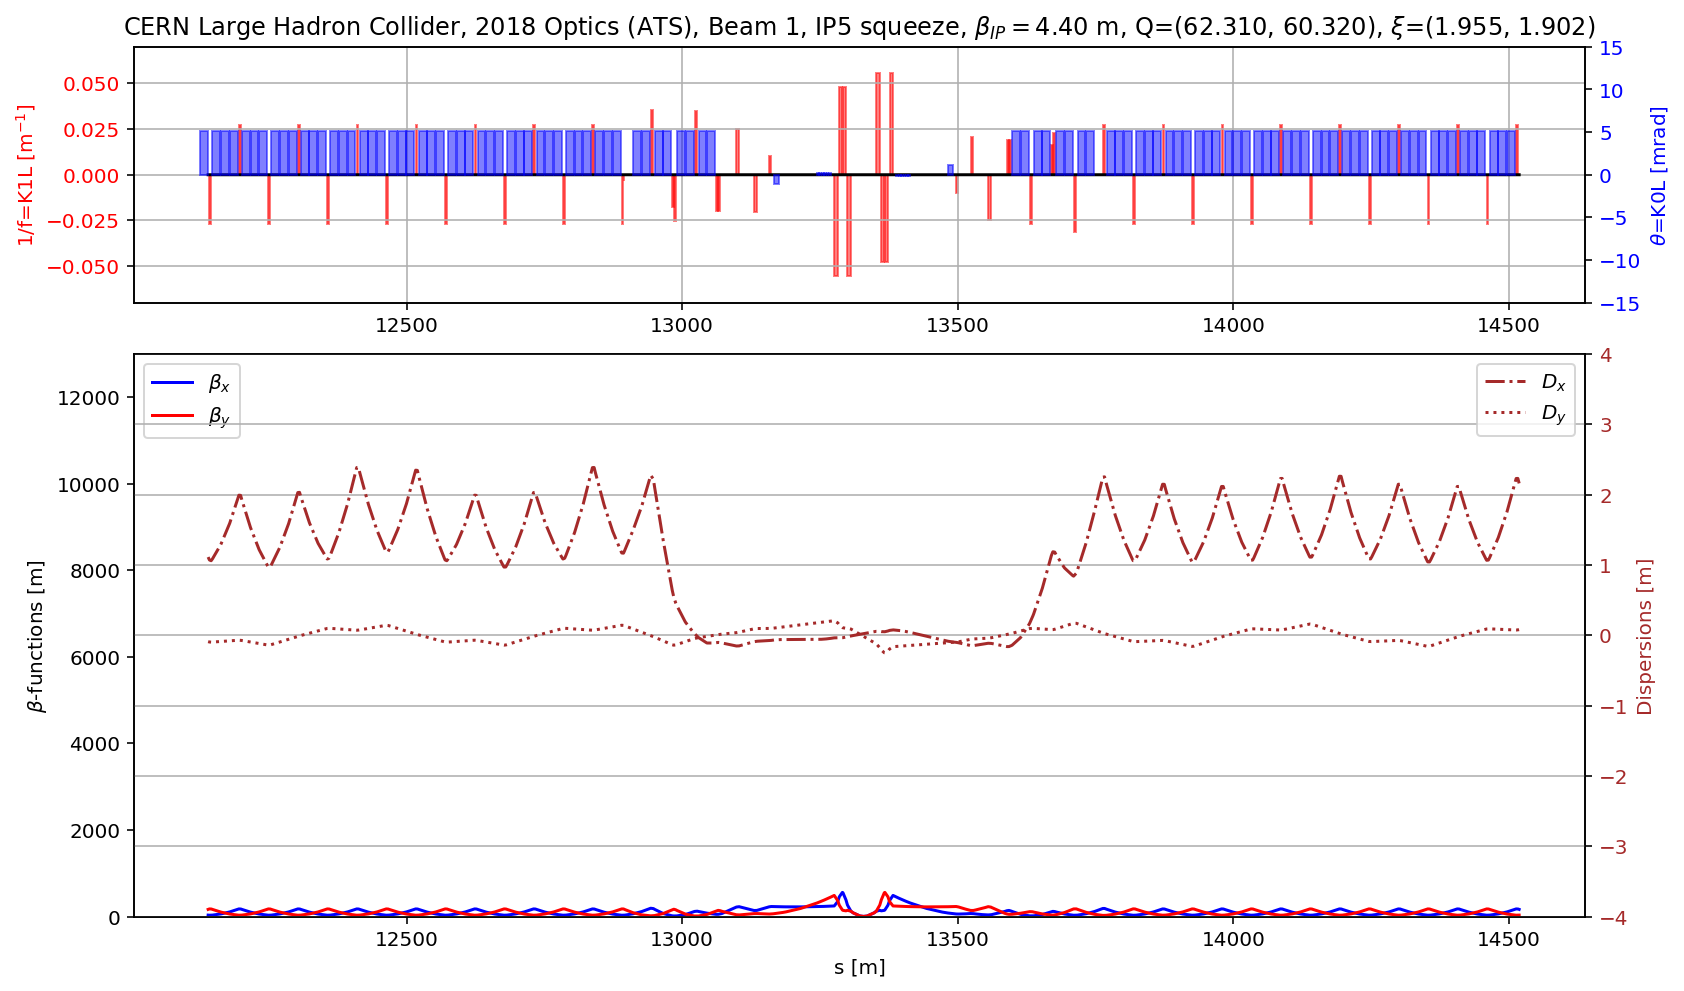

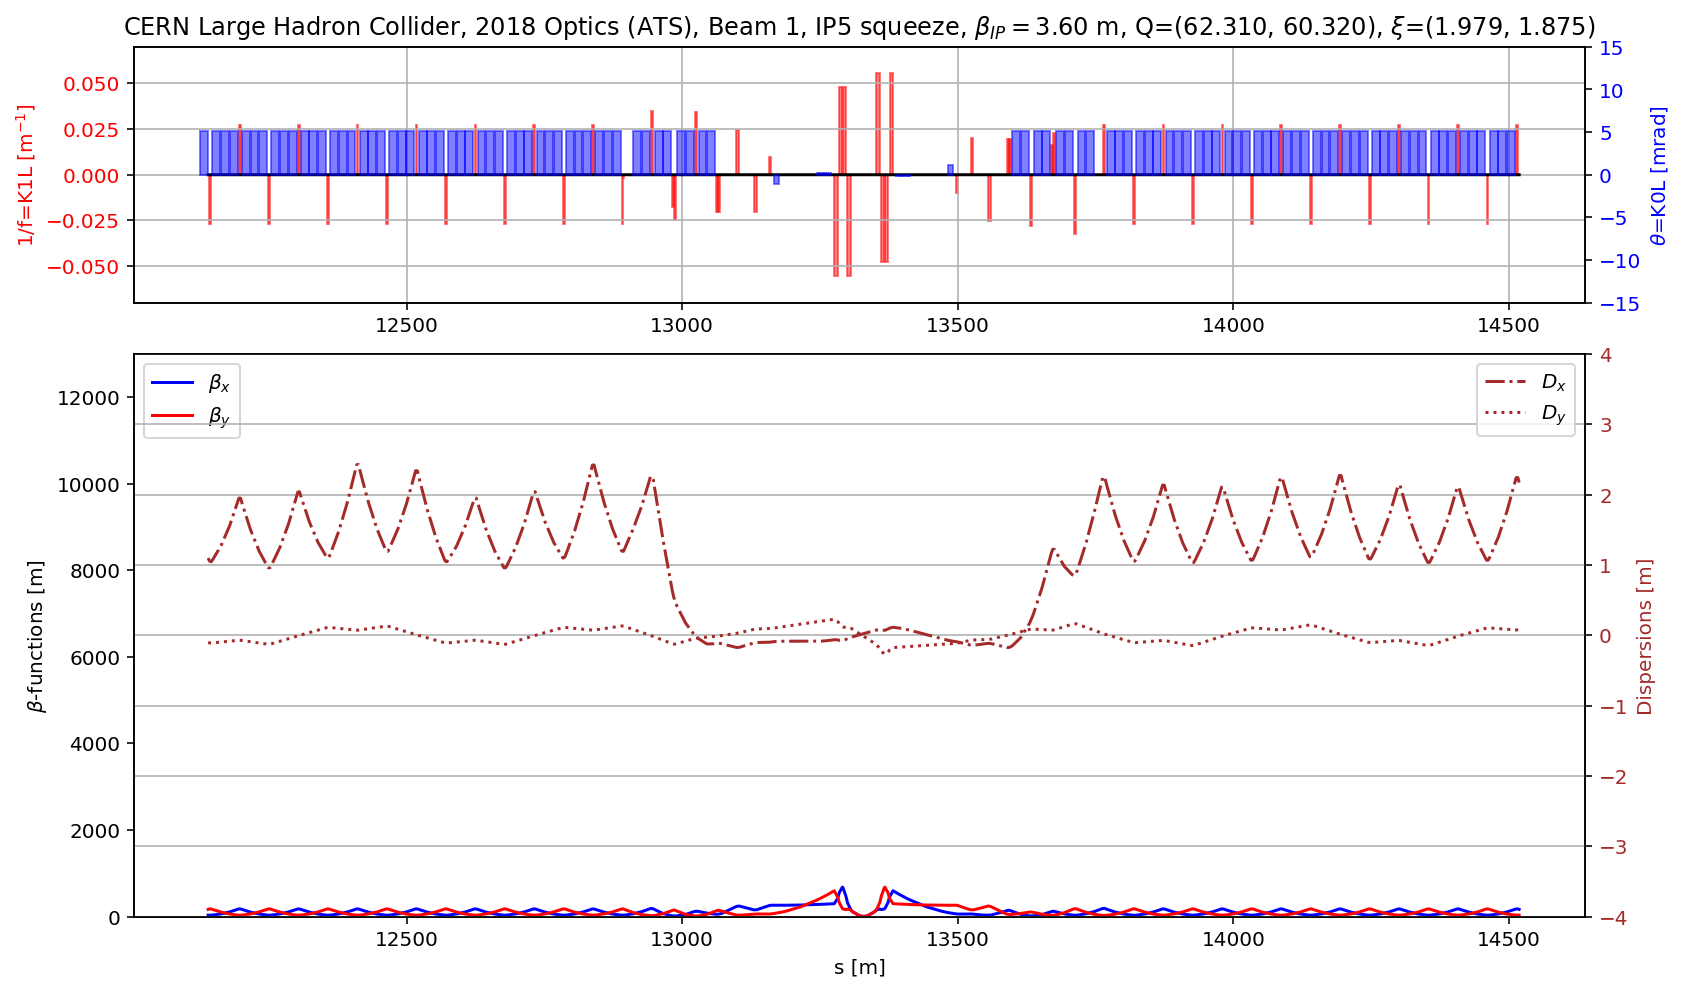

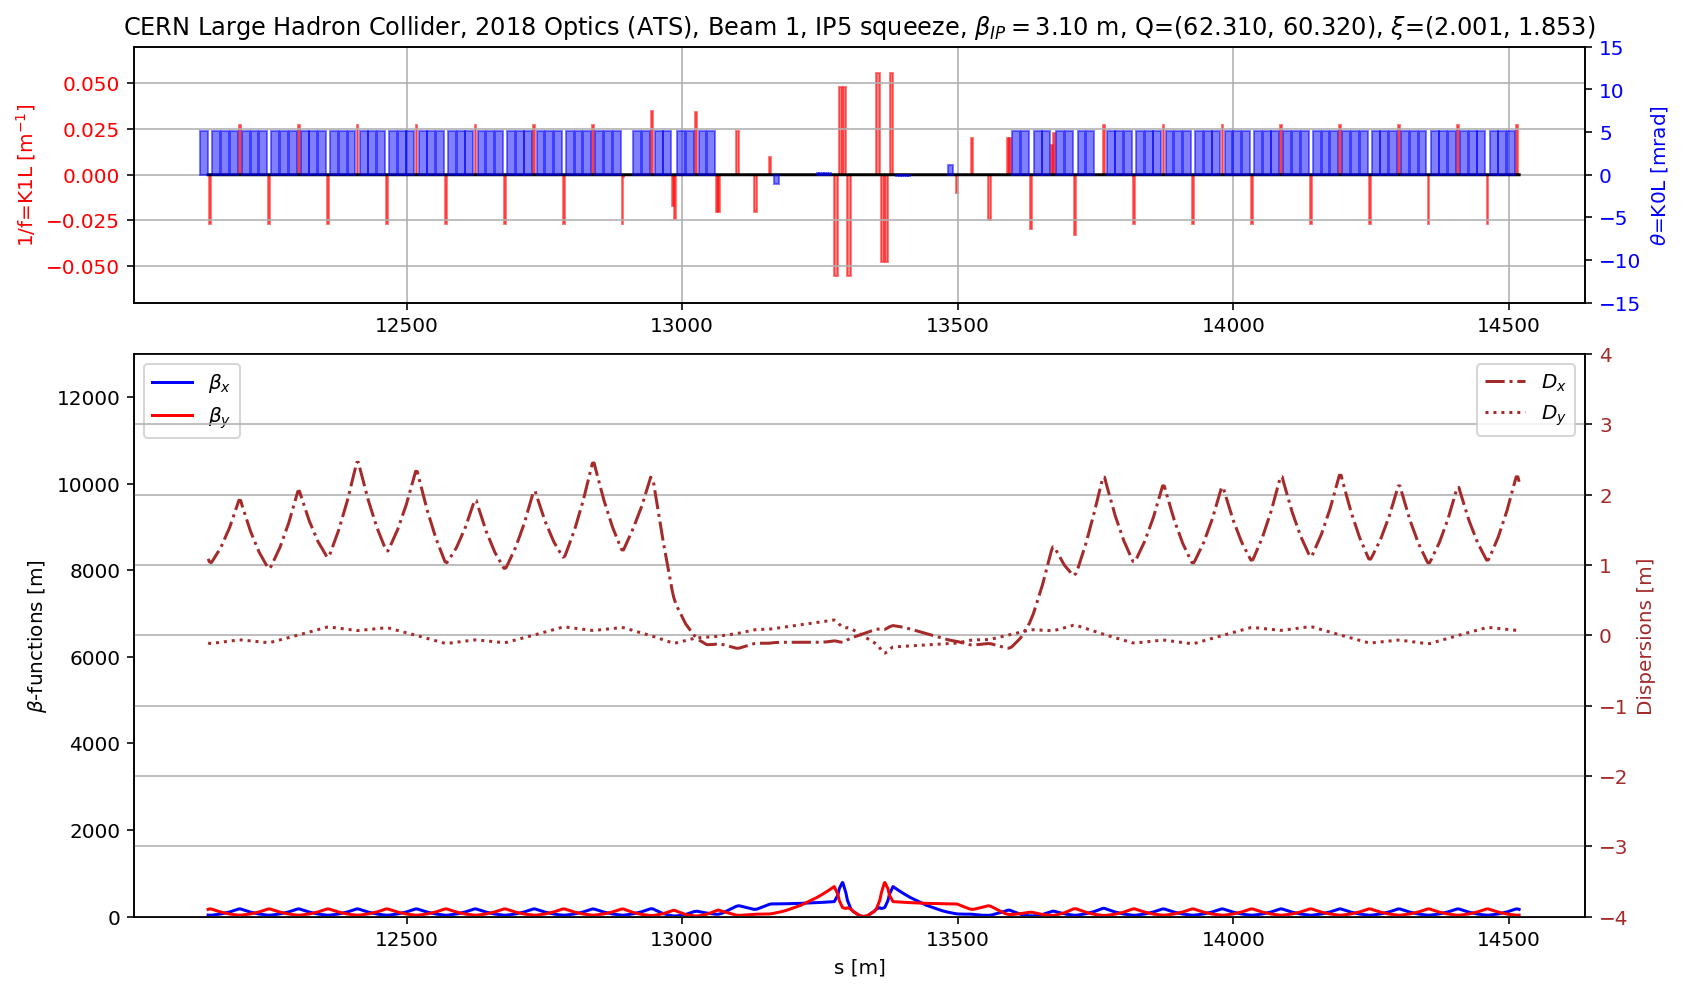

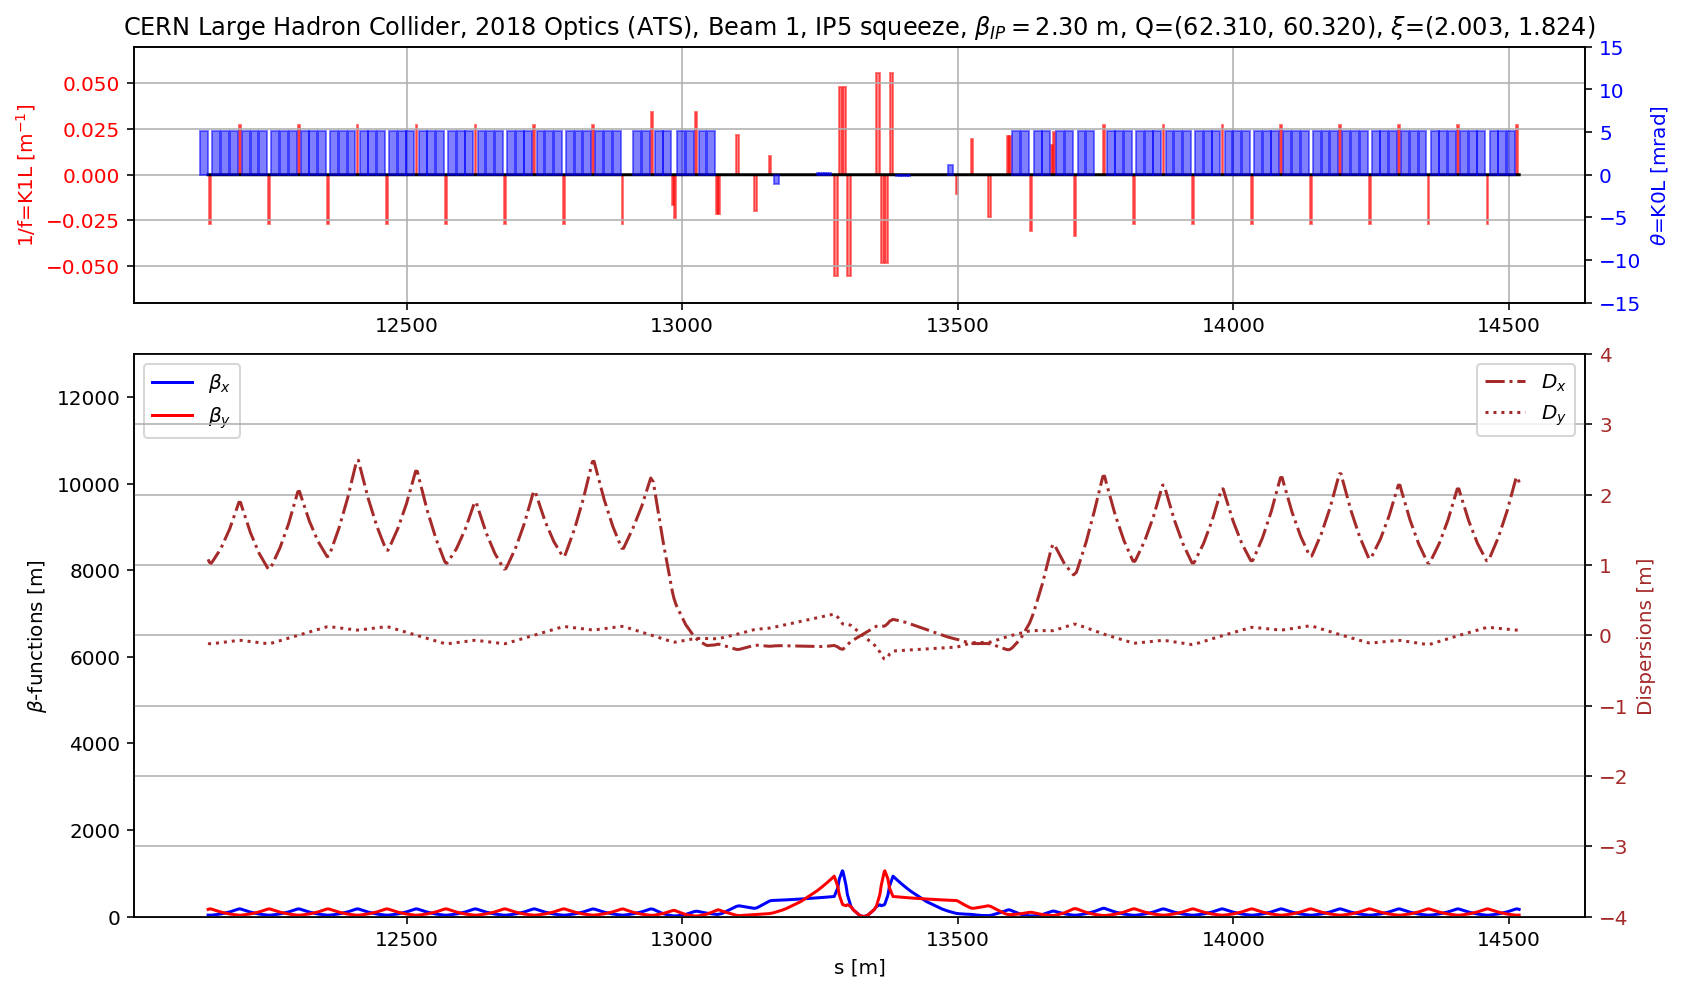

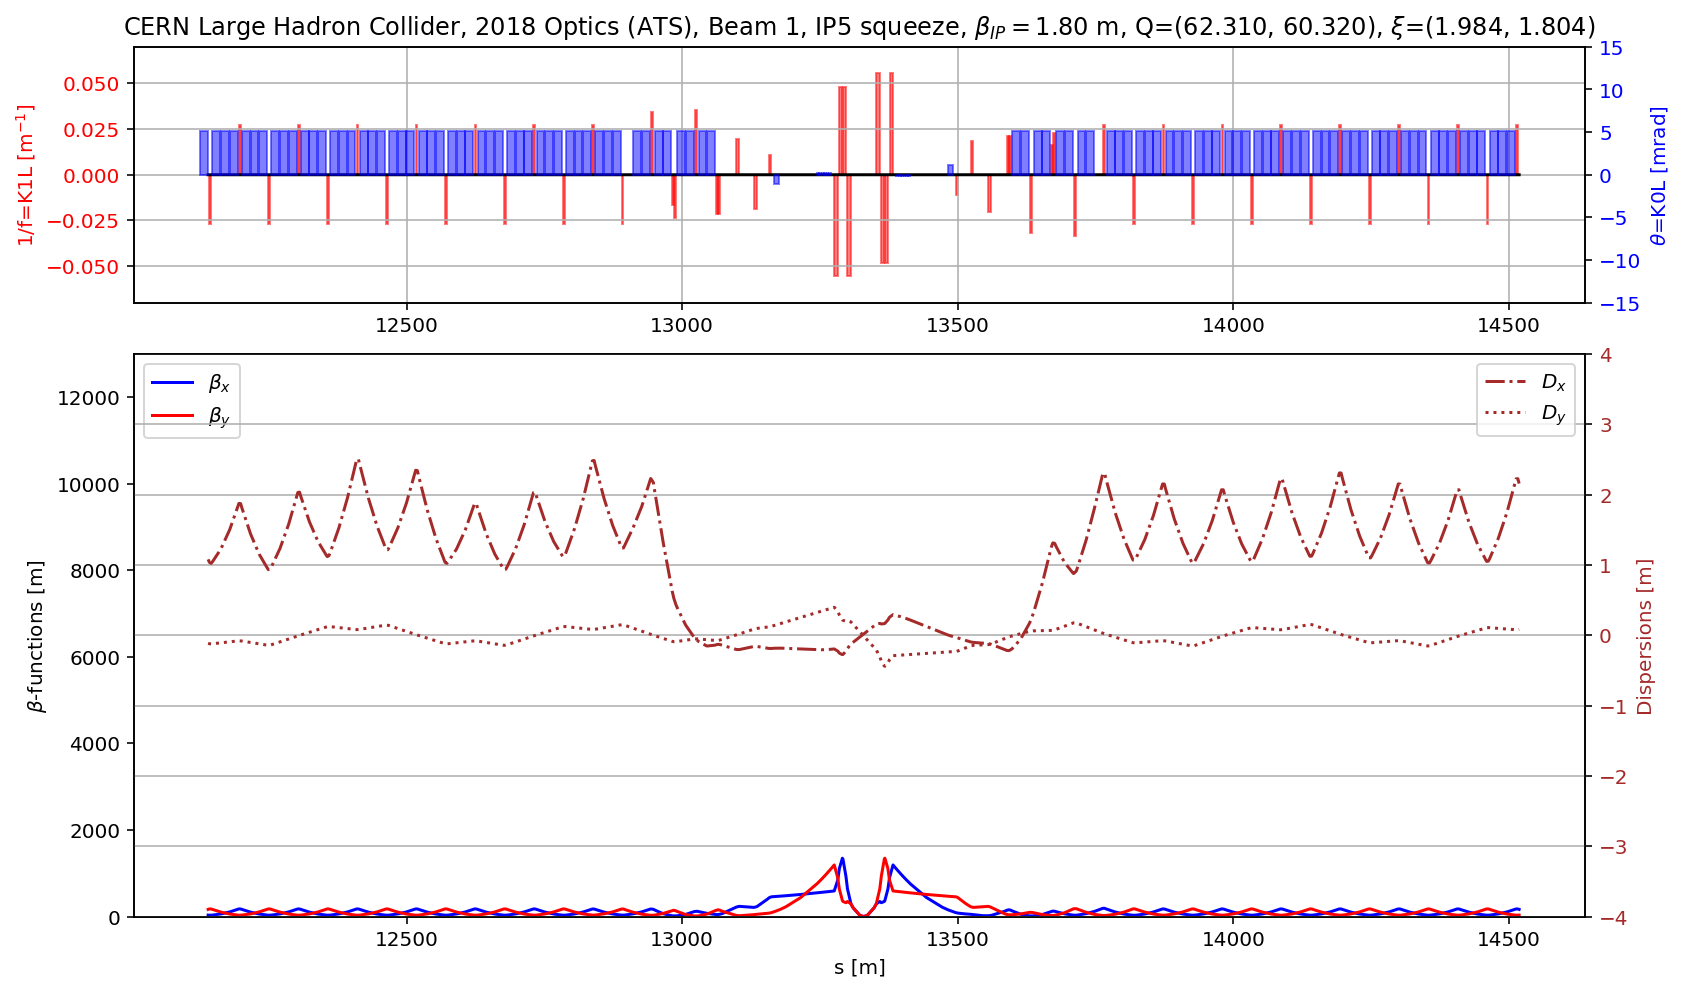

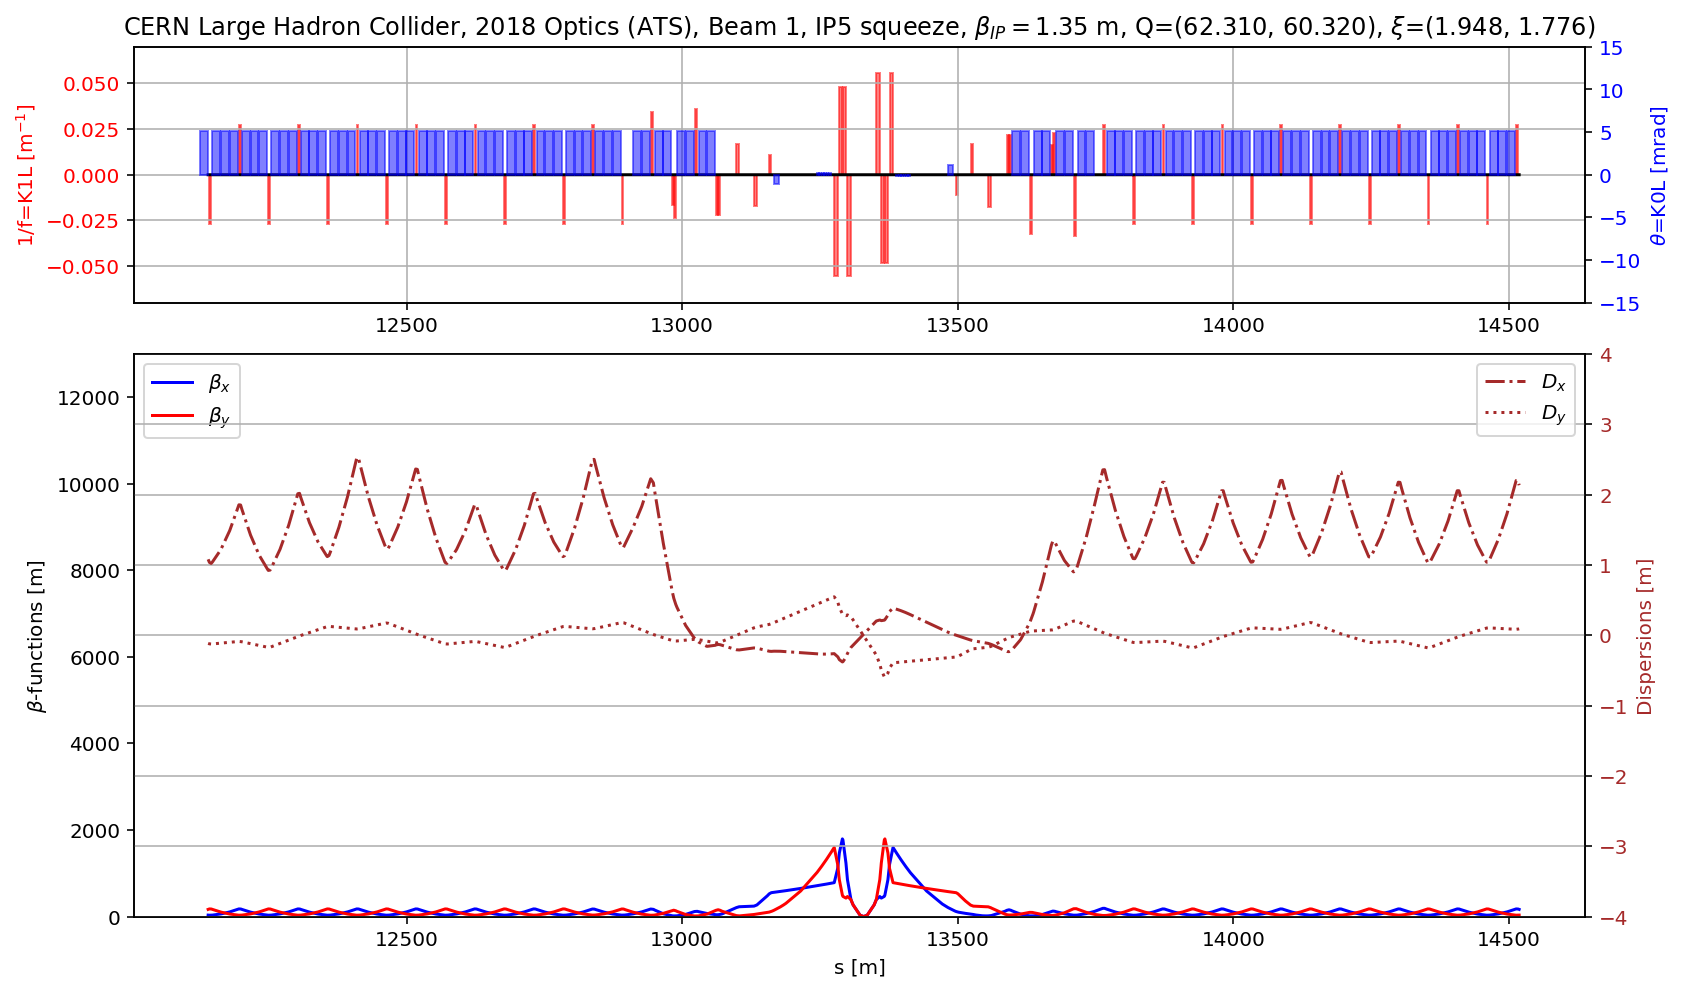

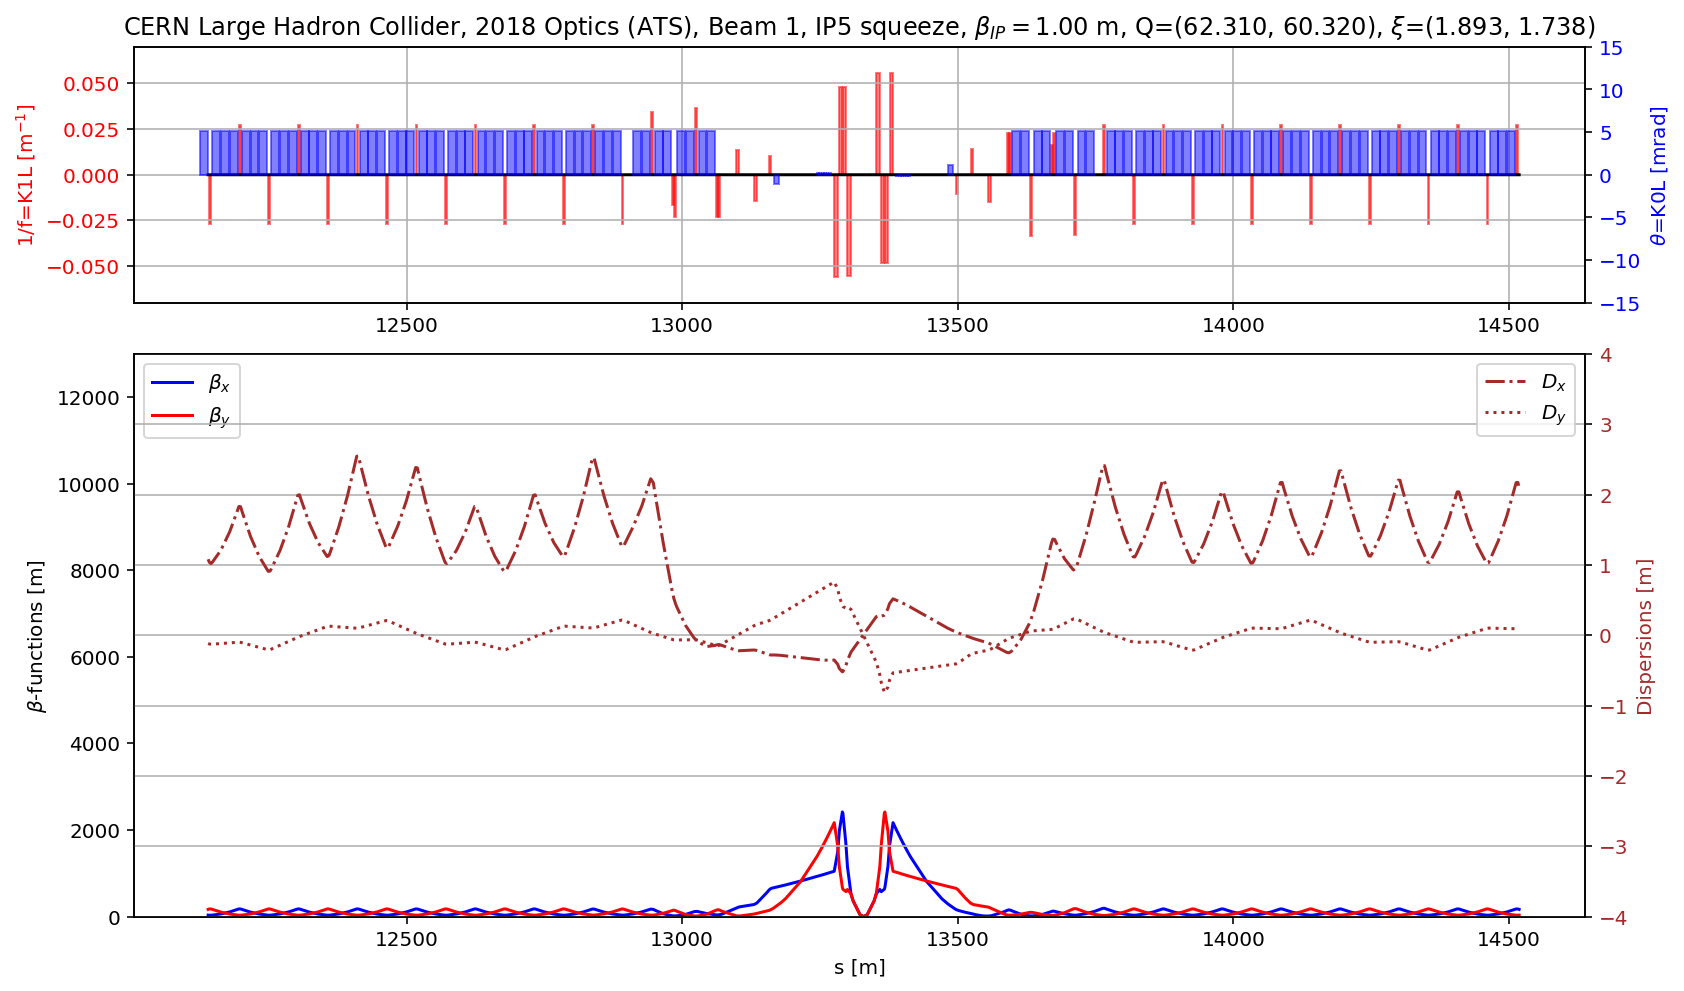

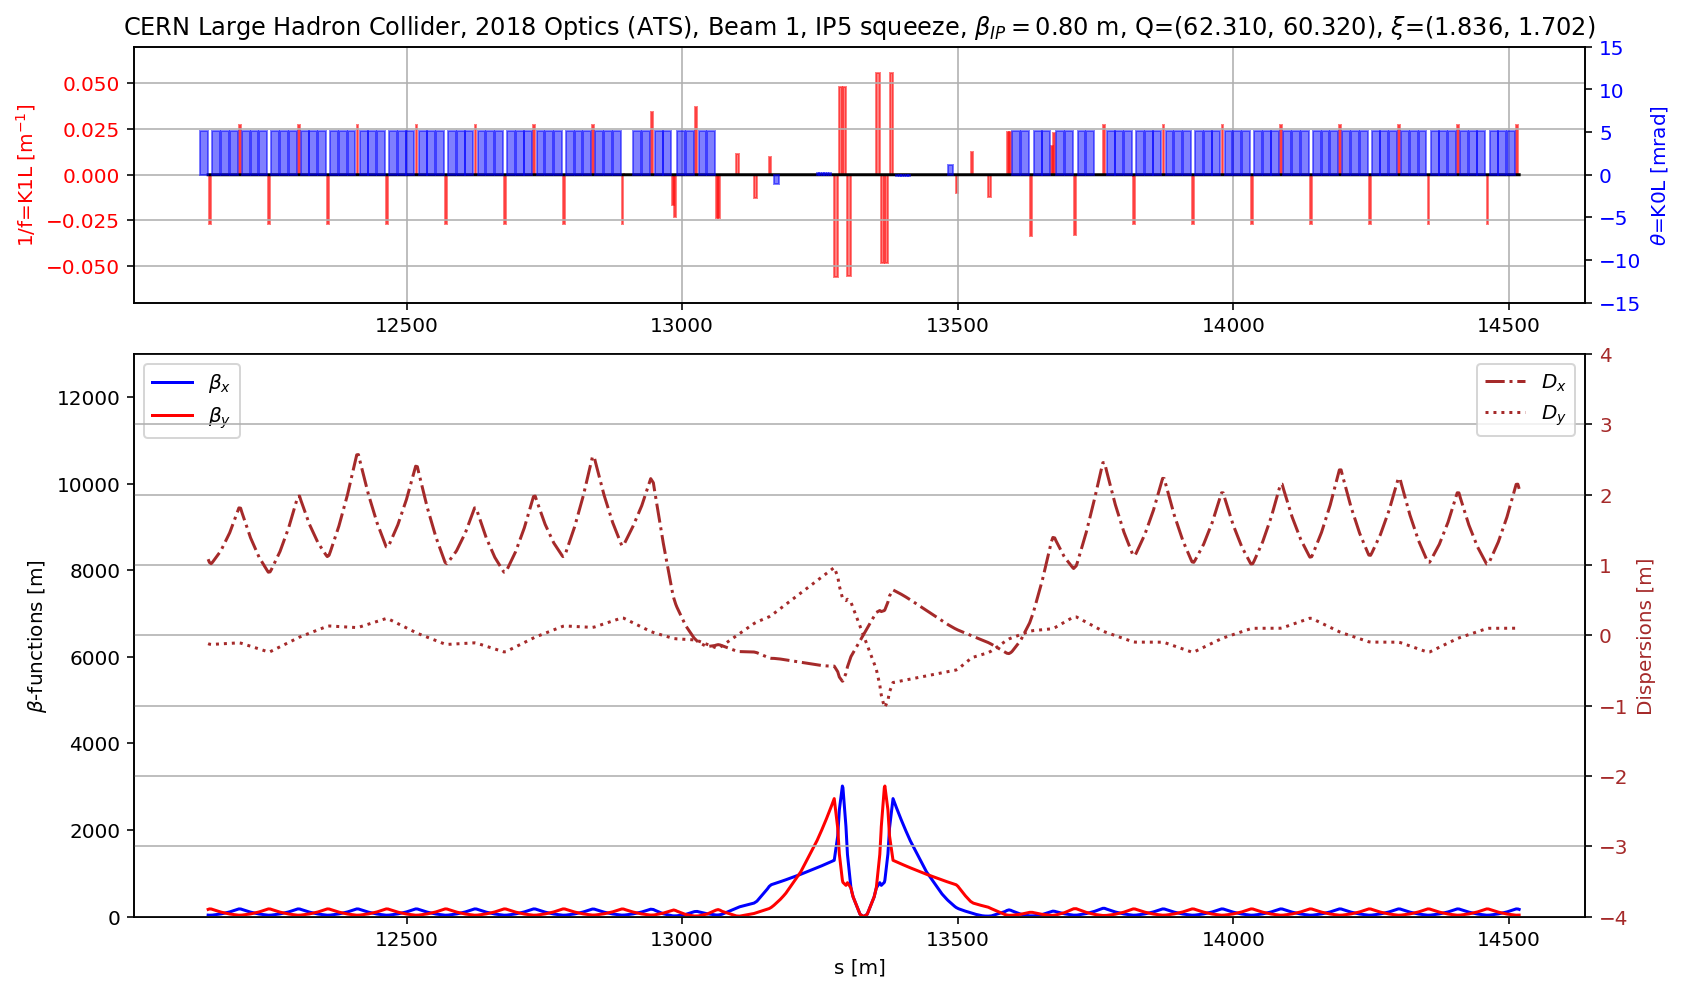

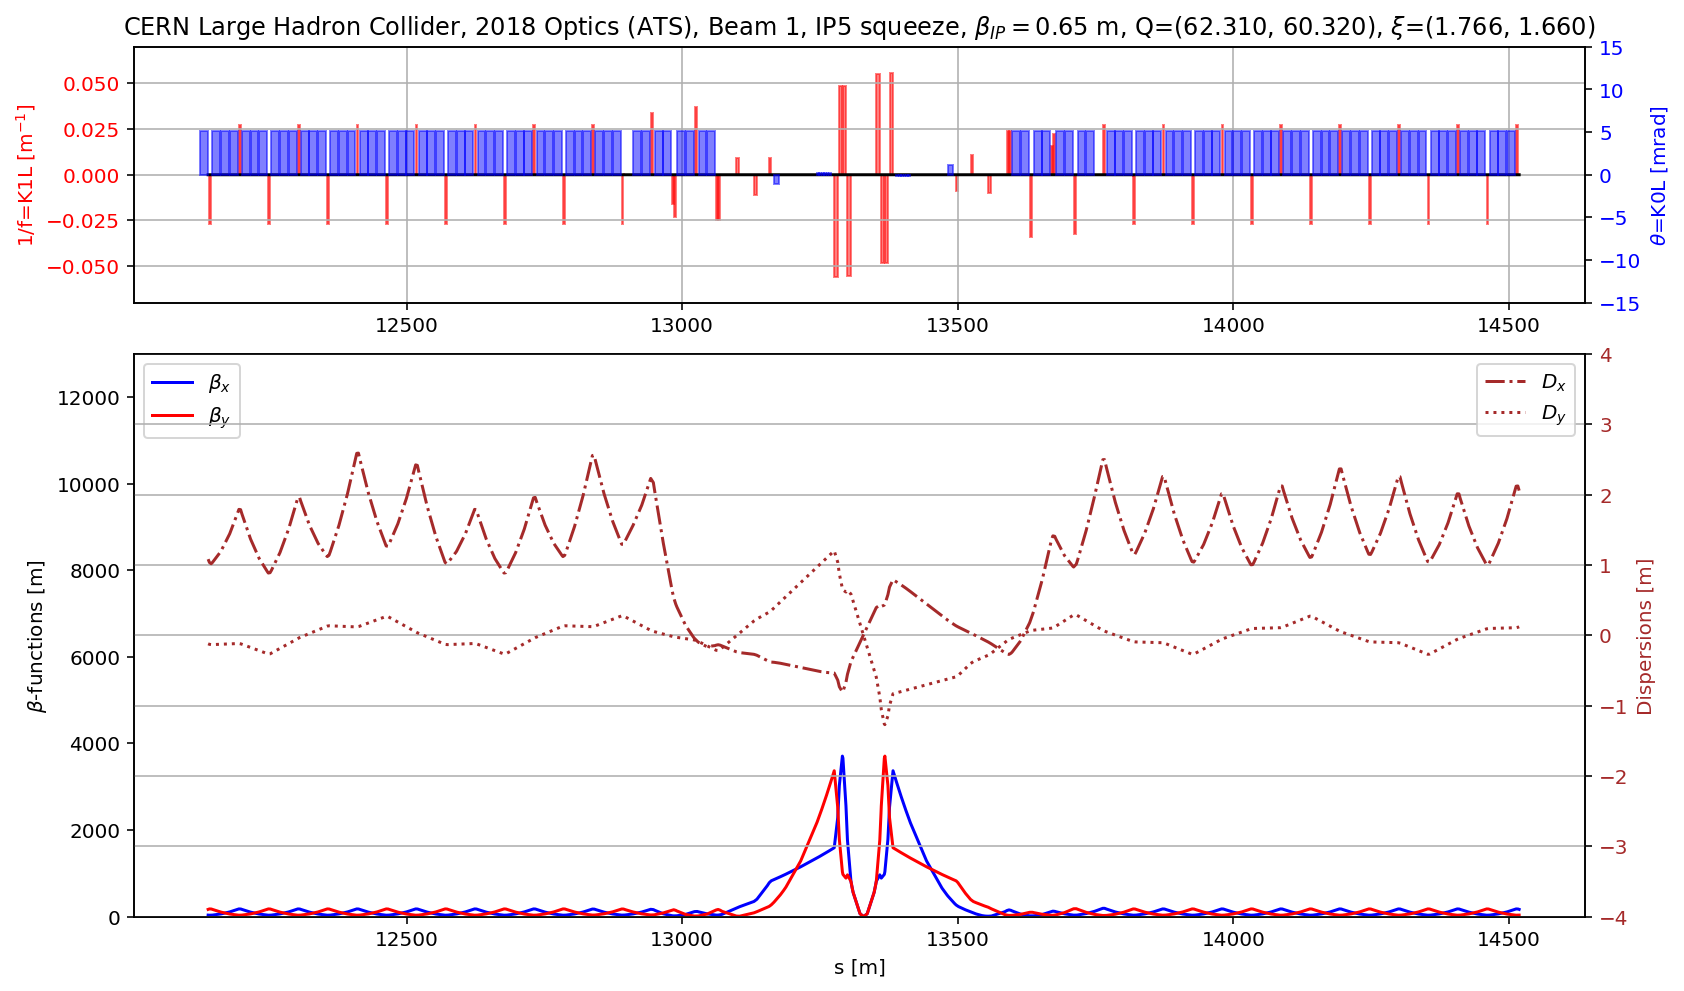

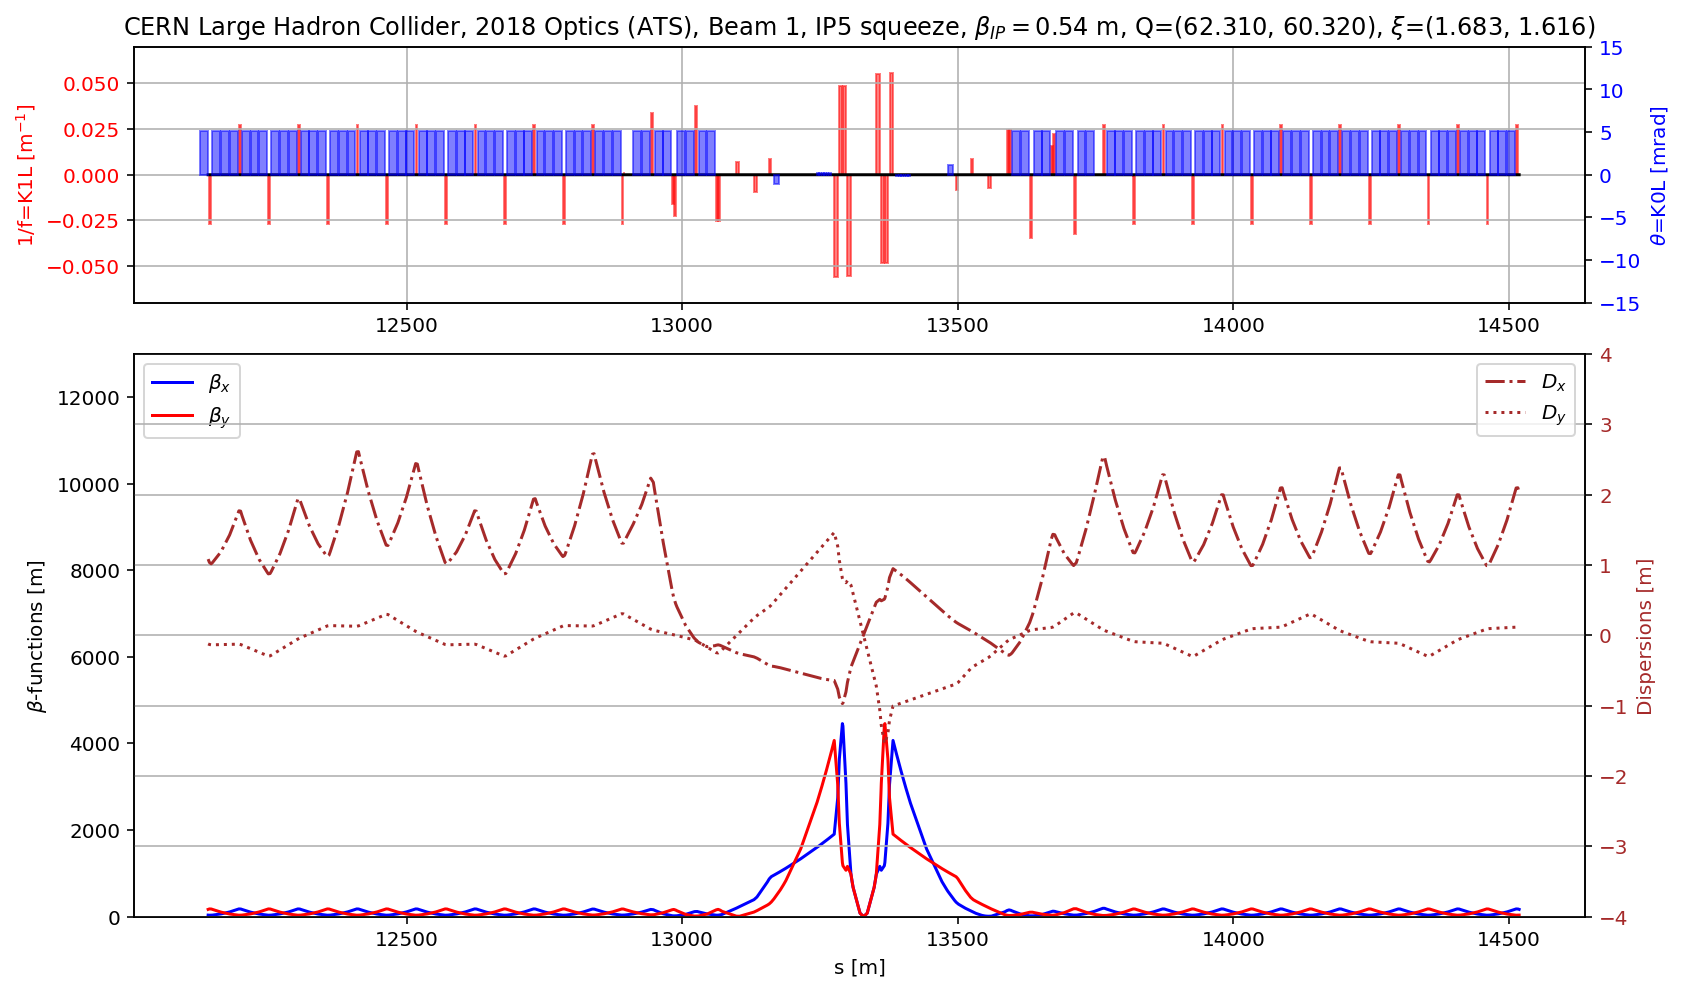

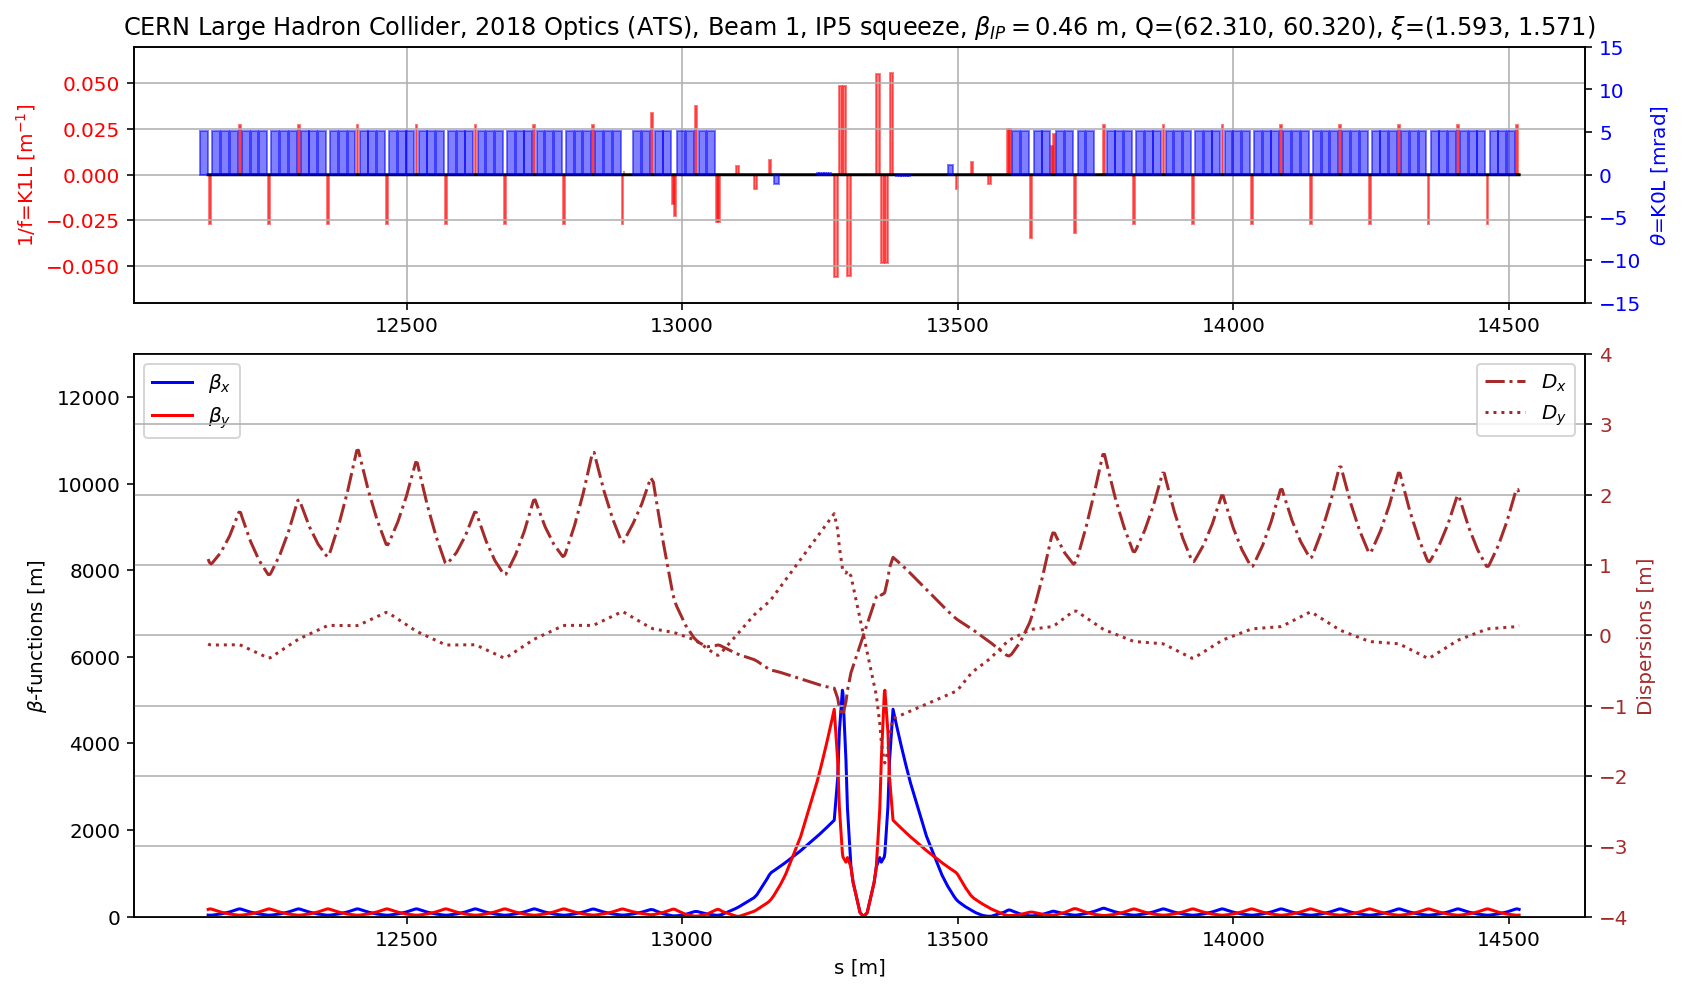

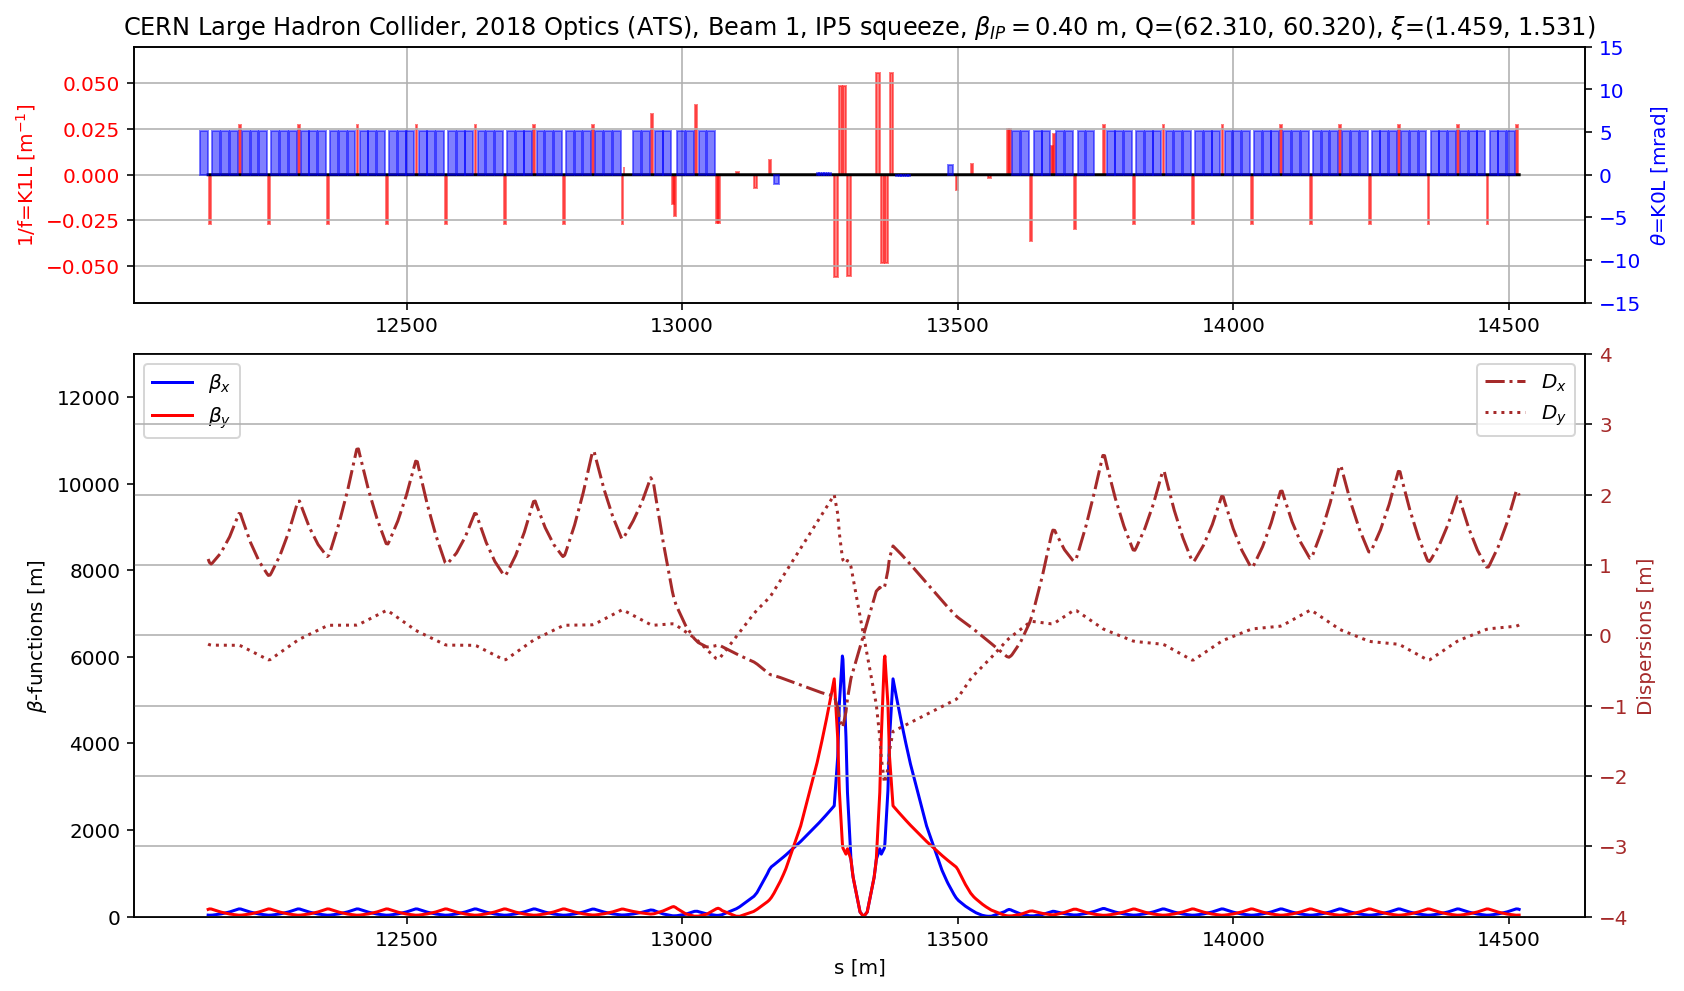

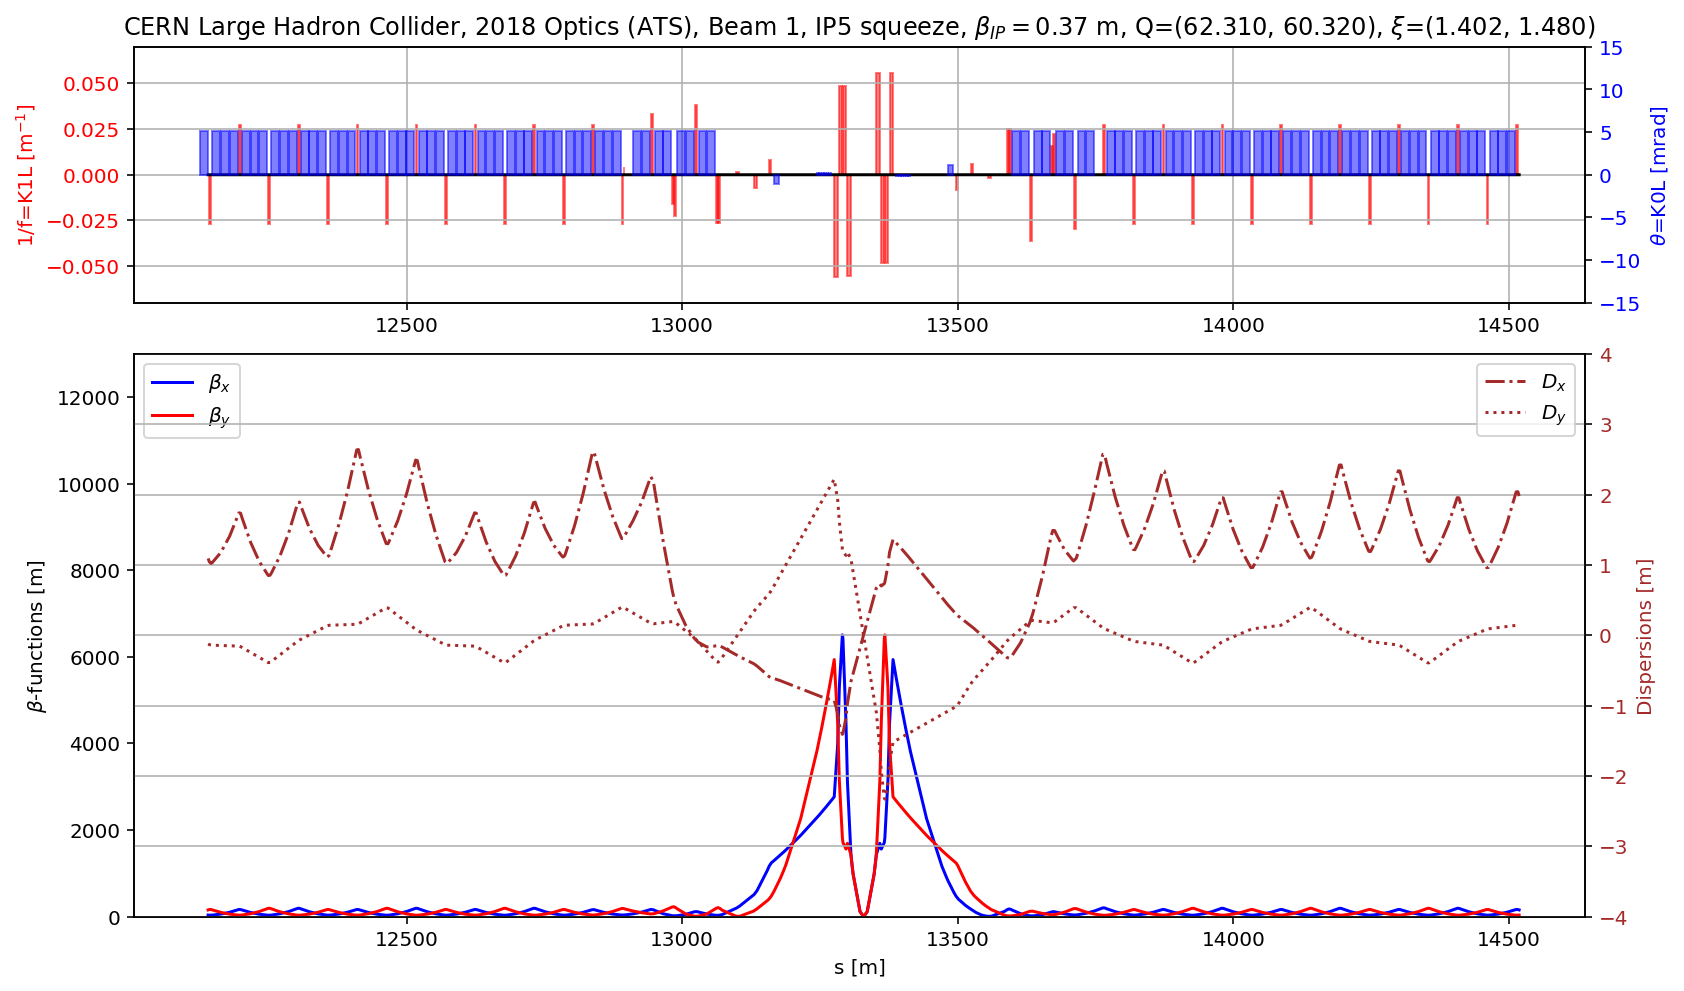

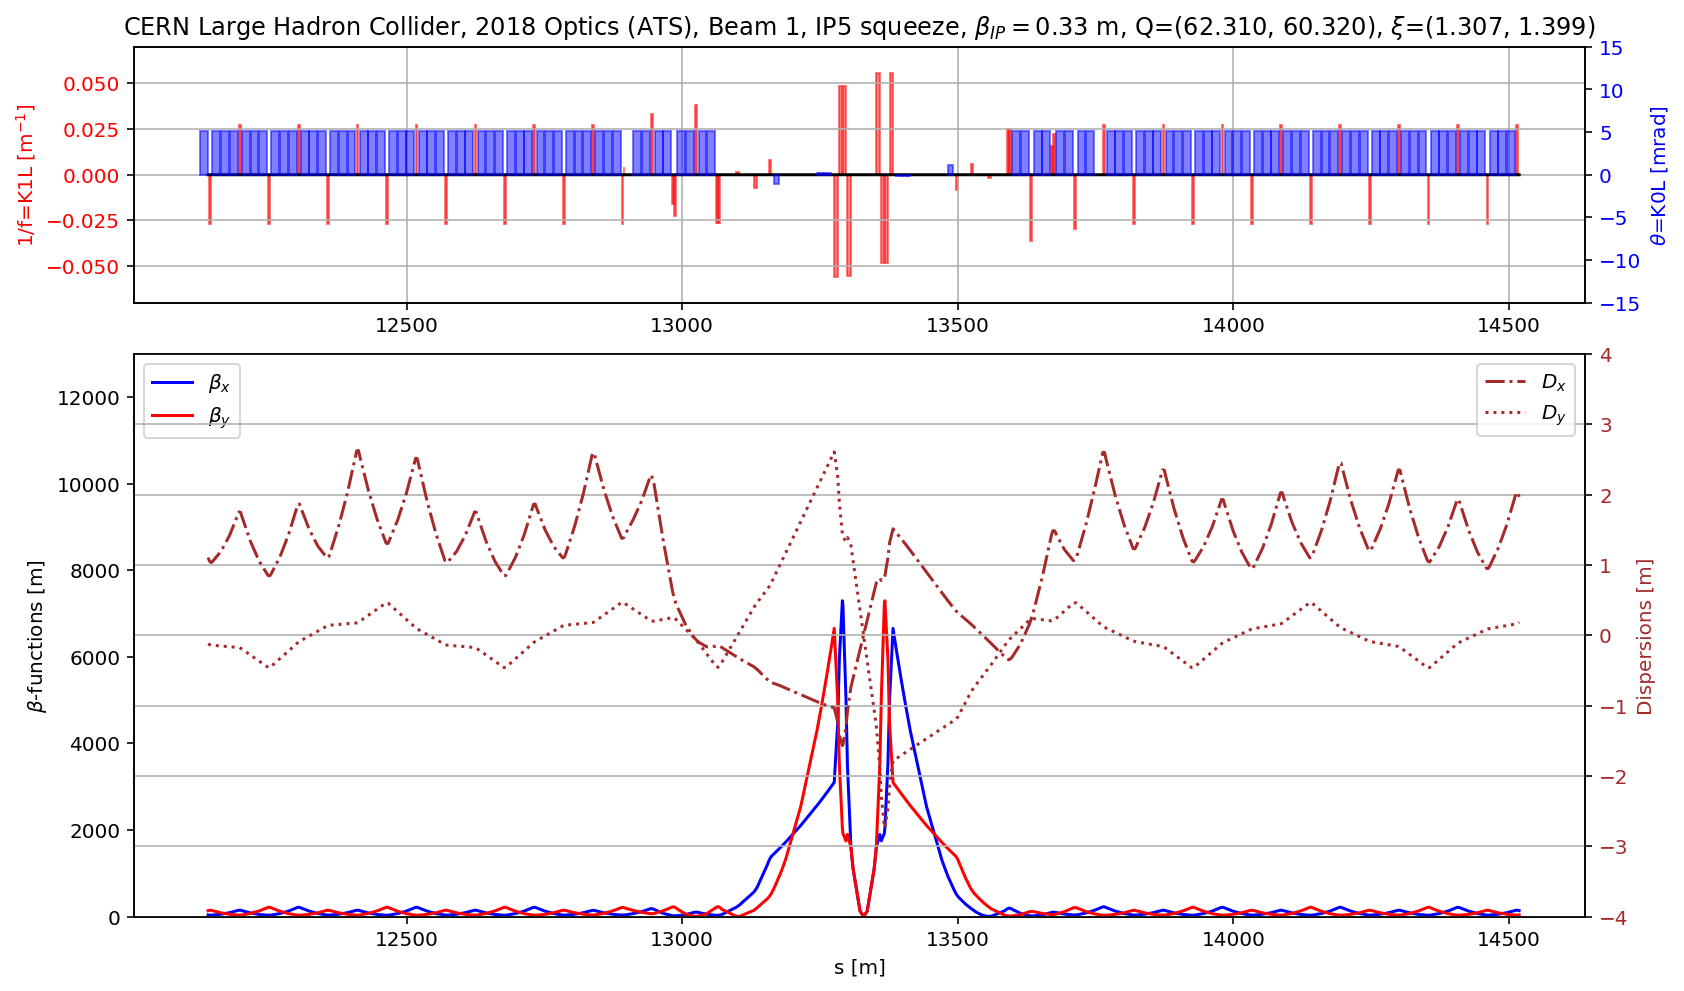

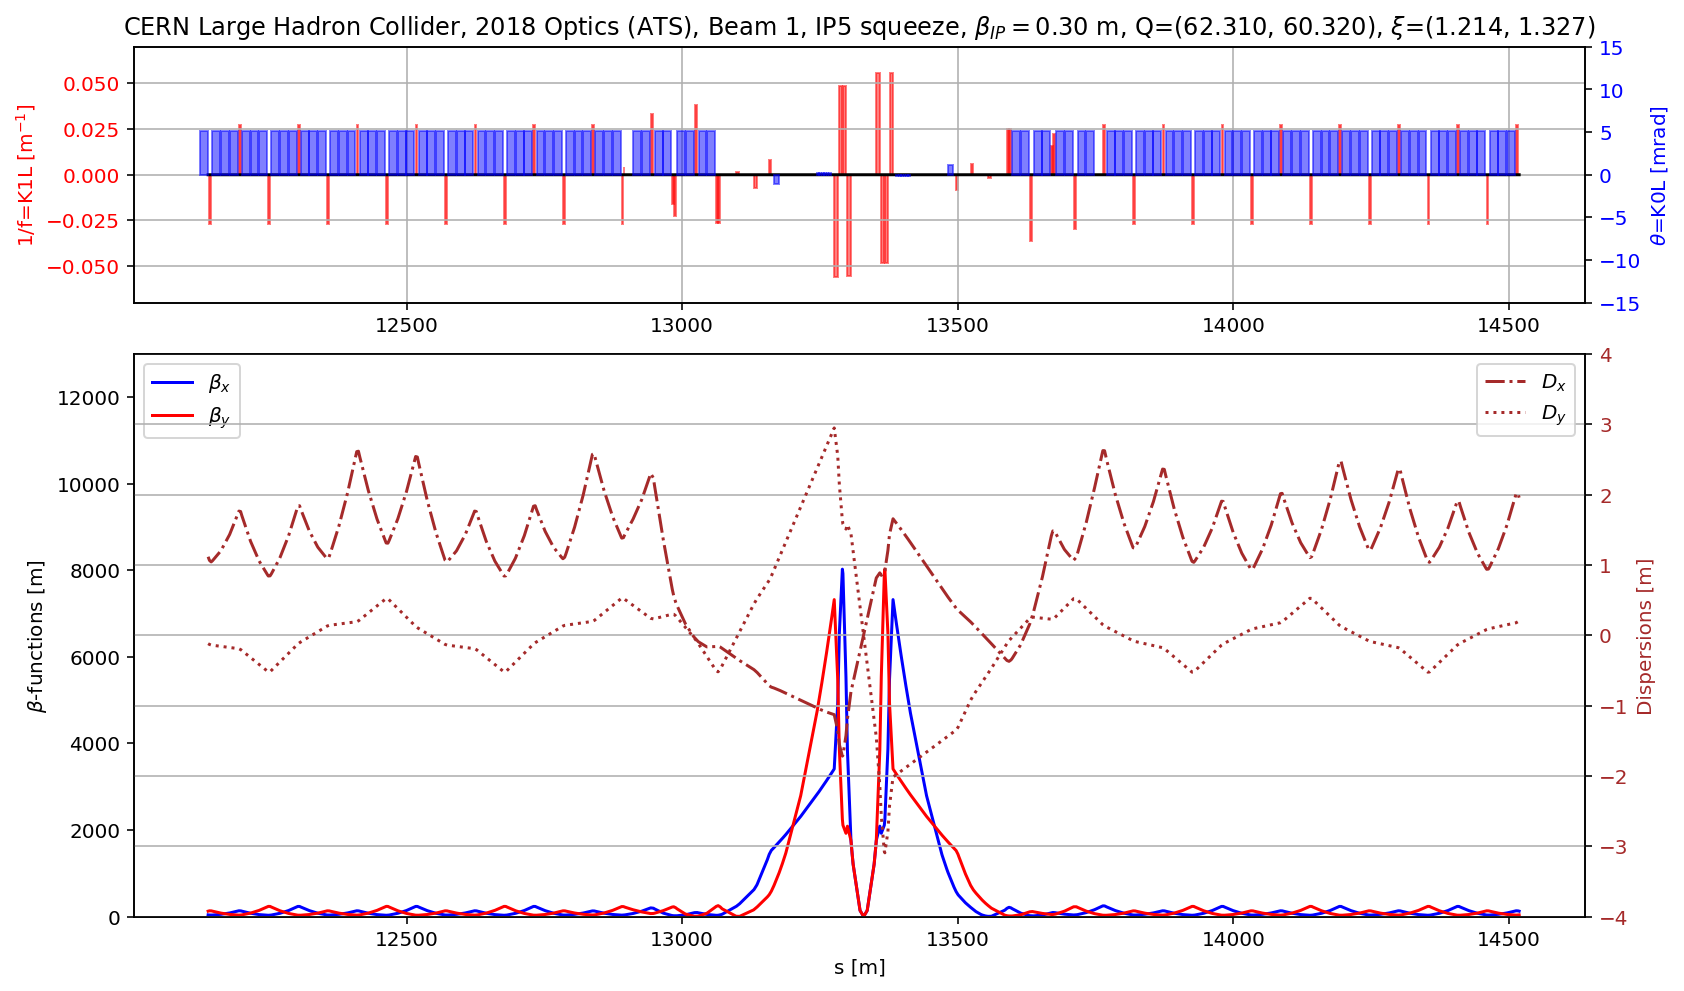

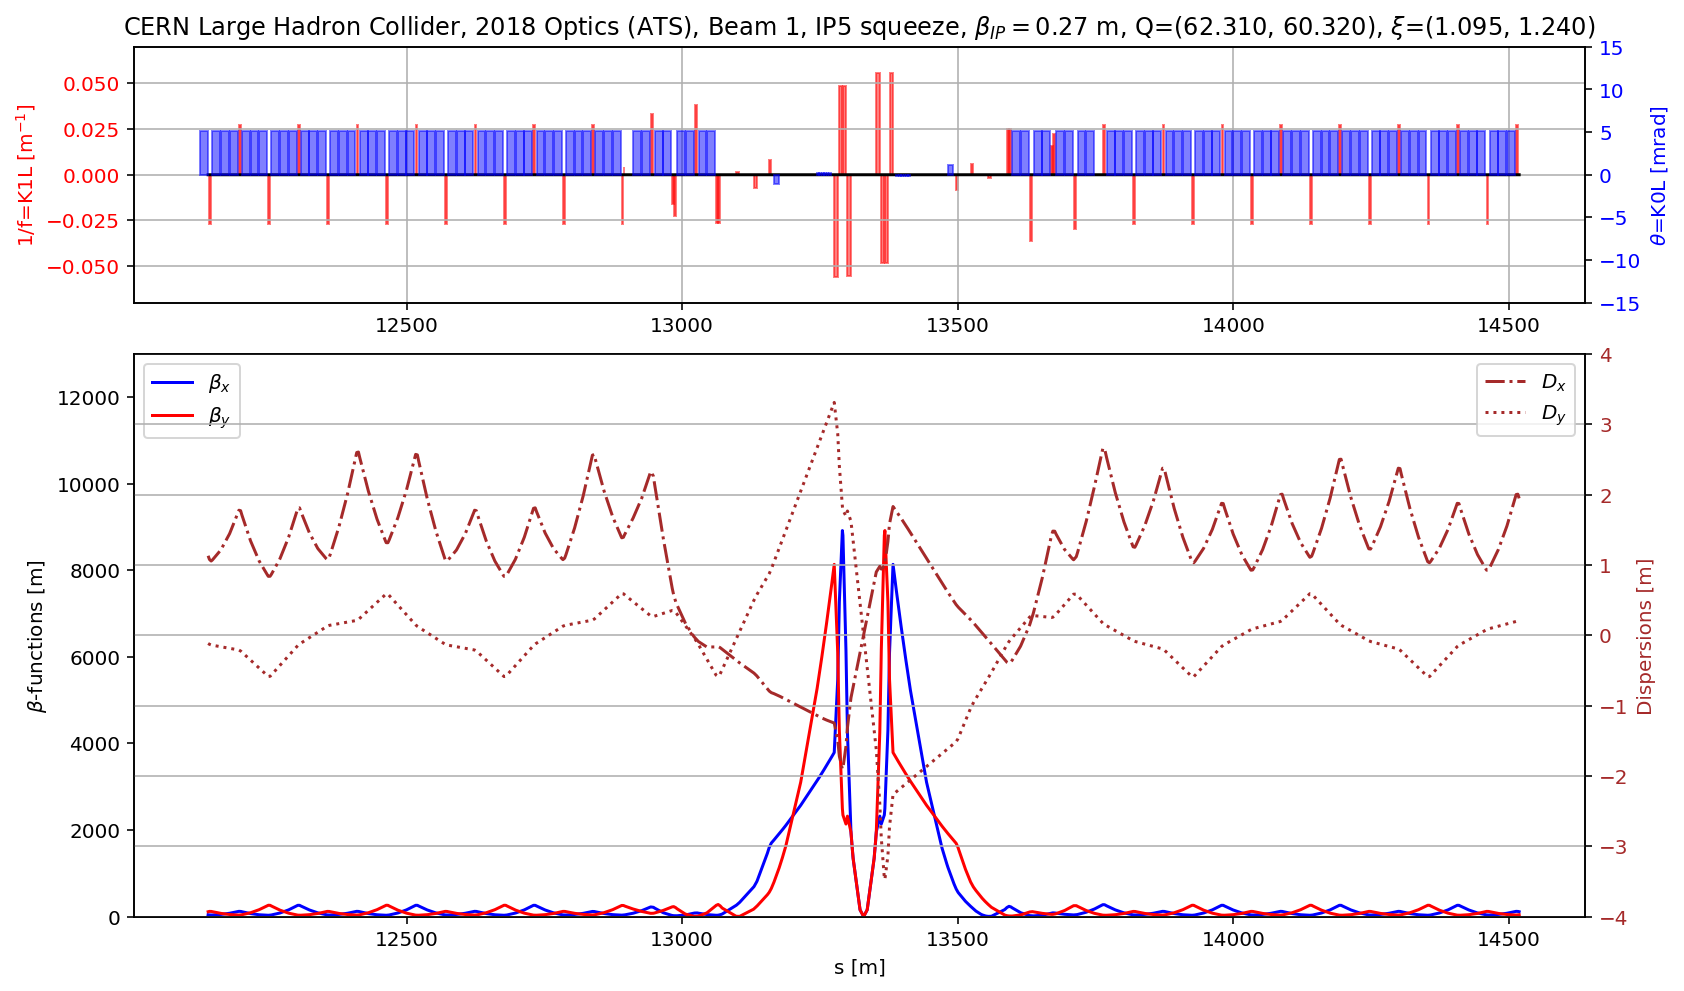

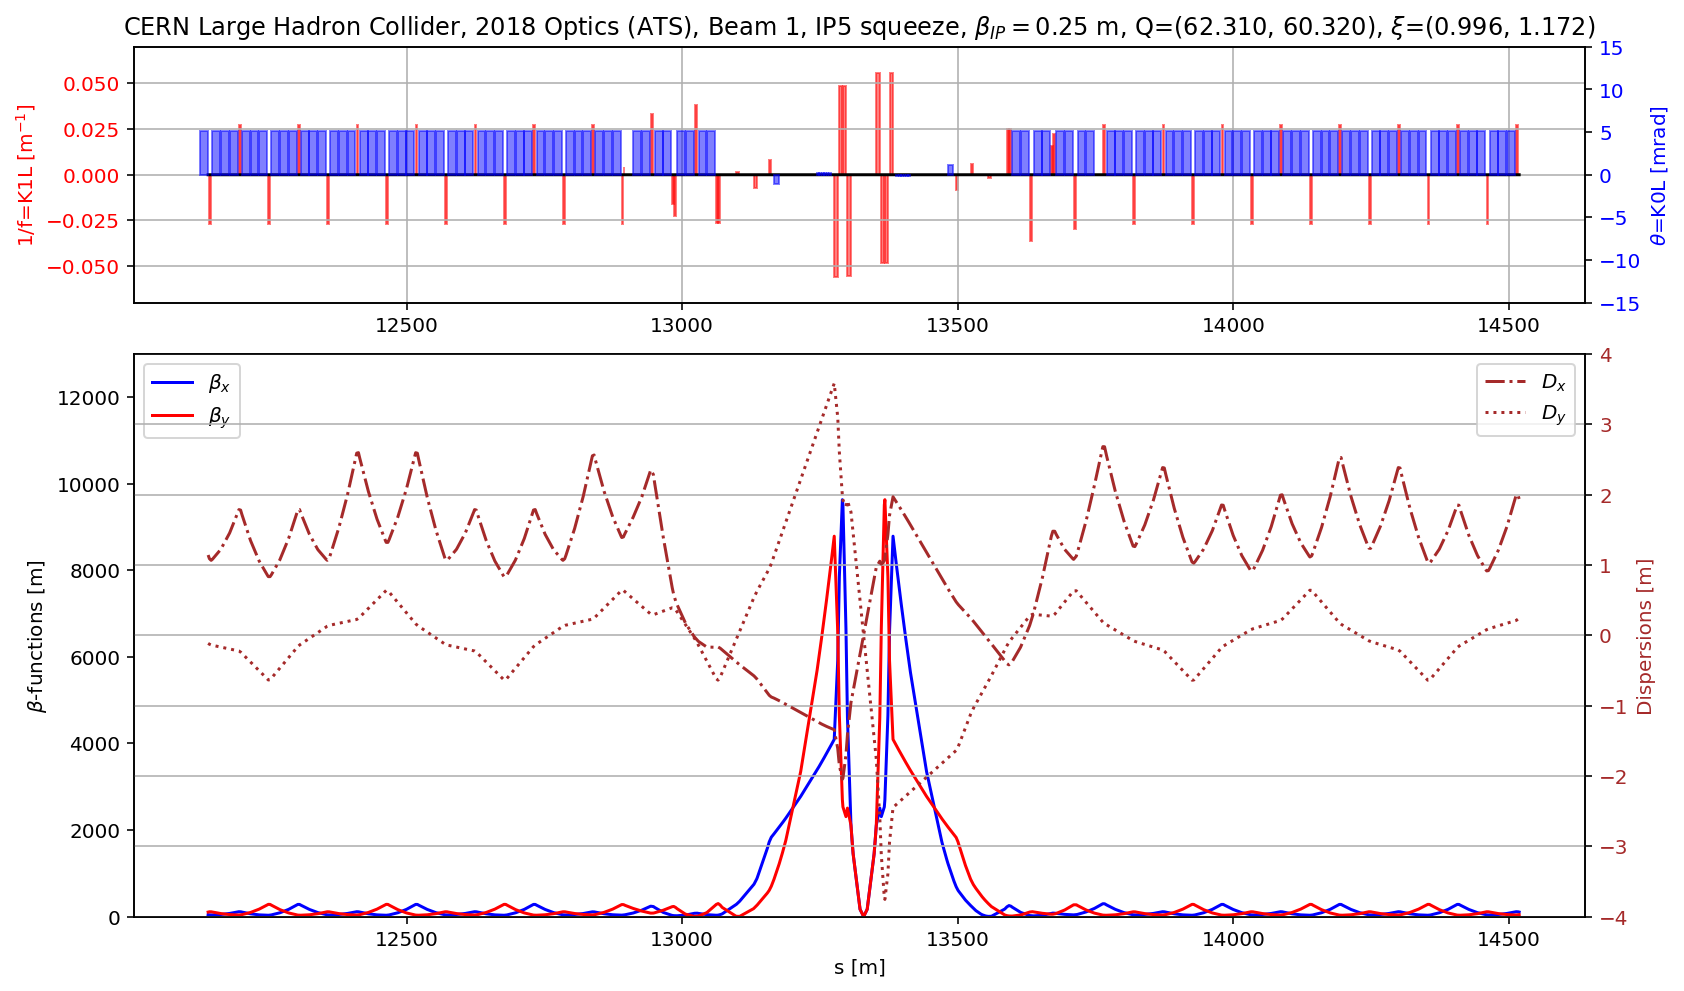

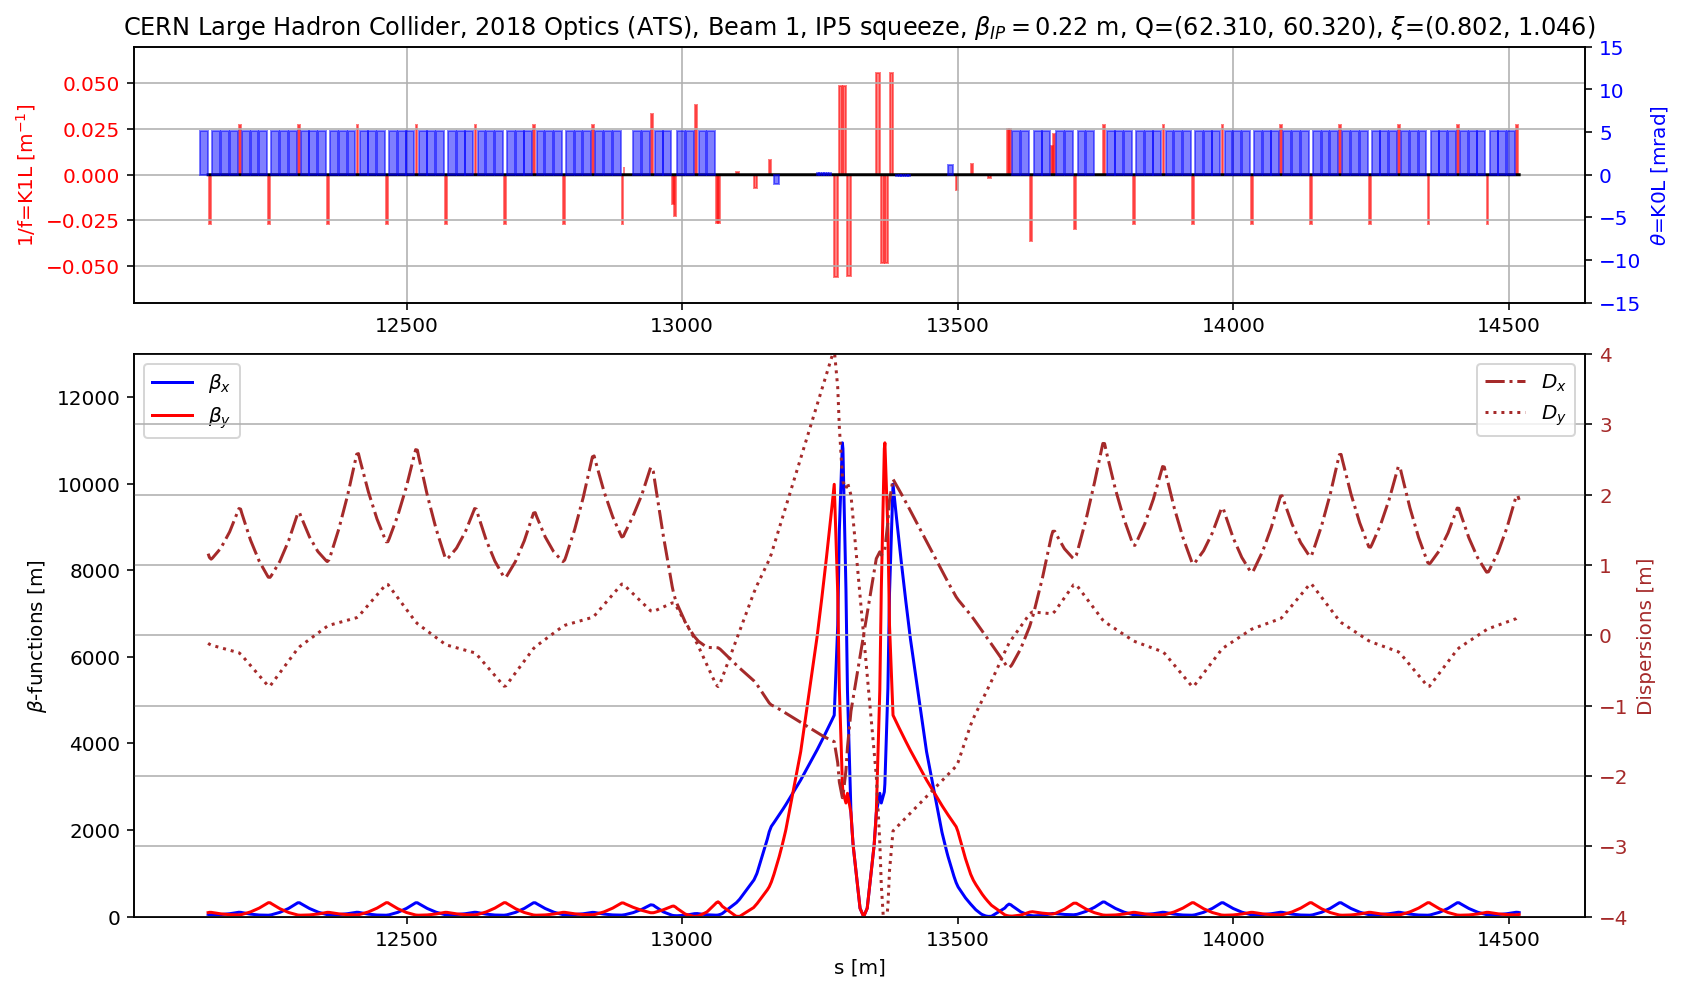

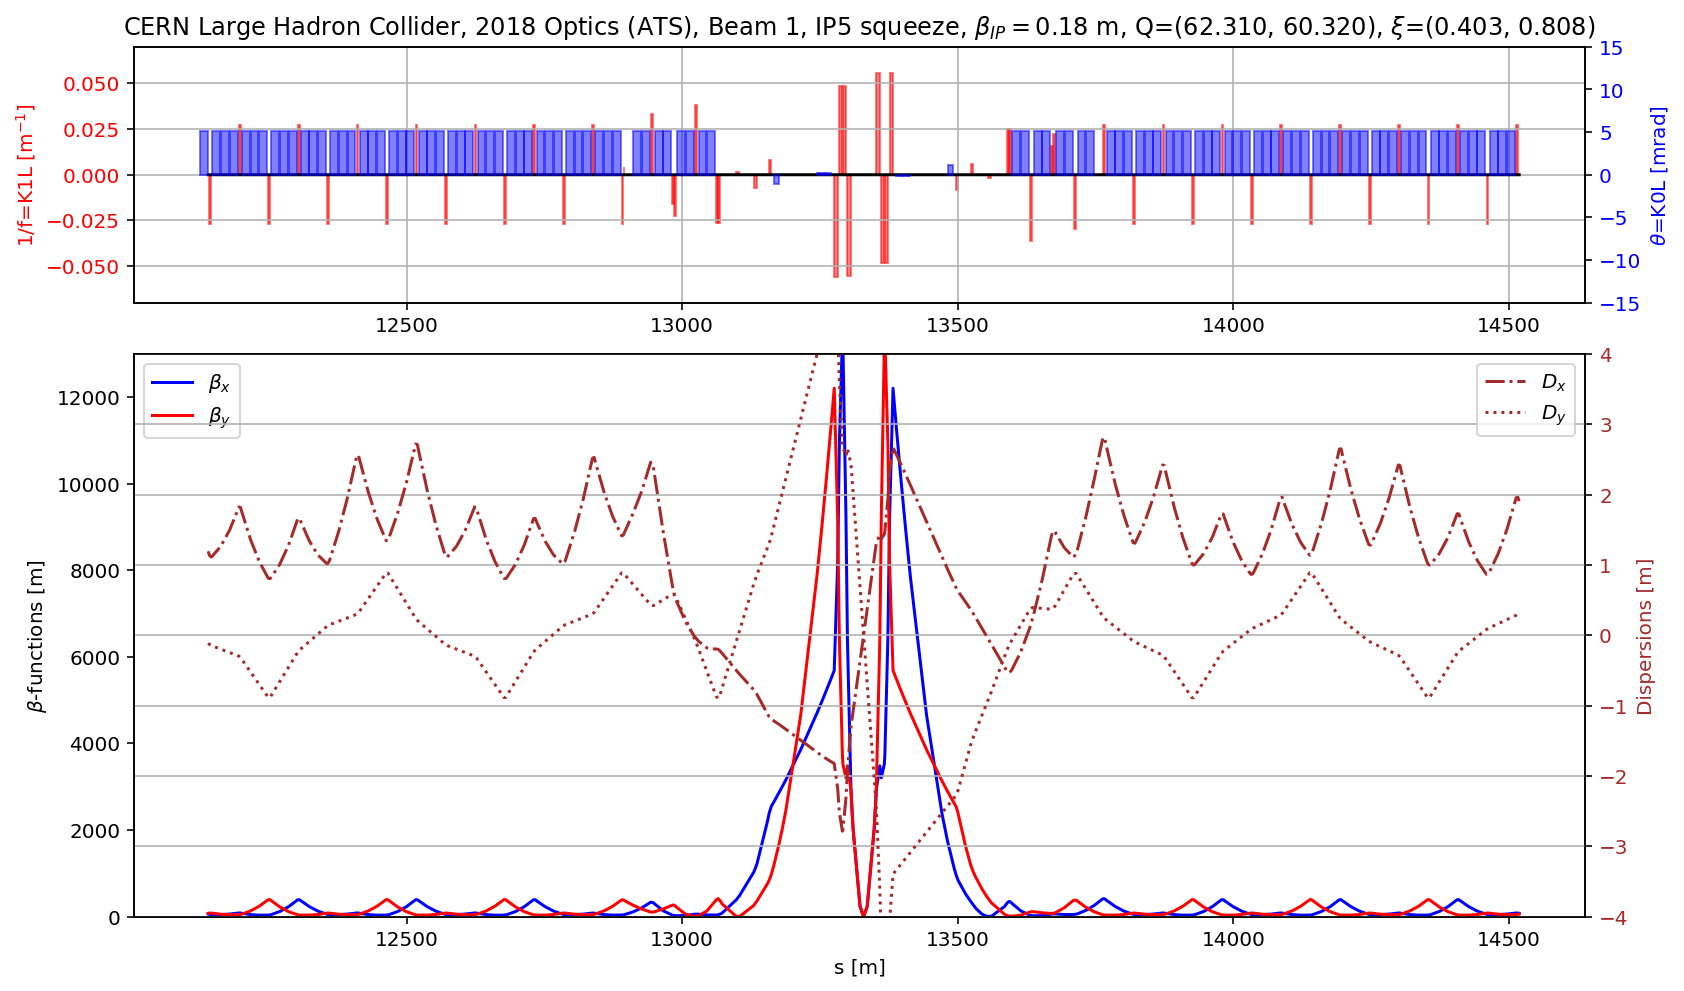

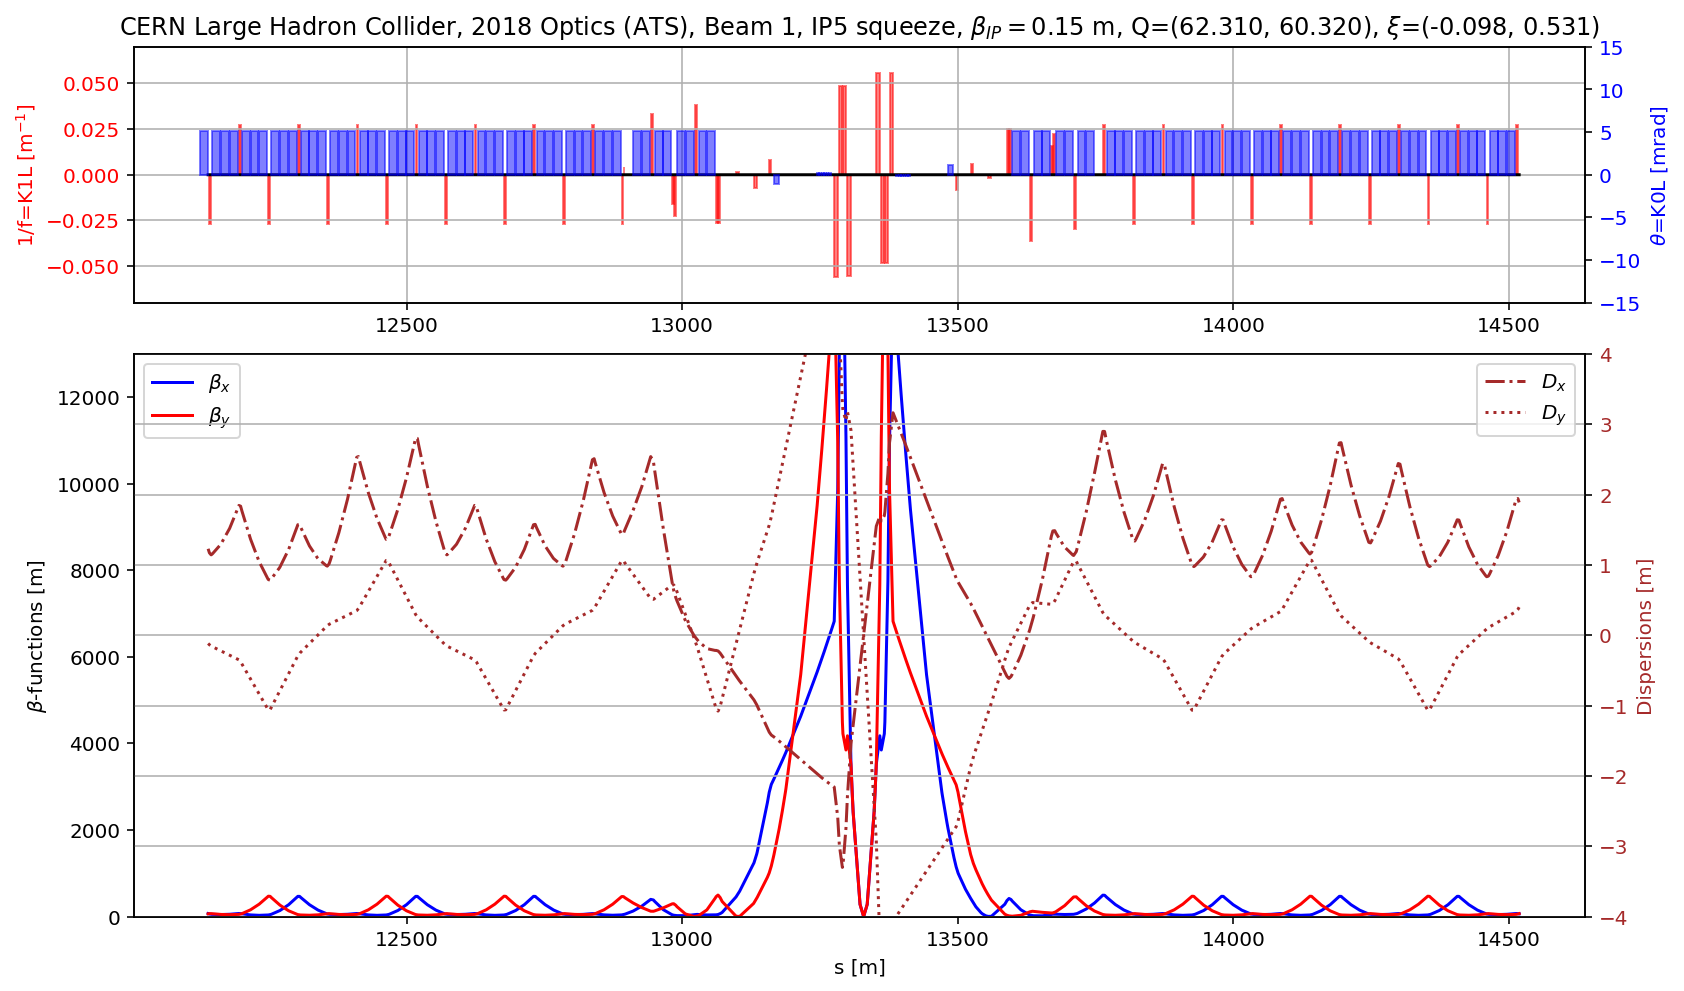

In [59]:
myOpticsList=[
'opticsfile.1',
'opticsfile.2',
'opticsfile.3',
'opticsfile.4',
'opticsfile.5',
'opticsfile.6',
'opticsfile.7',
'opticsfile.8',
'opticsfile.9',
'opticsfile.10',
'opticsfile.11',
'opticsfile.12',
'opticsfile.13',
'opticsfile.14',
'opticsfile.15',
'opticsfile.16',
'opticsfile.17',
'opticsfile.18',
'opticsfile.19_ctpps2',
'opticsfile.20_ctpps2',
'opticsfile.21_ctpps2',
'opticsfile.22_ctpps2',
'opticsfile.23_ctpps2',
'opticsfile.24_ctpps2',
'opticsfile.25_ctpps2',
'opticsfile.26_ctpps2',
'opticsfile.27_ctpps2'
]

for i,j in zip(myOpticsList,range(27)):
    response = requests.get('http://lhc-optics.web.cern.ch/lhc-optics/runII/2018/PROTON/'+i)
    data = response.text
    madx.input(data);
    
    madx.input(
    '''
    use, sequence=lhcb1;
    twiss;
    ''');
    
    myTwiss=madx.table.twiss.dframe()
    myTwiss=myTwiss[(myTwiss['s']>(13329.289233-1200)) & (myTwiss['s']<(13329.289233+1200))]
    #display(myTwiss[myTwiss['name'].str.contains('ip5')])
    
    fig = plt.figure(figsize=(13,8))

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid()
    plt.ylim(-.07,.07)
#    plt.title('CERN Large Hadron Collider, 2016 Optics, Beam 1, IP5 squeeze, $\\beta_{IP}=$'+format(myTwiss[myTwiss['name'].str.contains('ip5')]['betx'].values[0],'2.2f')+' m,Q=('+format(madx.table.summ.Q1[0],'2.3f')+', '+ format(madx.table.summ.Q2[0],'2.3f')+'), $1$=('+format(madx.table.summ.DQ1[0],'2.3f')+', '+ format(madx.table.summ.DQ2[0],'2.3f')+')')
    plt.title('CERN Large Hadron Collider, 2018 Optics (ATS), Beam 1, IP5 squeeze, $\\beta_{IP}=$'+format(myTwiss[myTwiss['name'].str.contains('ip5')]['betx'].values[0],'2.2f')+' m, Q=('+format(madx.table.summ.Q1[0],'2.3f')+', '+ format(madx.table.summ.Q2[0],'2.3f')+'), $\\xi$=('+format(madx.table.summ.DQ1[0],'2.3f')+', '+ format(madx.table.summ.DQ2[0],'2.3f')+')')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [mrad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    DF=myTwiss[(myTwiss['keyword']=='rbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle/2*1000, color='b')

    DF=myTwiss[(myTwiss['keyword']=='sbend')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle/2*1000, color='b')


    plt.ylim(-15,15)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
    plt.legend(loc=2)
    plt.ylabel('$\\beta$-functions [m]')
    plt.xlabel('s [m]')
    plt.ylim(0,13000)

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],ls='-.',color='brown', label='$D_x$')
    plt.plot(myTwiss['s'],myTwiss['dy'],ls=':',color='brown', label='$D_y$')
    plt.legend(loc=1)
    ax3.set_ylabel('Dispersions [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    plt.ylim(-4, 4)

    plt.grid()
    fig.savefig('/cas/images/ATSqueeze/'+format(j)+'.pdf')